In [73]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.utils import concordance_index

from survivors.ensemble import BootstrapCRAID
import survivors.datasets as ds

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The scalene extension is already loaded. To reload it, use:
  %reload_ext scalene


In [74]:
from scipy.signal import find_peaks, peak_widths

def max_width_peaks(x):
    peaks, _ = find_peaks(x)
    if len(peaks) > 1:
        distances = np.diff(peaks)
        return max(distances)
    return 0

In [190]:
import numpy as np
from numba import njit

from scipy import stats
from survivors.tree.stratified_model import KaplanMeier, FullProbKM, NelsonAalen, KaplanMeierZeroAfter
from survivors.metrics import ibs_WW, auprc
from survivors.constants import get_y

""" Auxiliary functions """


@njit('f4(f4[:], f4[:], f4[:], f4[:], u4, f4[:])', cache=True)
def lr_hist_statistic(time_hist_1, time_hist_2, cens_hist_1, cens_hist_2,
                      weightings, obs_weights):
    N_1_j = np.cumsum(time_hist_1[::-1])[::-1]
    N_2_j = np.cumsum(time_hist_2[::-1])[::-1]
    ind = np.where((cens_hist_1 + cens_hist_2 != 0) & (N_1_j * N_2_j != 0))[0]
#     ind = np.where((cens_hist_1 + cens_hist_2 != 0) & (N_1_j + N_2_j > 0))[0]
    if ind.shape[0] == 0:
        return 0.0

    N_1_j = N_1_j[ind]
    N_2_j = N_2_j[ind]
    O_1_j = cens_hist_1[ind]
    O_2_j = cens_hist_2[ind]

    N_j = N_1_j + N_2_j
    O_j = O_1_j + O_2_j
    E_1_j = N_1_j * O_j / N_j
    
    res = np.zeros((N_j.shape[0], 3), dtype=np.float32)
    res[:, 1] = O_1_j - E_1_j
    res[:, 2] = E_1_j * (N_j - O_j) * N_2_j / (N_j * (N_j))  # N_j
    
    res[:, 0] = 1.0
    if weightings == 2:
        res[:, 0] = N_j
    elif weightings == 3:
        res[:, 0] = np.sqrt(N_j)
    elif weightings == 4:
        res[:, 0] = np.cumprod((1.0 - O_j / (N_j + 1)))
    elif weightings == 5:
        res[:, 0] = obs_weights[ind]
    elif weightings == 6:
        res[:, 0] = O_j/N_j
    elif weightings == 7:
        res[:, 0] = np.cumprod((1.0 - O_j / (N_j + 1)))
    elif weightings == 8:
        res[:, 0] = N_j/(N_1_j*N_2_j)
#     var = np.trapz((res[:, 0] * res[:, 0] * res[:, 2]), bins[ind])
#     num = np.trapz((res[:, 0] * res[:, 1]), bins[ind])
    var = (res[:, 0] * res[:, 0] * res[:, 2]).sum()
    num = (res[:, 0] * res[:, 1]).sum()
    
    if var == 0:
        return 0
    stat_val = np.power(num, 2) / var
    
#     var2 = (res[::-1, 0] * res[::-1, 0] * res[:, 2]).sum()
#     num2 = (res[::-1, 0] * res[:, 1]).sum()
#     stat_val += np.power(num2, 2) / var2

    if weightings == 7:
        res[:, 0] = 1 - res[:, 0]
        stat_val2 = np.power((res[:, 0] * res[:, 1]).sum(), 2) / ((res[:, 0] * res[:, 0] * res[:, 2]).sum())
        stat_val = max(stat_val, stat_val2)
    return stat_val

def weight_hist_stat(time_hist_1, time_hist_2, cens_hist_1=None, cens_hist_2=None, 
                     weights_hist=None, weightings=""):
    try:
        if cens_hist_1 is None:
            cens_hist_1 = time_hist_1
        if cens_hist_2 is None:
            cens_hist_2 = time_hist_2
        if weights_hist is None:
            weights_hist = np.ones_like(time_hist_1)
        d = {"logrank": 1, "wilcoxon": 2, "tarone-ware": 3, "peto": 4, "weights": 5}
        d.update({"diff": 6, "maxcombo": 7, "frac": 8})
        weightings = d.get(weightings, 1)
        
        logrank = lr_hist_statistic(time_hist_1.astype("float32"),
                            time_hist_2.astype("float32"),
                            cens_hist_1.astype("float32"),
                            cens_hist_2.astype("float32"),
                            np.uint32(weightings),
                            weights_hist.astype("float32")
                           ) 
        return logrank
    except Exception as err:
        print(err)
        return 0.0

    
def optimal_criter_split_hist(left_time_hist, left_cens_hist,
                              right_time_hist, right_cens_hist,
                              na_time_hist, na_cens_hist, weights_hist, criterion, dis_coef, 
                              apr_t_distr, apr_e_distr, l_reg):
    none_to = 0
    max_stat_val = 1.0
    
#     n1 = np.cumsum(left_time_hist[::-1])[::-1] + 1
#     n2 = np.cumsum(right_time_hist[::-1])[::-1] + 1
#     cf = n1/(n1 + n2)
    cf = 0.5
    
#     n1 = np.sum(left_time_hist)
#     n2 = np.sum(right_time_hist)
#     cf = n1/(n1 + n2)
    
#     ev = np.sum(left_cens_hist + right_cens_hist)
#     ev_cf = ev/(n1 + n2)
#     lstd = np.std(np.repeat(np.arange(left_time_hist.size), left_time_hist.astype(int)))
#     rstd = np.std(np.repeat(np.arange(right_time_hist.size), right_time_hist.astype(int)))
    
    if na_time_hist.shape[0] > 0:
        a = weight_hist_stat(left_time_hist + na_time_hist + l_reg*apr_t_distr*cf, 
                             right_time_hist + l_reg*apr_t_distr*(1 - cf),
                             left_cens_hist + na_cens_hist + l_reg*apr_e_distr*cf, 
                             right_cens_hist + l_reg*apr_e_distr*(1 - cf),
                             weights_hist, weightings=criterion)
        b = weight_hist_stat(left_time_hist + l_reg*apr_t_distr*cf, 
                             right_time_hist + na_time_hist + l_reg*apr_t_distr*(1 - cf),
                             left_cens_hist + l_reg*apr_e_distr*cf,
                             right_cens_hist + na_cens_hist + l_reg*apr_e_distr*(1 - cf),
                             weights_hist, weightings=criterion)
        # Nans move to a leaf with maximal statistical value
        none_to = int(a < b)
        max_stat_val = max(a, b)
    else:
        max_stat_val = weight_hist_stat(left_time_hist + l_reg*apr_t_distr*cf,
                                        right_time_hist + l_reg*apr_t_distr*(1 - cf),
                                        left_cens_hist + l_reg*apr_e_distr*cf, 
                                        right_cens_hist + l_reg*apr_e_distr*(1 - cf),
                                        weights_hist, weightings=criterion)
    return (max_stat_val, none_to)


def get_attrs(max_stat_val, values, none_to, l_sh, r_sh, nan_sh, stat_diff=None):
    attrs = dict()
    attrs["stat_val"] = max_stat_val
    attrs["values"] = values
    attrs["stat_diff"] = stat_diff 
    if none_to:
        attrs["pos_nan"] = [0, 1]
        attrs["min_split"] = min(l_sh, r_sh + nan_sh)
    else:
        attrs["pos_nan"] = [1, 0]
        attrs["min_split"] = min(l_sh + nan_sh, r_sh)
    return attrs


def transform_woe_np(x_feat, y):
    N_T = y.shape[0]
    N_D = y.sum()
    N_D_ = N_T - N_D
    x_uniq = np.unique(x_feat)
    x_dig = np.digitize(x_feat, x_uniq) - 1

    df_woe_iv = np.vstack([np.bincount(x_dig[y == 0], minlength=x_uniq.shape[0]),
                           np.bincount(x_dig[y == 1], minlength=x_uniq.shape[0])])
    all_0 = df_woe_iv[0].sum()
    all_1 = df_woe_iv[1].sum()

    p_bd = (df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    p_bd_ = (df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)
    p_b_d = (all_1 - df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    p_b_d_ = (all_0 - df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)

    woe_pl = np.log(p_bd / p_bd_)
    woe_mn = np.log(p_b_d / p_b_d_)
    descr_np = np.vstack([x_uniq, woe_pl - woe_mn])
    features_woe = dict(zip(descr_np[0], descr_np[1]))
    woe_x_feat = np.vectorize(features_woe.get)(x_feat)
    return (woe_x_feat, descr_np)


def get_sa_hists(time, cens, minlength=1, weights=None):
    if time.shape[0] > 0:
        time_hist = np.bincount(time, minlength=minlength)
        cens_hist = np.bincount(time, weights=cens, minlength=minlength)
    else:
        time_hist, cens_hist = np.array([]), np.array([])
    return time_hist, cens_hist


def select_best_split_info(attr_dicts, type_attr, bonf=True, descr_woe=None):  
#     print(sorted([np.round(x["stat_diff"], 3) for x in attr_dicts]))
    
#     attr_dicts = sorted(attr_dicts, key=lambda x: abs(x["stat_diff"]), reverse=True)[:max(1, len(attr_dicts)//2)]
#     attr_dicts = sorted(attr_dicts, key=lambda x: abs(x["stat_diff"]), reverse=True)[:max(1, len(attr_dicts) - 2)]
#     attr_dicts = sorted(attr_dicts, key=lambda x: abs(x["stat_diff"]))[:max(1, len(attr_dicts)//2)]
    best_attr = max(attr_dicts, key=lambda x: x["stat_val"])
                                                                       
    best_attr["p_value"] = stats.chi2.sf(best_attr["stat_val"], df=1)
    best_attr["sign_split"] = len(attr_dicts)
    if best_attr["sign_split"] > 0:
        best_attr["src_val"] = best_attr['values']
        if type_attr == "cont":
            best_attr["values"] = [f" <= {best_attr['values']}", f" > {best_attr['values']}"]
        elif type_attr == "woe" or type_attr == "categ":
            ind = descr_woe[1] <= best_attr["values"]
            l, r = list(descr_woe[0, ind]), list(descr_woe[0, ~ind])
            best_attr["values"] = [f" in {e}" for e in [l, r]]
        if bonf:
            best_attr["p_value"] *= best_attr["sign_split"]
    return best_attr


def split_time_to_bins(time, apr_times=None):
#     if apr_times is None:
#         return np.searchsorted(np.unique(time), time)
#     return np.searchsorted(np.unique(apr_times), time)
#     if apr_times is None:
#         return np.searchsorted(np.arange(int(time.min() - 1), int(time.max() + 1)), time)
#     return np.searchsorted(np.arange(int(apr_times.min() - 1), int(apr_times.max() + 1)), time)
    if apr_times is None:
        n = np.clip(time.shape[0] // 2, 2, 100) 
        return np.searchsorted(np.quantile(time, np.arange(n + 1)/n), time)
    n = np.clip(apr_times.shape[0] // 2, 2, 100)
    return np.searchsorted(np.quantile(apr_times, np.arange(n + 1)/n), time)


def ranksums_hist(x, y):
    n1 = np.sum(x)
    n2 = np.sum(y)
    rank = np.arange(1, x.shape[0] + 1)
    s = np.dot(x, rank)
#     print(s)
    expected = n1 * (n1+n2+1) / 2.0
    z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
    return z

def diptest_hist(x, y):
    res = 0
    if np.sum(x) > 0:
        t1 = np.repeat(np.arange(1, x.size + 1), x.astype(int))
        res = max(res, diptest.dipstat(t1))
    if np.sum(y) > 0:
        t2 = np.repeat(np.arange(1, y.size + 1), y.astype(int))
        res = max(res, diptest.dipstat(t2))
    return res

def stdtest_hist(x, y):
    res = 0
    if np.sum(x) > 0:
        t1 = np.repeat(np.arange(1, x.size + 1), x.astype(int))
        res = max(res, t1.std())
    if np.sum(y) > 0:
        t2 = np.repeat(np.arange(1, y.size + 1), y.astype(int))
        res = max(res, t2.std())
    return res

def iqrtest_hist(x, y):
    res = 0
    if np.sum(x) > 0:
        t1 = np.repeat(np.arange(1, x.size + 1), x.astype(int))
        res = max(res, stats.iqr(t1))
    if np.sum(y) > 0:
        t2 = np.repeat(np.arange(1, y.size + 1), y.astype(int))
        res = max(res, stats.iqr(t2))
    return res


def count_sf_diff(time, cens, prior_prob=0.5):
    c_time = np.cumsum(time[::-1])[::-1]
    sf = np.cumprod((1.0 - cens / (c_time + 1)))
    sf[c_time == 0] = 0.0
    return np.sum((sf - prior_prob)**2) / sf.shape[0] # max(1, bins[-1] - bins[0])

def cnttest_hist(time_1, cens_1, time_2, cens_2):
    en = np.sum(cens_1 + cens_2)
    on = np.sum(time_1 + time_2)
    d1 = count_sf_diff(time_1, cens_1)
    d2 = count_sf_diff(time_2, cens_2)
    return min(d1, d2)

def inverse_bincount_sf(time_hist, cens_hist):
    evs = np.repeat(np.arange(1, time_hist.size + 1), cens_hist)
    cns = np.repeat(np.arange(1, time_hist.size + 1), time_hist - cens_hist)
    
    return get_y(time=np.hstack([evs, cns]),
               cens=np.hstack([np.ones_like(evs), np.zeros_like(cns)]))

def ibstest_hist(time_1, cens_1, time_2, cens_2, bins):
    y_1 = inverse_bincount_sf(time_1.astype(int), cens_1.astype(int))
    y_2 = inverse_bincount_sf(time_2.astype(int), cens_2.astype(int))
    
    sf_1 = np.cumprod((1.0 - cens_1 / (time_1 + 1)))
    sf_2 = np.cumprod((1.0 - cens_2 / (time_2 + 1)))
    
    sf_1 = np.repeat(sf_1[np.newaxis, :], y_1.shape[0], axis=0)
    sf_2 = np.repeat(sf_2[np.newaxis, :], y_2.shape[0], axis=0)
    
    ibs_1 = metr.ibs_remain(y_1, y_1, sf_1, bins)
    ibs_2 = metr.ibs_remain(y_2, y_2, sf_2, bins)
    return max(ibs_1, ibs_2)

def peaktest_hist(x, y):
    return max(max_width_peaks(x), max_width_peaks(y))

def mw_hist(x, y):
    n1 = np.sum(x)
    n2 = np.sum(y)
    rank = np.arange(1, x.shape[0] + 1)
    R1 = np.dot(x, rank)
    U1 = R1 - n1*(n1+1)/2
    U2 = n1 * n2 - U1

    U = np.maximum(U1, U2)
    return U

def hist_best_attr_split(arr, criterion="logrank", type_attr="cont", weights=None, thres_cont_bin_max=100,
                         signif=1.0, signif_stat=0.0, min_samples_leaf=10, bonf=True, verbose=0, balance=False, 
                         apr_time=None, apr_event=None, l_reg=0, **kwargs):
    best_attr = {"stat_val": signif_stat, "p_value": signif,
                 "sign_split": 0, "values": [], "pos_nan": [1, 0]}
    if arr.shape[1] < 2 * min_samples_leaf:
        return best_attr
    vals = arr[0].astype("float")
    cens = arr[1].astype("uint")
    dur = arr[2].astype("float")
    
    if np.sum(cens) == 0:
        return best_attr
    if weights is None:
        weights = np.ones_like(dur)
        
    weights_hist = None
    
#     dur = split_time_to_bins(dur, apr_time)
    
    if apr_time is None:
        dur = split_time_to_bins(dur) #, apr_time)
    else:
        apr_time_1 = split_time_to_bins(apr_time, dur) #, apr_time)
        dur = split_time_to_bins(dur)
    
    if apr_time is None:
#         time_bins = np.arange(int(dur.min() - 1), int(dur.max() + 1)) # np.unique(dur)
        max_bin = dur.max()
        apr_t_distr = np.zeros(max_bin + 1)
        apr_e_distr = np.zeros(max_bin + 1)
    else:
        #time_bins = np.arange(int(apr_time.min() - 1), int(apr_time.max() + 1)) # np.unique(apr_time)
        # apr_time_1 = split_time_to_bins(apr_time, dur)
        max_bin = apr_time_1.max()
        apr_t_distr, apr_e_distr = get_sa_hists(apr_time_1, apr_event, minlength=max_bin + 1)
    
    ind = np.isnan(vals)

    # split nan and not-nan
    dur_notna = dur[~ind]
    cens_notna = cens[~ind]
    vals_notna = vals[~ind]
    weights_notna = weights[~ind]

    dis_coef = 1
    if balance:
        dis_coef = (cens.shape[0] - np.sum(cens)) / np.sum(cens)

    if dur_notna.shape[0] < min_samples_leaf:
        return best_attr

    descr_woe = None
    if type_attr == "woe" or type_attr == "categ":
        vals_notna, descr_woe = transform_woe_np(vals_notna, cens_notna)

    # find splitting values
    uniq_set = np.unique(vals_notna)
    if uniq_set.shape[0] > thres_cont_bin_max:
        uniq_set = np.quantile(vals_notna, [i / float(thres_cont_bin_max) for i in range(1, thres_cont_bin_max)])
    else:
        uniq_set = (uniq_set[:-1] + uniq_set[1:]) * 0.5
    uniq_set = np.unique(np.round(uniq_set, 3))

    index_vals_bin = np.digitize(vals_notna, uniq_set, right=True)

    # find global hist by times
    na_time_hist, na_cens_hist = get_sa_hists(dur[ind], cens[ind],
                                              minlength=max_bin + 1, weights=weights[ind])

    r_time_hist, r_cens_hist = get_sa_hists(dur_notna, cens_notna,
                                            minlength=max_bin + 1, weights=weights_notna)
    l_time_hist = np.zeros_like(r_time_hist, dtype=np.float32)
    l_cens_hist = l_time_hist.copy()
    
    print(apr_t_distr, r_time_hist)
    num_nan = ind.sum()
    num_r = dur_notna.shape[0]
    num_l = 0

    if criterion == "confident" or criterion == "confident_weights":
        kmf = KaplanMeier()
        if criterion == "confident_weights":
            kmf.fit(dur, cens, weights=weights)
        else:
            kmf.fit(dur, cens)
        ci = kmf.get_confidence_interval_()
        weights_hist = 1 / (ci[1:, 1] - ci[1:, 0] + 1)  # (ci[1:, 1] + ci[1:, 0] + 1e-5)
        criterion = "weights"
    elif criterion == "fullprob":
        kmf = FullProbKM()
        kmf.fit(dur, cens)
        weights_hist = kmf.survival_function_at_times(np.unique(dur))
        criterion = "weights"
    elif criterion == "ibswei":
        kmf = KaplanMeierZeroAfter()
        dur_ = arr[2].copy()
        kmf.fit(dur_, cens)

        dd = np.unique(dur_)
        sf = kmf.survival_function_at_times(dd)
        sf = np.repeat(sf[np.newaxis, :], dd.shape[0], axis=0)

        y_ = get_y(cens=np.ones_like(dd), time=dd)
        y_["cens"] = True
        weights_hist = ibs_WW(y_, y_, sf, dd, axis=0)
        weights_hist = np.cumsum(weights_hist[::-1])[::-1]
        criterion = "weights"
    elif criterion == "T-ET":
        kmf = KaplanMeierZeroAfter()
        dur_ = arr[2].copy()
        kmf.fit(dur_, cens)

        dd = np.unique(dur_)
        ET = np.trapz(kmf.survival_function_at_times(dd), dd)
        weights_hist = (dd - ET)  # **2
        criterion = "weights"
    elif criterion == "kde":
        na = NelsonAalen()
        na.fit(dur, cens, np.ones(len(dur)))
        weights_hist = na.get_smoothed_hazard_at_times(np.unique(dur))
        criterion = "weights"
    elif criterion == "weights":
        weights_hist = np.bincount(dur, weights=weights,
                                   minlength=max_bin + 1)
        weights_hist = np.cumsum(weights_hist[::-1])[::-1]

        weights_hist = weights_hist / weights_hist.sum()

    # for each split values get branches
    attr_dicts = []
    
    for u in np.unique(index_vals_bin):
        curr_mask = index_vals_bin == u
        curr_n = curr_mask.sum()
        curr_time_hist, curr_cens_hist = get_sa_hists(dur_notna[curr_mask], cens_notna[curr_mask],
                                                      minlength=max_bin + 1, weights=weights_notna[curr_mask])
        l_time_hist += curr_time_hist
        l_cens_hist += curr_cens_hist
        r_time_hist -= curr_time_hist
        r_cens_hist -= curr_cens_hist
        num_l += curr_n
        num_r -= curr_n

        if min(num_l, num_r) <= min_samples_leaf:
            continue
            
#         plt.plot(l_time_hist)
#         plt.plot(r_time_hist)
#         plt.plot(apr_t_distr)
#         plt.show()
        
        max_stat_val, none_to = optimal_criter_split_hist(
            l_time_hist, l_cens_hist, r_time_hist, r_cens_hist,
            na_time_hist, na_cens_hist, weights_hist, criterion, dis_coef, 
            apr_t_distr, apr_e_distr, l_reg)
        
        if max_stat_val > signif_stat:
            stat_diff = 1
#             if na_time_hist.shape[0] > 0:
#                 stat_diff = diptest_hist((l_time_hist + (1 - none_to)*na_time_hist), 
#                                          (r_time_hist + none_to*na_time_hist))
#             else:
#                 stat_diff = diptest_hist(l_time_hist,
#                                          r_time_hist)

            if na_time_hist.shape[0] > 0:
                stat_diff = cnttest_hist((l_time_hist + (1 - none_to)*na_time_hist), 
                                         (l_cens_hist + (1 - none_to)*na_cens_hist), 
                                         (r_time_hist + none_to*na_time_hist),
                                         (r_cens_hist + none_to*na_cens_hist))
            else:
                stat_diff = cnttest_hist(l_time_hist, l_cens_hist, r_time_hist, r_cens_hist)
    
            attr_loc = get_attrs(max_stat_val, uniq_set[u], none_to, num_l, num_r, num_nan, stat_diff)
            attr_dicts.append(attr_loc)
            
#     attr_dicts = list(filter(lambda x: x["stat_diff"] < 0.5, attr_dicts))
    if len(attr_dicts) == 0:
            return best_attr
    
#     if na_time_hist.shape[0] > 0:
#         sh_diff = count_sf_diff(r_time_hist + l_time_hist + na_time_hist, 
#                                 r_cens_hist + l_cens_hist + na_cens_hist)
#     else:
#         sh_diff = count_sf_diff(r_time_hist + l_time_hist, 
#                                 r_cens_hist + l_cens_hist)
    
# #     plt.hist([v["stat_diff"] for v in attr_dicts])
# #     xmin, xmax, ymin, ymax = plt.axis()
    
# #     plt.vlines([sh_diff], ymin=0, ymax=ymax, color="red")
# #     plt.show()
#     attr_dicts = list(filter(lambda x: x["stat_diff"] > sh_diff/2, attr_dicts))
#     if len(attr_dicts) == 0:
#         return best_attr
    
    best_attr = select_best_split_info(attr_dicts, type_attr, bonf, descr_woe=descr_woe)
    
    if verbose > 0:
        print(best_attr["p_value"], len(uniq_set))
    return best_attr

In [191]:
attr_dicts = [{"a": 1}, {"a": 0.4}, {"a": 0.3}, {"a": 0.1}, {"a": 5}, {"a": 8}]

sorted(attr_dicts, key=lambda x: abs(x["a"]), reverse=True)[:max(1, len(attr_dicts)//2)]
# list(filter(lambda x: x["a"] > 3, attr_dicts))

[{'a': 8}, {'a': 5}, {'a': 1}]

In [192]:
from survivors.tree.node import Node, Rule
from survivors.tree import CRAID

class Node1(Node):
    def find_best_split(self):
        numb_feats = self.info["max_features"]
        numb_feats = np.clip(numb_feats, 1, len(self.features))
        n_jobs = min(numb_feats, self.info["n_jobs"])

        selected_feats = list(np.random.choice(self.features, size=numb_feats, replace=False))
        args = self.get_comb_fast(selected_feats)

        ml = np.vectorize(lambda x: hist_best_attr_split(**x))(args)
        attrs = {f: ml[ind] for ind, f in enumerate(selected_feats)}
        attr = max(attrs, key=lambda x: attrs[x]["stat_val"])
#         attrs_gr = dict(filter(lambda x: x[1]["sign_split"] > 0, attrs.items()))
#         if len(attrs_gr) == 0:
#             attr = min(attrs, key=lambda x: attrs[x]["p_value"])
#         else:
#             attr = min(attrs_gr, key=lambda x: attrs_gr[x]["p_value"])
#             if self.info["bonf"]:
#                 attrs[attr]["p_value"] = attrs[attr]["p_value"] / attrs[attr]["sign_split"]

#         if attrs[attr]["sign_split"] > 0 and self.info["bonf"]:  # suffix for simple p-value
#             attrs[attr]["p_value"] = attrs[attr]["p_value"] / attrs[attr]["sign_split"]
        
        return (attr, attrs[attr])
    
    def split(self):
        node_edges = np.array([], dtype=int)
        self.rule_edges = np.array([], dtype=Rule)
        
        attr, best_split = self.find_best_split()
        
        # The best split is not significant
        if best_split["sign_split"] == 0:
            if self.verbose > 0:
                print(f'Конец ветви, незначащее p-value: {best_split["p_value"]}')
            return node_edges
        if self.verbose > 0:
            print('='*6, best_split["p_value"], attr)

        branch_ind = self.ind_for_nodes(self.df[attr], best_split, attr in self.categ)

        for n_b in np.unique(branch_ind):
            rule = Rule(feature=attr,
                        condition=best_split["values"][n_b],
                        has_nan=best_split["pos_nan"][n_b])
            d_node = self.df[branch_ind == n_b].copy()
            N = Node1(df=d_node, full_rule=self.full_rule + [rule],
                     features=self.features, categ=self.categ,
                     depth=self.depth + 1, verbose=self.verbose, **self.info)
            node_edges = np.append(node_edges, N)
            self.rule_edges = np.append(self.rule_edges, rule)

        if self.rule_edges.shape[0] == 1:
            print(branch_ind, self.df[attr], best_split, attr in self.categ)
            raise ValueError('ERROR: Only one branch created!')

        return node_edges

class CRAID1(CRAID):
    def update_params(self, X_tr):
        if not ("min_samples_leaf" in self.info):
            self.info["min_samples_leaf"] = 0.01
        if isinstance(self.info["min_samples_leaf"], float):
            self.info["min_samples_leaf"] = max(int(self.info["min_samples_leaf"] * X_tr.shape[0]), 1)

        cnt.set_seed(self.random_state)

        if self.balance in ["balance", "balance+correct"]:
            freq = X_tr[cnt.CENS_NAME].value_counts()
            self.correct_proba = freq[1] / (freq[1] + freq[0])  # or freq[1] / (freq[0])

            X_tr = get_oversample(X_tr, target=cnt.CENS_NAME)
        elif self.balance in ["balance+weights"]:
            freq = X_tr[cnt.CENS_NAME].value_counts()

            X_tr["weights_obs"] = np.where(X_tr[cnt.CENS_NAME], freq[0] / freq[1], 1)
            self.info["weights_feature"] = "weights_obs"
        elif self.balance in ["too_late"]:
            X_tr[cnt.CENS_NAME][X_tr[cnt.TIME_NAME] > np.quantile(X_tr[cnt.TIME_NAME], 0.7)] = False

        elif self.balance in ["only_log_rank"]:
            self.info["balance"] = True

        if "l_reg" in self.info:
            self.info["apr_time"] = X_tr[cnt.TIME_NAME]
            self.info["apr_event"] = X_tr[cnt.CENS_NAME]
        
    def fit(self, X, y):
        if len(self.features) == 0:
            self.features = X.columns
        self.bins = cnt.get_bins(time=y[cnt.TIME_NAME])  # , cens = y[cnt.CENS_NAME])
        X = X.reset_index(drop=True)
        X_tr = X.copy()
        X_tr[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X_tr[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        self.update_params(X_tr)

        if self.cut:
            X_val = X_tr.sample(n=int(0.2 * X_tr.shape[0]), random_state=self.random_state)
            X_tr = X_tr.loc[X_tr.index.difference(X_val.index), :]

        self.nodes[0] = Node1(X_tr, features=self.features, categ=self.categ, **self.info)
        stack_nodes = np.array([0], dtype=int)
        while stack_nodes.shape[0] > 0:
            node = self.nodes[stack_nodes[0]]
            stack_nodes = stack_nodes[1:]
            if node.depth >= self.depth:
                continue
            sub_nodes = node.split()
            if sub_nodes.shape[0] > 0:
                sub_numbers = np.array([len(self.nodes) + i for i in range(sub_nodes.shape[0])])
                for i in range(sub_nodes.shape[0]):
                    sub_nodes[i].numb = sub_numbers[i]
                self.nodes.update(dict(zip(sub_numbers, sub_nodes)))
                node.set_edges(sub_numbers)
                stack_nodes = np.append(stack_nodes, sub_numbers)

        if self.cut:
            self.cut_tree(X_val, cnt.CENS_NAME, mode_f=roc_auc_score, choose_f=max)

        return

In [193]:
class BootstrapCRAID1(BootstrapCRAID):
    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        self.X_train = X
        self.y_train = y
        self.update_params()

        for i in range(self.n_estimators):
            x_sub = self.X_train.sample(n=self.size_sample, replace=self.bootstrap, random_state=i)
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]

            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_cr = cnt.pd_to_xy(x_sub)

            model = CRAID1(features=self.features, random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_cr)

            self.add_model(model, x_oob)
        print(f"fitted: {len(self.models)} models.")

In [201]:
from survivors.ensemble import BoostingCRAID

class IBSCleverBoostingCRAID1(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSCleverBoostingCRAID"

    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)

        self.X_train = X
        self.X_train["ind_start"] = self.X_train.index
        self.y_train = y

        self.weights = np.ones(self.X_train.shape[0], dtype=float)
        self.bettas = []
        self.l_ibs = []
        self.l_weights = []
        self.update_params()

        for i in range(self.n_estimators):
            x_sub = self.X_train.sample(n=self.size_sample, 
                                        # weights=self.weights,
                                        replace=self.bootstrap, random_state=i)
            
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]
            print(f"UNIQUE ({i}):{np.unique(x_sub.index).shape[0]}, DIST:", np.bincount(x_sub["cens"]))
            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub)
            if self.weighted_tree:
                X_sub_tr["weights_obs"] = self.weights[x_sub['ind_start']]
            
            model = CRAID1(features=self.features,
                           random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_tr)

            wei_i, betta_i = self.count_model_weights(model, X_sub_tr, y_sub_tr)
            self.add_model(model, x_oob, wei_i, betta_i)
            self.update_weight(x_sub['ind_start'], wei_i)

    def predict(self, x_test, aggreg=True, **kwargs):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict(x_test, **kwargs))

        res = np.array(res)
        weights = None
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res

    def predict_at_times(self, x_test, bins, aggreg=True, mode="surv"):
        res = []
        weights = []
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(x_test, bins=bins,
                                                       mode=mode))

        res = np.array(res)
        weights = None
        if aggreg:
            res = self.get_aggreg(res, weights)
            if mode == "surv":
                res[:, -1] = 0
                res[:, 0] = 1
        return res

    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
        
        ibs_sf = metr.auprc(self.y_train, y_sub, pred_sf, self.bins, axis=0)
        betta = np.mean(ibs_sf)
        wei = 1 - ibs_sf
        return wei, abs(betta)

    def update_weight(self, index, wei_i):
        # self.weights += wei_i
        pass

    def get_aggreg(self, x, wei=None):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == "wei":
            if wei is None:
                wei = np.array(self.bettas)
            wei = wei / np.sum(wei)
            return np.sum((x.T * wei).T, axis=0)
        elif self.aggreg_func == "argmean":
            wei = np.where(np.argsort(np.argsort(wei, axis=1), axis=1) > len(self.bettas)//2, 1, 0)
            wei = wei / np.sum(wei, axis=1).reshape(-1, 1)
            return np.sum((x.T * wei).T, axis=0)
        elif self.aggreg_func == "argwei":
            wei = np.where(np.argsort(np.argsort(wei, axis=1), axis=1) > len(self.bettas)//2, 1/np.array(self.bettas), 0)
            wei = wei / np.sum(wei, axis=1).reshape(-1, 1)
            return np.sum((x.T * wei).T, axis=0)
        return np.mean(x, axis=0)

    def plot_curve(self, X_tmp, y_tmp, bins, label="", metric="ibs", axes=None):
        print(label)
        res = []
        metr_vals = []
        q = [0.05, 0.25, 0.5, 0.75, 0.95]
        quantiles = []
        
        for i in range(len(self.models)):
            if metric == "IAUC_WW_TI":
                res.append(self.models[i].predict_at_times(X_tmp, bins=bins, mode="hazard"))
                res_all = np.array(res)
                res_all = self.get_aggreg(res_all, np.array(self.bettas)[:i+1])
                
                metr_vals.append(metr.iauc_WW_TI(self.y_train, y_tmp, res_all, bins))
            elif metric == "CI_CENS":
                res.append(self.models[i].predict(X_tmp, target="time"))
                res_all = np.array(res)
                res_all = self.get_aggreg(res_all, np.array(self.bettas)[:i+1])

                metr_vals.append(concordance_index(y_tmp[cnt.TIME_NAME], res_all, y_tmp[cnt.CENS_NAME]))
            else:
                res.append(self.models[i].predict_at_times(X_tmp, bins=bins, mode="surv"))
                res_all = np.array(res)
                res_all = self.get_aggreg(res_all, np.array(self.bettas)[:i+1])
                res_all[:, -1] = 0
                res_all[:, 0] = 1

                if metric == "AUPRC":
                    metr_by_obs = metr.auprc(self.y_train, y_tmp, res_all, bins, axis=0)
                    metr_vals.append(metr.auprc(self.y_train, y_tmp, res_all, bins))
                elif metric == "ibs_WW":
                    metr_by_obs = metr.ibs_WW(self.y_train, y_tmp, res_all, bins, axis=0)
                    metr_vals.append(metr.ibs_WW(self.y_train, y_tmp, res_all, bins))
                elif metric == "ibs_REMAIN":
                    metr_by_obs = metr.ibs_remain(self.y_train, y_tmp, res_all, bins, axis=0)
                    metr_vals.append(metr.ibs_remain(self.y_train, y_tmp, res_all, bins))
                quantiles.append(np.quantile(metr_by_obs, q))
        
        if axes is None:
            fig, axes = plt.subplots(ncols=2)
            axes[0].plot(range(len(self.models)), metr_vals, label=label)
            axes[1].plot(np.hstack([quantiles]), label=q)
            axes[1].legend()
        else:
            plt.plot(range(len(self.models)), metr_vals, label=label)
            plt.xlabel("Size of ensemble")
            plt.ylabel(metric)

NameError: name 'diptest' is not defined

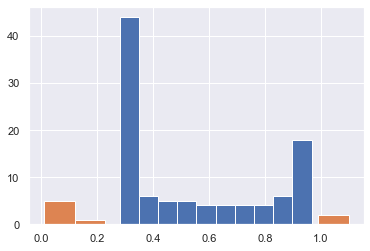

In [202]:
from scipy import stats

src = np.array([1, 2, 3, 3, 10, 15, 100, 110])/100
kde1 = stats.gaussian_kde(src)
x1 = np.linspace(0, 1, 100)
y1 = kde1.pdf(x1)

plt.hist(y1)
plt.hist(src)
diptest.dipstat(y1), diptest.dipstat(src)

In [676]:
bstr.models[0].nodes[16].leaf_model.lists['time']

[1701.0, 1701.0, 552.0, 2030.0, 552.0, 449.0, 1306.0, 1013.0, 1306.0]

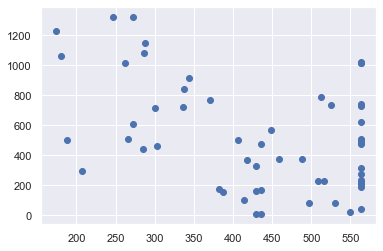

In [700]:
cnt_dist = []
dip_stat = []

for k, n in bstr.models[0].nodes.items():
    if not(n.is_leaf):
        continue
#     print(k)
    sf = n.leaf_model.predict_survival_at_times(X=None, bins=bins_HO)
# #     plt.step(bins_HO, sf, label=f"{n.leaf_model.lists['time']}: {stats.iqr(n.leaf_model.lists['time'])}")
#     plt.step(bins_HO, sf, label=f"{n.leaf_model.lists['time']}: {np.sum((sf - 0.5)**2)}")
# #     plt.step(bins_HO, sf, label=f"{n.leaf_model.lists['time']}: {diptest.dipstat(n.leaf_model.lists['time'])}")
#     plt.legend()
#     plt.show()
    
    cnt_dist.append(np.sum((sf - 0.5)**2))
    dip_stat.append(stats.iqr(n.leaf_model.lists['time']))

plt.scatter(cnt_dist, dip_stat)

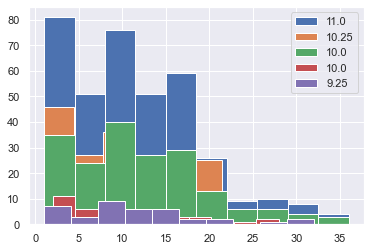

In [618]:
plt.hist(y["time"], label=f"{stats.iqr(y['time'])}")
plt.hist(y["time"][::2], label=f"{stats.iqr(y['time'][::2])}")
plt.hist(y["time"][1::2], label=f"{stats.iqr(y['time'][1::2])}")
plt.hist(y["time"][::10], label=f"{stats.iqr(y['time'][::10])}")
plt.hist(y["time"][1::10], label=f"{stats.iqr(y['time'][1::10])}")
plt.legend()

Text(0.5, 1.0, '0.08333333333333333')

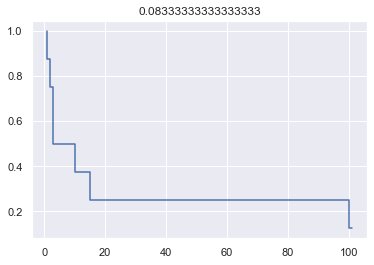

In [599]:
src = np.array([1, 2, 3, 3, 10, 15, 100])
a = random.choice(src)
n = np.cumsum(np.bincount(a)[::-1])[::-1]
o = np.bincount(a)
st = np.cumprod(1 - o/(n + 1))
plt.step(np.arange(a.min(), a.max()+2), st)
plt.title(diptest.dipstat(a))

In [203]:
from sklearn.model_selection import train_test_split
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
# X, y, features, categ, sch_nan = ds.load_wuhan_dataset()
# y["time"] += 1

# # y["cens"] = ~y["cens"]
# features = list(set(features) - {"max_2019_nCoV_nucleic_acid_detection", 
#                                  "mean_2019_nCoV_nucleic_acid_detection", 
#                                  "min_2019_nCoV_nucleic_acid_detection"})
# X = X[features]

X_TR, X_HO = train_test_split(X, stratify=y[cnt.CENS_NAME],
                              test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

df = X_HO.copy()
df["time"] = y_HO["time"]
df["cens"] = y_HO["cens"]

df_tr = X_tr.copy()
df_tr["time"] = y_tr["time"]
df_tr["cens"] = y_tr["cens"]

In [195]:
from survivors.ensemble import BootstrapCRAID
param_bstr = {'balance': None, 'categ': categ, 
        'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'IBS_REMAIN', 
        'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.01,
        'n_estimators': 50, 'n_jobs': 5, 'size_sample': 0.7}


bstr = BootstrapCRAID1(**param_bstr)
bstr.fit(X_tr, y_tr)
bstr.tolerance_find_best(param_bstr["ens_metric_name"])
pred_time = bstr.predict(X_HO, target="time")
pred_surv = bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_haz = bstr.predict_at_times(X_HO, bins=bins_HO, mode="hazard")

print(count_metric(y_tr, y_HO, pred_time,
                   pred_surv, pred_haz, bins_HO,
                   ['CI', "IBS_REMAIN", "BAL_IBS_REMAIN", "IAUC_WW_TI", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [1 3 3 4 2 4 3 5 2 2 4 3 4 2 4 3 5 2 2 4 5 1 3 3 3 5 2 3 3 3 5 3 3 2 3 4 4
 2 5 2 3 5 2 2 3 5 2 3 3 3 5 3 2 3 4 5 1 4 2 3 5 3 2 3 3 4 3 3 4 2 4 3 3 3
 4 3 4 3 3 2 4 4 3 4 2 3 3 3 3 3 6 1 4 2 3 4 4 2 3 3 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [1 3 3 4 2 4 3 5 2 2 4 3 4 2 4 3 5 2 2 4 5 1 3 3 3 5 2 3 3 3 5 3 3 2 3 4 4
 2 5 2 3 5 2 2 3 5 2 3 3 3 5 3 2 3 4 5 1 4 2 3 5 3 2 3 3 4 3 3 4 2 4 3 3 3
 4 3 4 3 3 2 4 4 3 4 2 3 3

[0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 1 2 2 2 3 2 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 1 2 2 2 3 2 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 1 2 2 2 3 2 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 2 3 0 2 3 1 2 3 1 3 1 2 2 2 4 0 4 0 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 2 3 0 2 3 1 2 3 1 3 1 2 2 2 4 0 4 0 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 2 3 0 2 3 1 2 3 1 3 1 2 2 2 4 0 4 0 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 2 2 2 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 2 2 2 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 2 2 2 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 2 2 2 3 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 2 2 2 3 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [3 0 2 2 1 3 1 3 1 2 2 3 1 3 1 2 2 2 4 0 2 2 2 2 3 2 1 2 2 2 2 2 2 3 1 2 2
 2 3 1 3 3 0 2 2 3 3 0 2 2 2 2 2 2 2 2 2 2 2 2 3 2 1 3 2 1 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [3 0 2 2 1 3 1 3 1 2 2 3 1 3 1 2 2 2 4 0 2 2 2 2 3 2 1 2 2 2 2 2 2 3 1 2 2
 2 3 1 3 3 0 2 2 3 3 0 2 2 2 2 2 2 2 2 2 2 2 2 3 2 1 3 2 1 2 2 2 2 2]
[0. 0. 0. 0. 0. 0.] [1 1 2 2 3 1]
[0. 0. 0. 0. 0. 0.] [1 1 2 2 3 1]
[0. 0. 0. 0. 0. 0.] [1 1 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 3 3 0 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 3 3 0 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 3 3 0 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 2 2 2 2 2 4 0 2 2 2 3 1 2 2 3 3 0 2 2 2 3 1 2 3 2 1 3 2 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 3 1 2 2 2 2 2 2 3 1 3 1 2 2 3 1 2 3 1 2 2 2 3 1 2 2 2 2 3 1 2 2 2 2 2
 3 1 3 1 2 2 3 3 0 3 1 3 1 4 0 2 6 0 0 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 3 1 2 2 2 2 2 2 3 1 3 1 2 2 3 1 2 3 1 2 2 2 3 1 2 2 2 2 3 1 2 2 2 2 2
 3 1 3 1 2 2 3 3 0 3 1 3 1 4 0 2 6 0 0 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 3 1 2 2 2 2 2 2 3 1 3 1 2 2 3 1 2 3 1 2 2 2 3 1 2 2 2

[0. 0. 0. 0.] [1 2 3 1]
[0. 0. 0. 0.] [1 2 3 1]
[0. 0. 0. 0.] [1 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] [3 0 3 0 2 2 2 3 1 2 2 2 2 2 2 3 1 5 0 2 1 4 0 2 2 2 2 4 0 2 2 3 1 2 2 2 2
 2 2 3 1 5 0 1 2 2 2 3 1 3 2 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] [3 0 3 0 2 2 2 3 1 2 2 2 2 2 2 3 1 5 0 2 1 4 0 2 2 2 2 4 0 2 2 3 1 2 2 2 2
 2 2 3 1 5 0 1 2 2 2 3 1 3 2 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] [3 0 3 0 2 2 2 3 1 2 2 2 2 2 2 3 1 5 0 2 1 4 0 2 2 2 2 4 0 2 2 3 1 2 2 2 2
 2 2 3 1 5 0 1 2 2 2 3 1 3 2 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 3 2 1 2 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 3 2 1 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 4 0 3 1 2 2 3 1 3 1 2 3 1 2 2 2 3 1 2 3 1 2 3 1 2 3 1 2 2 2 2 3 2 1 3
 2 1 2 3 1 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 4 0 3 1 2 2 3 1 3 1 2 3 1 2 2 2 3 1 2 3 1 2 3 1 2 3 1 2 2 2 2 3 2 1 3
 2 1 2 3 1 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 1 3 2 1 2 3 1 3 2 1 2 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 1 3 2 1 2 3 1 3 2 1 2 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 1 3 2 1 2 3 1 3 2 1 2 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.] [3 0 2 2 2 2 2 4 0 2 5 0 1 3 1 3 1 2 2 2 3 1 2 2 3 1 4 0 2 4 0 2 2]
[0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0.] [3 0 2 1 4 0 2]
[0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2]
[0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2]
[0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 2 1 2 3 1 2 2 2 2 2 3 2 1 2 2 2 3 1 2 4 0 4 0 3 1 2 2 3 1 2 2 2 2 2 2
 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 2 1 2 3 1 2 2 2 2 2 3 2 1 2 2 2 3 1 2 4 0 4 0 3 1 2 2 3 1 2 2 2 2 2 2
 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 2 1 2 3 1 2 2 2 2 2 3 2 1 2 2 2 3 1 2 4 0 4 0 3 1 2 2 3 1 2 2 2 2 2 2
 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 3 2 1 2 2 3 1 2 2 3 1 2 2 3 1 2 2 2 2 3 1 3 1 2 2 2 2 2 2 2 2 4 0
 4 0 2 2 3 1 2 2]
[0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 3 2 1 2 2 2 3 1 3 2 1 2 2 2 2 3 1 3 2 2 1 3 1 4 0 2 3 3 0 2 4 0 2 2
 3 3 0 2 2 6 0 0 2 3 4 0 1 2 2 2 2 2 3 3 0 2 3 1 2 2 2 2 2 2 2 2 4 0 2 2 2
 2 2 3 1 2 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 3 2 2 4 0 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 3 2 2 4 0 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 3 2 2 4 0 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 3 1 2 4 0 2 2 2 2 2 2 2 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 3 1 2 4 0 2 2 2 2 2 2 2 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 3 1 2 4 0 2 2 2 2 2 2 2 2 2 3 1]
[0. 0. 0. 0.] [3 0 2 1]
[0. 0. 0. 0.] [3 0 2 1]
[0. 0. 0. 0.] [3 0 2 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 2 1 2 2 2 2 2 2 2 2

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [1 1 2 2 4 0 2 2 3 2 1 2 2 3 1 3 1 3 1 2 7 0 0 2 1 4 0 2 2 3 1 2 2 3 1 2 2
 2 2 2 2 2 2 3 1 2 3 1 2 2 2 2 2 2 5 0 1 2 3 2 2 2 2 1 3 3 0 2 2 2 3 1 2 2
 2 4 0 2 3 2 2 1 2 2 4 0 2 3 1 2 2 3 2 1 3 2 1 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [1 1 2 2 4 0 2 2 3 2 1 2 2 3 1 3 1 3 1 2 7 0 0 2 1 4 0 2 2 3 1 2 2 3 1 2 2
 2 2 2 2 2 2 3 1 2 3 1 2 2 2 2 2 2 5 0 1 2 3 2 2 2 2 1 3 3 0 2 2 2 3 1 2 2
 2 4 0 2 3 2 2 1 2 2 4 0 2

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2 2 2 2 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2 2 2 2 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2 2 2 2 4]
[0. 0. 0. 0.] [1 2 2 2]
[0. 0. 0. 0.] [1 2 2 2]
[0. 0. 0. 0.] [1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 4 0 2 2 2 2 2 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 4 0 2 2 2 2 2 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 4 0 2 2 2 2 2 4]
[0. 0. 0. 0. 0.] [1 3 1 3 1]
[0. 0. 0. 0. 0.] [1 3 1 3 1]
[0. 0. 0. 0. 0.] [1 3 1 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 3 1 2 2 2 2 3 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 3 1 2 2 2 2 3 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 3 1 2 2 2 2 3 1 2 2 2]
[0. 0. 0. 0.] [1 3 0 2]
[0. 0. 0. 0.] [1 3 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 3 2 1 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 3 2 1 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 3 2 1 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 2 1 3 1 2 3 2 1 2 2 2 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 2 1 3 1 2 3 2 1 2 2 2 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 2 1 3 1 2 3 2 1 2 2 2 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2]
[0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2]
[0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2]
[0. 0. 0. 0. 0. 0.] [3 0 1 4 0 2]
[0. 0. 0. 0. 0. 0.] [3 0 1 4 0 2]
[0. 0. 0. 0. 0. 0.] [3 0 1 4 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.] [1 1 2 4 0 2 2 2 2 2 3 3 0 2 2 2 2 2 2 2 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.] [1 1 2 4 0 2 2 2 2 2 3 3 0 2 2 2 2 2 2 2 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [3 0 1 2 3 2 1 3 3 0 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 1 2 5 0 1 2 3 2 2 1 2 3 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 1 2 5 0 1 2 3 2 2 1 2 3 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 1 2 5 0 1 2 3 2 2 1 2 3 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 2 1 3 2 1 4 0 3 1 2 2 2 1 3 2 2 4 0 3 1 2 2 3 1 2 1 3 4 0 2 2 3 1 2 2 2
 2 2

[0. 0. 0. 0.] [1 3 2 1]
[0. 0. 0. 0.] [1 3 2 1]
[0. 0. 0. 0.] [1 3 2 1]
[0. 0. 0. 0. 0.] [1 2 2 2 2]
[0. 0. 0. 0. 0.] [1 2 2 2 2]
[0. 0. 0. 0. 0.] [1 2 2 2 2]
[0. 0. 0. 0. 0.] [2 1 2 2 2]
[0. 0. 0. 0. 0.] [2 1 2 2 2]
[0. 0. 0. 0. 0.] [2 1 2 2 2]
[0. 0. 0. 0. 0.] [1 5 0 1 2]
[0. 0. 0. 0. 0.] [1 5 0 1 2]
[0. 0. 0. 0. 0.] [1 5 0 1 2]
[0. 0. 0. 0. 0. 0.] [1 3 3 0 2 2]
[0. 0. 0. 0. 0. 0.] [1 3 3 0 2 2]
[0. 0. 0. 0. 0. 0.] [1 3 3 0 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 2 2 2 4 0 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 2 2 2 4 0 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 2 2 2 4 0 2 2]
[0. 0. 0. 0. 0. 0. 0.] [2 1 2 2 2 3 3]
[0. 0. 0. 0. 0. 0. 0.] [2 1 2 2 2 3 3]
[0. 0. 0. 0. 0. 0. 0.] [2 1 2 2 2 3 3]
[0. 0. 0. 0. 0.] [2 0 2 2 2]
[0. 0. 0. 0. 0.] [2 0 2 2 2]
[0. 0. 0. 0. 0.] [2 0 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [1 3 1 4 0 2 2 2 3 1 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [2 2 1 3 2 4 0 1 2 2 2 2 2 4 0 2 4 0 2 2 3 1 2 3 1 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [2 2 1 3 2 4 0 1 2 2 2 2 2 4 0 2 4 0 2 2 3 1 2 3 1 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [2 2 1 3 2 4 0 1 2 2 2 2 2 4 0 2 4 0 2 2 3 1 2 3 1 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 3 2 2 1 2 2 2 2 2 2 1 4 1 2 2 3 2 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 3 2 2 1 2 2 2 2 2 2 1 4 1 2 2 3 2 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 3 2 2 1 2 2 2 2 2 2 1 4 1 2 2 3 2 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] [1 2 3 1 5 0 1 2 2 3 1 3 2 1 2 4 0 2 3 2 1 2 2 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[0. 0. 0. 0.] [4 0 1 2]
[0. 0. 0. 0.] [4 0 1 2]
[0. 0. 0. 0.] [4 0 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 5 0 1 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 5 0 1 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 5 0 1 2 2 3 1]
[0. 0. 0. 0. 0.] [1 3 1 2 2]
[0. 0. 0. 0. 0.] [1 3 1 2 2]
[0. 0. 0. 0. 0.] [1 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 4 0 2 3 2 1 3 2 1 2 3 1 2 3 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 4 0 2 3 2 1 3 2 1 2 3 1 2 3 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 4 0 2 3 2 1 3 2 1 2 3 1 2 3 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 1 2 2 2 2 2 3 3 0 2 2 2 2 3 1 2 2 2 2 2 2 2 2 2 2 2 6 0 0 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 1 2 2 2 2 2 3 3 0 2 2 2 2 3 1 2 2 2 2 2 2 2 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [3 0 2 2 2 2 2 2 3 2 1 2 3 2 1 4 0 2 2 2 2 2 3 2 1 4 0 2 2 2 2 3 1 4 0 2 3
 1 2 3 1 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.] [1 1 2 3 1 2 2 2 3 2 1 2 2 4 0 3 2 2 1 4 0 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.] [1 1 2 3 1 2 2 2 3 2 1 2 2 4 0 3 2 2 1 4 0 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.] [1 1 2 3 1 2 2 2 3 2 1 2 2 4 0 3 2 2 1 4 0 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 1 3 1 2 2 4 0 2 2 2 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 1 3 1 2 2 4 0 2 2 2 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 1 3 1 2 2 4 0 2 2 2 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[0. 0. 0. 0.] [1 3 1 2]
[0. 0. 0. 0.] [1 3 1 2]
[0. 0. 0. 0.] [1 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] [2 2 1 2 2 3 1 4 0 2 2 2 4 0 3 2 1 2 3 1 5 0 3 0 3 1 6 0 0 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] [2 2 1 2 2 3 1 4 0 2 2 2 4 0 3 2 1 2 3 1 5 0 3 0 3 1 6 0 0 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] [2 2 1 2 2 3 1 4 0 2 2 2 4 0 3 2 1 2 3 1 5 0 3 0 3 1 6 0 0 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 2 3 2 2 4 0 2 2 1 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 2 3 2 2 4 0 2 2 1 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 2 3 2 2 4 0 2 2 1 3 1 2 2]
[0. 0. 0. 0.] [2 0 2 2]
[0. 0. 0. 0.] [2 0 2 2]
[0. 0. 0. 0.] [2 0 2 2]
[0. 0. 0. 0. 0. 0. 0.] [3 0 1 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0.] [3

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 2 2 1 3 2 1 4 0 2 3 1 2 3 1 2 3 4 0 1 5 0 1 2 3 2 1 2 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 2 2 1 3 2 1 4 0 2 3 1 2 3 1 2 3 4 0 1 5 0 1 2 3 2 1 2 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 2 2 1 3 2 1 4 0 2 3 1 2 3 1 2 3 4 0 1 5 0 1 2 3 2 1 2 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 3 2 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 3 2 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 3 2 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 3 0 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 3 0 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 3 0 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0.] [2 1 4 0 2 2 2]
[0. 0. 0. 0. 0. 0. 0.] [2 1 4 0 2 2 2]
[0. 0. 0. 0. 0. 0. 0.] [2 1 4 0 2 2 2]
[0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 3 1 2 2 2 2 2 3 1 2 3 1 2 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 3 1 2 2 2 2 2 3 1 2 3 1 2 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 2 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 2 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 2 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 3 1 2 2 3 1 3 1 3 1 2 3 1 2 3 1 2 3 1 3 2 1 3 1 2 4 0 2 4 0 2 3 1 3
 1 4 0 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 3 1 2 2 3 1 3 1 3 1 2 3 1 2 3 1 2 3 1 3 2 1 3 1 2 4 0 2 4 0 2 3 1 3
 1 4 0 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0.] [3 0 2 1]
[0. 0. 0. 0.] [3 0 2 1]
[0. 0. 0. 0.] [3 0 2 1]
[0. 0. 0. 0. 0.] [1 2 3 2 3]
[0. 0. 0. 0. 0.] [1 2 3 2 3]
[0. 0. 0. 0. 0.] [1 2 3 2 3]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2 2 3 1 2 2 2 2 3 1 2 3 1 3 1 2 2 4 0 2 4 0 2 2 2 2 2 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2 2 3 1 2 2 2 2 3 1 2 3 1 3 1 2 2 4 0 2 4 0 2 2 2 2 2 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2 2 3 1 2 2 2 2 3 1 2 3 1 3 1 2 2 4 0 2 4 0 2 2 2 2 2 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 3 1 3 1 2 2 2 2 2 2 4 0 1 3 2 3 1 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 3 1 3 1 2 2 2 2 2 2 4 0 1 3 2 3 1 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 3 1 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 3 1 2 3 1]
[0. 0. 0. 0. 0.] [3 0 2 1 2]
[0. 0. 0. 0. 0.] [3 0 2 1 2]
[0. 0. 0. 0. 0.] [3 0 2 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2 3 1 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2 3 1 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2 3 1 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 2 2 3 1 2 3 2 3 0 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 2 2 3 1 2 3 2 3 0 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 2 2 3 1 2 3 2 3 0 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 3 1 2 2 2 4 0 2 3 1 2 3 1 2 3 1 4 0 3 2 1 2 4 0 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 3 1 2 2 2 4 0 2 3 1 2 3 1 2 3 1 4 0 3 2 1 2 4 0 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2 2 2 2 2 3 1 2 2 2 2 3 2 2 2 1 2 2 2 2 2 2 2 3 1 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2 2 2 2 2 3 1 2 2 2 2 3 2 2 2 1 2 2 2 2 2 2 2 3 1 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2 2 2 2 2 3 1 2 2 2 2 3 2 2 2 1 2 2 2 2 2 2 2 3 1 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 2 2 3 1 2 2 2 4 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 2 2 3 1 2 2 2 4 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 2 2 3 1 2 2 2 4 0 2]
[0. 0. 0. 0. 0.] [1 2 1 3 1]
[0. 0. 0. 0. 0.] [1 2 1 3 1]
[0. 0. 0. 0. 0.] [1 2 1 3 1]
[0. 0. 0. 0.] [1 1 2 2]
[0. 0. 0. 0.] [1 1 2 2]
[0. 0. 0. 0.] [1 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [3 0 3 1 2 2 2 2 3 1 3 1 2 2 2 3 2 2 1 2 2 2 2 2 2 2 2 2 2 2 4 0 2 3 1 2 2
 4 0 2 2 2 3 1 2 3 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 1 2 2 2 3 1 2 2 4 0 3 1
 3 1 2 2 2 2 3 1 3 2 1 2 2 4 0 2 2 4 0 2 2 2 3 3 0 2 3]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [3 0 3 1 2 2 2 2 3 1 3 1 2 2 2 3 2 2 1 2 2 2 2 2 2 2 2 2 2 2 4 0 2 3 1 2 2
 4 0 2 2 2 3 1 2 3 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 1 2 2 2 3 1 2 2 4 0 3 1
 3 1 2 2 2 2 3 1 3 2 1 2 2

[0. 0. 0. 0.] [1 1 2 2]
[0. 0. 0. 0.] [1 1 2 2]
[0. 0. 0. 0.] [1 1 2 2]
[0. 0. 0. 0. 0.] [1 3 1 2 2]
[0. 0. 0. 0. 0.] [1 3 1 2 2]
[0. 0. 0. 0. 0.] [1 3 1 2 2]
[0. 0. 0. 0.] [1 2 2 3]
[0. 0. 0. 0.] [1 2 2 3]
[0. 0. 0. 0.] [1 2 2 3]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 2 2 2 2 2 2 2 3 1 3 2 1 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 2 2 2 2 2 2 2 3 1 3 2 1 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 2 2 2 2 2 2 2 3 1 3 2 1 2 3 1]
[0. 0. 0. 0.] [2 3 0 4]
[0. 0. 0. 0.] [2 3 0 4]
[0. 0. 0. 0.] [2 3 0 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 4 0 3 1 2 2 2 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 4 0 3 1 2 2 2 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 4 0 3 1 2 2 2 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 1 2 2 2 3 2 1 2 4 0 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 4 0 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 4 0 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 4 0 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 2 1 2 2 2 2 2 2 5 0 1 4 0 2 2 3 1 5 0 1 2 2 2 2 2 2 2 4 0 2 2 2 2 3 1
 3 2 1 2 2 2 3 3 0 2 3 2 0 3 4 0 4 0 3 1 2 4 0 2 2 2 2 2 2 3 1 2 2 3 2 1 2
 2 2 2 2 2 2 3 1 3 1 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 2 1 2 2 2 2 2 2 5 0 1 4 0 2 2 3 1 5 0 1 2 2 2 2 2 2 2 4 0 2 2 2 2 3 1
 3 2 1 2 2 2 3 3 0 2 3 2 0 3 4 0 4 0 3 1 2 4 0 2 2 2 2 2 2 3 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] [1 2 1 2 2 2 2 2 2 3 1 2 3 2 2 1 2 2 2 2 2 2 2 2 3 1 2 2 2 2 4 0 2 3 1 2 3
 2 1 2 2 2 2 3 1 2 4 0 3 2 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] [1 2 1 2 2 2 2 2 2 3 1 2 3 2 2 1 2 2 2 2 2 2 2 2 3 1 2 2 2 2 4 0 2 3 1 2 3
 2 1 2 2 2 2 3 1 2 4 0 3 2 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] [2 2 1 2 2 2 2 3 1 2 3 1 4 0 2 2 2 3 1 2 3 1 2 2 2 2 2 3 1 2 2 2 2 3 1 2 2
 2 2 3 3 0 2 2 3 1 3 1 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] [2 2 1 2 2 2 2 3 1 2 3 1 4 0 2 2 2 3 1 2 3 1 2 2 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 3 1 2 3 1 3 1 2 3 1 2 2]
[0. 0. 0. 0. 0.] [1 1 2 3 1]
[0. 0. 0. 0. 0.] [1 1 2 3 1]
[0. 0. 0. 0. 0.] [1 1 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] [2 0 2 2 3 3 0 3 1 2 2 2 2 3 1 2 3 3 0 2 3 2 1 5 0 2 3 0 3 1 3 1 2 2 2 2 2
 3 2 1 2 2 3 1 2 2 2 2 3 1 2 3 1 2 2 2 3 1 2 2 3 1 4 0 2 2 3 1 2 2 2 2 3 1
 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] [2 0 2 2 3 3 0 3 1 2 2 2 2 3 1 2 3 3 0 2 3 2 1 5 0 2 3 0 3 1 3 1 2 2 2 2 2
 3 2 1 2 2 3 1 2 2 2 2 3 1 2 3 1 2 2 2 3 1 2 2 3 1 4 0 2 2 3 1 2 2 2 2 3 1
 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 3 1 2 3 1 2 3 1 2 2 2 2 2 2 3 2 2 1 2 2 2 3 1 2 2 2 2 2 2 4 0 3 3 0
 2 2 2 2 2 2 3 2 2 1 2 2 2 4 0 2 2 2 3 3 0 2 2 2 2 2 2 2 3 1 2 2 2 2 2 3 2
 2 3 0 3 3 0 3 3 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 3 1 4 0 3 1 4 0 3 1 2 4 0 2 2 2 3 2 1 2 2 2 2 2 2 2 2 2 3 1 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 3 1 4 0 3 1 4 0 3 1 2 4 0 2 2 2 3 2 1 2 2 2 2 2 2 2 2 2 3 1 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 3 1 4 0 3 1 4 0 3 1 2 4 0 2 2 2 3 2 1 2 2 2 2 2 2 2 2 2 3 1 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [3 1 3 3 3 4 3 3 3 4 4 2 6 0 3 4 3 3 3 3 4 3 3 4 3 3 3 5 1 3 4 3 3 3 3 4 3
 4 2 3 4 4 2 4 2 4 4 2 5 1 5 2 3 4 2 4 3 4 3 2 5 2 3 3 3 4 3 3 3 4 3 4 4 1
 4 3 4 3 2 3 4 3 3 3 3 4 3 3 4 2 4 4 2 4 2 4 4 3 2 4 3]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [3 1 3 3 3 4 3 3 3 4 4 2 6 0 3 4 3 3 3 3 4 3 3 4 3 3 3 5 1 3 4 3 3 3 3 4 3
 4 2 3 4 4 2 4 2 4 4 2 5 1 5 2 3 4 2 4 3 4 3 2 5 2 3 3 3 4 3 3 3 4 3 4 4 1
 4 3 4 3 2 3 4 3 3 3 3 4 3

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 1 2 2 2 3 1 2 2 2 4 0 4 0 3 1 3 2 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 1 2 2 2 3 1 2 2 2 4 0 4 0 3 1 3 2 1]
[0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 3 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 3 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 3 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 3 1 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 3 1 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 3 1 3 1 2]
[0. 0. 0. 0. 0. 0. 0.] [1 3 1 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0.] [1 3 1 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0.] [1 3 1 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 4 0 2 2 2 2 2 2 2 2 3 1 3 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 4 0 2 2 2 2 2 2 2 2 3 1 3 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 4 0 2 2 2 2 2 2 2 2 3 1 3 1 2 2 2]
[0. 0. 0. 0. 0.] [1 1 2 3 1]
[0. 0. 0. 0. 0.] [1 1 2 3 1]
[0. 0. 0. 0. 0.] [1 1 2 3 1]
[0. 0. 0. 0.] [1 3 1 2]
[0.

[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 2 1 2 3 1 2]
[0. 0. 0. 0. 0. 0.] [2 0 3 1 2 2]
[0. 0. 0. 0. 0. 0.] [2 0 3 1 2 2]
[0. 0. 0. 0. 0. 0.] [2 0 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 3 1 2 2 2 2 2 2 3 1 2 3 1 2 4 0 2 2 3 1 2 3 1 2 4 0 2 2 2 2 2 3 1 2
 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 3 1 2 2 2 2 2 2 3 1 2 3 1 2 4 0 2 2 3 1 2 3 1 2 4 0 2 2 2 2 2 3 1 2
 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 3 1 2 2 2 2 2 2 3 1 2 3 1 2 4 0 2 2 3 1 2 3 1 2 4 0 2 2 2 2 2 3 1 2
 2 2 2]
[0. 0. 0. 0. 0.] [2 0 4 0 2]
[0. 0. 0. 0. 0.] [2 0 4 0 2]
[0. 0. 0. 0. 0.] [2 0 4 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 3 2 1 2 2 2 2 3 2 1 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 3 2 1 3 1 4 0 2 2 2 2 2 2 2 2 2 2 3 1 3 1 2 2 4 0 2 3 2 1 3 1 2 3 1 2
 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 4 0 2 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 4 0 2 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 4 0 2 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 3 0 2 2 2 3 1 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 3 0 2 2 2 3 1 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 3 0 2 2 2 3 1 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 1 4 0 4 0 3 1 2 2 2 2 4 0 2 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 1 4 0 4 0 3 1 2 2 2 2 4 0 2 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 1 4 0 4 0 3 1 2 2 2 2 4 0 2 2 2 3 1 2]
[0. 0. 0. 0. 0. 0.

[0. 0. 0. 0. 0.] [1 2 2 2 2]
[0. 0. 0. 0. 0.] [1 2 2 2 2]
[0. 0. 0. 0. 0.] [1 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 2 4 0 3 1 2 2 2 2 2 3 1 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 2 4 0 3 1 2 2 2 2 2 3 1 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 2 4 0 3 1 2 2 2 2 2 3 1 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [3 0 1 2 2 2 3 1 2 2 2 3 1 2 3 1 2 2 2 3 1 2 2 2 2 2 2 2 2 2 3 1 4 0 3 3 0
 3 2 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [3 0 1 2 2 2 3 1 2 2 2 3 1 2 3 1 2 2 2 3 1 2 2 2 2 2 2 2 2 2 3 1 4 0 3 3 0
 3 2 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [3 0 1 2 2 2 3 1 2 2 2 3 1 2 3 1 2 2 2 3 1 2 2 2 2 2 2 2 2 2 3 1 4

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 3 1 3 1 2 2 2 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 3 1 3 1 2 2 2 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 3 1 3 1 2 2 2 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 3 1 3 1 2 3 3 0 2 2 2 1 3 2 2 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 3 1 3 1 2 3 3 0 2 2 2 1 3 2 2 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 3 1 3 1 2 3 3 0 2 2 2 1 3 2 2 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 4 0 2 2 2 2 2 2 2 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 4 0 2 2 2 2 2 2 2 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 4 0 2 2 2 2 2 2 2 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 3 1 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 3 1 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 3 1 2 3 1 2 2]
[0. 0. 0. 0. 0. 0.] [3 0 4 0 2 2]
[0. 0. 0. 0. 0. 0.] [3 0 4 0 2 2]
[0. 0. 0. 0. 0. 0.] [3 0 4 0 2 2]
[0. 0. 0. 0. 0. 0.] [1 2 3 1 3 1]
[0. 0.

[0. 0. 0. 0.] [1 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.] [2 1 2 2 3 1 3 2 3 0 2 3 1 2 2 2 2 3 1 2 4 0 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.] [2 1 2 2 3 1 3 2 3 0 2 3 1 2 2 2 2 3 1 2 4 0 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.] [2 1 2 2 3 1 3 2 3 0 2 3 1 2 2 2 2 3 1 2 4 0 2 2 2 2]
[0. 0. 0. 0.] [1 1 2 2]
[0. 0. 0. 0.] [1 1 2 2]
[0. 0. 0. 0.] [1 1 2 2]
[0. 0. 0. 0. 0.] [2 2 1 3 1]
[0. 0. 0. 0. 0.] [2 2 1 3 1]
[0. 0. 0. 0. 0.] [2 2 1 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 3 1 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 3 1 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 3 1 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [1 3 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 1 2 4 0 2 3 3 0 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [1 3 1 2 2 2 2 2 2 2 2 2 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 1 2 2 4 0 2 2 2 4 0 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 1 2 2 4 0 2 2 2 4 0 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 1 2 2 4 0 2 2 2 4 0 2 2]
[0. 0. 0. 0. 0.] [2 0 2 3 1]
[0. 0. 0. 0. 0.] [2 0 2 3 1]
[0. 0. 0. 0. 0.] [2 0 2 3 1]
[0. 0. 0. 0.] [1 3 1 2]
[0. 0. 0. 0.] [1 3 1 2]
[0. 0. 0. 0.] [1 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 0 2 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 0 2 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 0 2 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [3 0 1 2 2 2 2 2 3 2 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [3 0 1 2 2 2 2 2 3 2 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [3 0 1 2 2 2 2 2 3 2 1 2 2]
[0. 0. 0. 0. 0. 0. 0.] [1 3 1 3 1 3 1]
[0. 0. 0. 0. 0. 0. 0.] [1 3 1 3 1 3 1]
[0. 0. 0. 0. 0. 0. 0.] [1 3 1 3 1 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 3 1 2 4 0 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 3 1 2 4 0 2 2 2 2]
[0. 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 2 2 3 1 2 2 4 0 3 3 0 2 2 2 3 1 2 6 0 0 2 2 2 3 3 0 2 2 2 2 2
 3 1 2 2]
[0. 0. 0. 0. 0. 0.] [7 0 0 0 1 2]
[0. 0. 0. 0. 0. 0.] [7 0 0 0 1 2]
[0. 0. 0. 0. 0. 0.] [7 0 0 0 1 2]
[0. 0. 0. 0. 0.] [1 2 2 2 2]
[0. 0. 0. 0. 0.] [1 2 2 2 2]
[0. 0. 0. 0. 0.] [1 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 4 0 5 0 1 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 4 0 5 0 1 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 4 0 5 0 1 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 4 0 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 4 0 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 4 0 2 3 1]
[0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2]
[0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2]
[0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 3 1 3 1 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 3 1 3 1 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 3 1 3 1 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0.] [3 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 3 1 2 2 2 2 2 3 2 1 2 2 4 0 6 0 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 3 1 2 2 2 2 2 3 2 1 2 2 4 0 6 0 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 3 1 2 2 2 2 2 3 2 1 2 2 4 0 6 0 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 1 2 2 3 1 2 2 2 2 2 2 2 4 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 1 2 2 3 1 2 2 2 2 2 2 2 4 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 1 2 2 3 1 2 2 2 2 2 2 2 4 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2 3 1 2 3 3 0 2 2 2 2 2 2 3 1 3 2 1 2 3 1 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2 3 1 2 3 3 0 2 2 2 2 2 2 3 1 3 2 1 2 3 1 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0. 0.] [1 2 3 0 2]
[0. 0. 0. 0. 0.] [1 2 3 0 2]
[0. 0. 0. 0. 0.] [2 1 2 2 2]
[0. 0. 0. 0. 0.] [2 1 2 2 2]
[0. 0. 0. 0. 0.] [2 1 2 2 2]
[0. 0. 0.] [1 2 4]
[0. 0. 0.] [1 2 4]
[0. 0. 0.] [1 2 4]
[0. 0. 0. 0.] [1 1 2 2]
[0. 0. 0. 0.] [1 1 2 2]
[0. 0. 0. 0.] [1 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 3 1 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 3 1 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 3 1 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 3 1 3 3 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 3 1 3 3 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 3 1 3 3 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 3 2 2 3 0 3 1 2 2 6 0 0 2 2 2 2 6 0 0 2 2 3 1 2 3 1 3 2 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 3 2 2 3 0 3 1 2 2 6 0 0 2 2 2 2 6 0 0 2 2 3 1 2 3 1 3 2 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 2 2 2 2 3 1 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 2 2 2 2 3 1 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 2 2 2 2 3 1 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 2 1 2 3 2 1 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 2 1 2 3 2 1 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 2 1 2 3 2 1 3 1]
[0. 0. 0. 0. 0.] [3 0 2 2 1]
[0. 0. 0. 0. 0.] [3 0 2 2 1]
[0. 0. 0. 0. 0.] [3 0 2 2 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2 3 1 2 2 2 2 2 2 2 6 0 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2 3 1 2 2 2 2 2 2 2 6 0 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2 3 1 2 2 2 2 2 2 2 6 0 0 2]
[0. 0. 0. 0. 0. 0.] [1 3 1 2 2 2]
[0. 0. 0. 0. 0. 0.] [1 3 1 2 2 2]
[0. 0. 0. 0. 0. 0.] [1 3 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0.] [3 0 2 4 0 2 2]
[0. 0. 0. 0. 0. 0. 0.] [3 0 2 4 0 2 2]
[0. 0. 0. 0. 0. 0. 0.] [3 0 2 4 0 2 2]
[0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [3 0 2 1 2 2 3 1 2 2 2 2 4 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [3 0 2 1 2 2 3 1 2 2 2 2 4 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [3 0 2 1 2 2 3 1 2 2 2 2 4 0 2]
[0. 0. 0. 0. 0. 0.] [2 0 2 3 1 2]
[0. 0. 0. 0. 0. 0.] [2 0 2 3 1 2]
[0. 0. 0. 0. 0. 0.] [2 0 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 2 2 2 2 2 2 2 4 0 3 1 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 2 2 2 2 2 2 2 4 0 3 1 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 2 2 2 2 2 2 2 4 0 3 1 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 3 1 2 3 1 2 2 2 4 0 2 3 1 2 2 2 2 2 2 2 2 2 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 3 1 2 3 1 2 2 2 4 0 2 3 1 2 2 2 2 

[0. 0. 0. 0.] [1 4 0 2]
[0. 0. 0. 0.] [1 4 0 2]
[0. 0. 0. 0.] [1 4 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 3 1 2 4 0 2 2 2 2 2 3 1 2 2 3 1 2 2 2 2 2 2 3 1 2 2 2 2 2 2 4 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 3 1 2 4 0 2 2 2 2 2 3 1 2 2 3 1 2 2 2 2 2 2 3 1 2 2 2 2 2 2 4 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 3 1 2 4 0 2 2 2 2 2 3 1 2 2 3 1 2 2 2 2 2 2 3 1 2 2 2 2 2 2 4 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 3 1 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 3 1 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 3 1 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 4 0 2 2 2 3 3 0 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 4 0 2 2 2 3 3 0 2 2 2]
[0. 0. 0. 0. 0. 0.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 4 0 2 2 2 4 0 3 1 3 1 2 3 1 4 0 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 4 0 2 2 2 4 0 3 1 3 1 2 3 1 4 0 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 4 0 2 2 2 4 0 3 1 3 1 2 3 1 4 0 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 3 1 2 2 3 2 2 3 0 2 2 2 2 3 1 2 3 1 3 2 1 2 2 2 2 2 4 0 2 2 2 2 2 3
 2 2 1 5 0 2 1 3 1 2 2 2 2 2 2 3 2 2 2 1 2 2 3 1 2 4 0 3 2 2 1 2 4 0 2 2 2
 2 3 1 3 1 2 2 2 3 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0. 0. 0.] [1 2 3 2 1 2]
[0. 0. 0. 0. 0. 0.] [1 2 3 2 1 2]
[0. 0. 0. 0. 0. 0.] [1 2 3 2 1 2]
[0. 0. 0. 0.] [1 1 2 2]
[0. 0. 0. 0.] [1 1 2 2]
[0. 0. 0. 0.] [1 1 2 2]
[0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 4]
[0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 4]
[0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 4]
[0. 0. 0. 0. 0.] [1 1 2 2 2]
[0. 0. 0. 0. 0.] [1 1 2 2 2]
[0. 0. 0. 0. 0.] [1 1 2 2 2]
[0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2]
[0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2]
[0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 3 0 2 2 2 3 1 2 2 2 4 0 2 2 2 2 2 2 2 2 2 2 3 1 2 2 4 0 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 3 0 2 2 2 3 1 2 2 2 4 0 2 2 2 2 2 2 2 2 2 2 3 1 2 2 4 0 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 3 0 2 2 2 3 1 2 2 2 4 0 2 2 2 2 2 2 2 2 2 2 3 1 2 2 4 0 2 2 

[0. 0. 0. 0. 0. 0. 0. 0.] [1 3 1 4 0 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0.] [1 3 1 4 0 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0.] [1 3 1 4 0 2 2 2]
[0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 4 0 2]
[0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 4 0 2]
[0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 4 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 2 4 0 3 2 1 3 2 1 3 1 2 2 2 2 2 3 2 2 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 2 4 0 3 2 1 3 2 1 3 1 2 2 2 2 2 3 2 2 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 2 4 0 3 2 1 3 2 1 3 1 2 2 2 2 2 3 2 2 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 2 3 0 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 2 3 0 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 2 3 0 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [3 0 3 1 4 0 2 2 2 2 2 2 2 3 2 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [3 0 3 1 4 0 2 2 2 2 2 2 2 3 2 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [3 0 3 1 4 0 2

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 3 1 2 2 2 2 2 3 1 3 3 0 2 3 1 2 2 2 2 2 2 2 3 1 4 0 2 2 2 2 2 2 2 2
 2 3 2 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 4 0 2 2 2 3 2 2 2 1 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 4 0 2 2 2 3 2 2 2 1 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 4 0 2 2 2 3 2 2 2 1 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 4 0 4 0 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 4 0 4 0 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 4 0 4 0 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 3 2 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 3 2 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 3 2 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 3 1 3 1 2 3 1 2 2 2 3 4 0 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 3 1 3 1 2 3 1 2 2 2 3 4 0 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 3 1 3 1 2 3 1 2 2 2 3 4 0 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 3 1 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 3 1 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 3 1 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 4 0 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 4 0 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 4 0 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 3 0 2 3 1 2 2 2 2 2 2 3 0 3 2 5 0 1 5 0 1 3 1 2 2 3 0 3 2 3 2 1 2 2 2
 2 2 2 3 1 2 3 2 1 2 2 2 3 1 3 2 1 4 0 2 2 2 2 4 0 1 4 1 3 3 0 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.

[0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2]
[0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 1 2 4 0 2 2 2 2 4 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 1 2 4 0 2 2 2 2 4 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 1 2 4 0 2 2 2 2 4 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 3 1 3 1 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 3 1 3 1 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 3 1 3 1 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 0 3 1 2 2 5 0 5 0 0 2 2 2 2 3 1 2 2 2 4 0 2 2 2 2 4 0 2 3 1 2 2 2 2 3
 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 0 3 1 2 2 5 0 5 0 0 2 2 2 2 3 1 2 2 2 4 0 2 2 2 2 4 0 2 3 1 2 2 2 2 3
 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 0 3 1 2 2 5 0 5 0 0 2 2 2 2 3 1 2 2 2 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 1 2 2 3 1 2 2 3 2 1 4 0 3 1 2 2 3 2 2 1 3 2 1 3 1 3 1 3 1 3 1 2 2 2 2 2
 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 2 3 1 2 2 2 2 2 2 2 2 3 1 2 2 3 3 0 2 3 1 2 2 2 3 1 2 3 1 2 4 0 2
 2 2 2 3 1 5 0 2 2 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 2 3 1 2 2 2 2 2 2 2 2 3 1 2 2 3 3 0 2 3 1 2 2 2 3 1 2 3 1 2 4 0 2
 2 2 2 3 1 5 0 2 2 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 2 3 1 2 2 2 2 2 2 2 2 3 1 2 2 3 3 0 2 3 1 2 2 2 3 1 2 3 1 2 4 0 2
 2 2 2 3 1 5 0 2 2 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 4 0 2 2 2 2 2 2 2 2 2 2 3 2 1 5 0 2 1 2 2 2 3 1 3 1 2 3 1 2 2 4
 0 2 2 2 4 0 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 4 0 2 2 2 2 2 2 2 2 2 2 3 2 1 5 0 2 1 2 2 2 3 1 3 1 2 3 1 2 2 4
 0 2 2 2 4 0 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 4 0 2 2 2 2 2 2 2 2 2 2 3 2 1 5 0 2 1 2 2 2 3 1 3 1 2 3 1 2 2 4
 0 2 2 2 4 0 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 3 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 0 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 3 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 0 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 3 1 2 2 2 2 2 2 2 2 2 3 1 2 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 3 1 2 2 2 2 2 2 2 2 2 3 1 2 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 3 1 2 2 2 2 2 2 2 2 2 3 1 2 2 3 1 2 2]
[0. 0. 0. 0.] [3 0 1 2]
[0. 0. 0. 0.] [3 0 1 2]
[0. 0. 0. 0.] [3 0 1 2]
[0. 0. 0. 0. 0.] [1 2 2 3 1]
[0. 0. 0. 0. 0.] [1 2 2 3 1]
[0. 0. 0. 0. 0.] [1 2 2 3 1]
[0. 0. 0. 0.] [1 2 3 1]
[0. 0. 0. 0.] [1 2 3 1]
[0. 0. 0. 0.] [1 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 5 0 1 2 5 0 1 4 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 5 0 1 2 5 0 1 4 0 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 5 0 1 2 5 0 1 4 0 2]
[0. 0. 0. 0. 0.] [1 2 2 2 1]
[0. 0. 0. 0. 0.] [1 2 2 2 1]
[0. 0. 0. 0. 0.] [1 2 2 2 1]
[0. 0. 0. 0.] [1 1 2 2]
[0. 0. 0. 0.] [1 1 2 2]
[0. 0. 0. 0.] [1 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2 3 1 2 3 1 2 2 2 2 1 3 2 2 2 2 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2 3 1 2 3 1 2 2 2 2 1 3 2 2 2 2 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 2 3 1 2 3 1 2 2 2 2 1 3 2 2 2 2 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [1 1 2 2 2 2 3 2 1 2 3 1 3 1 2 2 2 2 3 3 0 2 3 1 2 2 3 2 1 2 2 3 3 0 2 2 3
 1 2 3 2 2 2 1 4 0 2 2 2 3 2 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [1 1 2 2 2 2 3 2 1 2 3 1 3 1 2 2 2 2 3 3 0 2 3 1 2 2 3 2 1 2 2 3 3 0 2 2 3
 1 2 3 2 2 2 1 4 0 2 2 2 3 2 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [1 2 4 2 3 4 2 2 3 3 3 4 1 3 3 3 3 3 2 3 3 3 3 3 2 3 3 3 3 3 2 3 3 3 4 3 4
 0 5 2 2 3 2 3 3 3 5 1 2 6 0 3 4 2 2 4 3 3 2 2 3 4 2 3 4 2 2 4 2 3 3 2 3 3
 5 1 3 3 2 4 3 2 3 2 3 5 2 2 3 6 0 3 3 2 4 1 3 3 3 3 3]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [1 2 4 2 3 4 2 2 3 3 3 4 1 3 3 3 3 3 2 3 3 3 3 3 2 3 3 3 3 3 2 3 3 3 4 3 4
 0 5 2 2 3 2 3 3 3 5 1 2 6 0 3 4 2 2 4 3 3 2 2 3 4 2 3 4 2 2 4 2 3 3 2 3 3
 5 1 3 3 2 4 3 2 3 2 3 5 2

[0. 0. 0. 0. 0. 0. 0.] [1 2 5 0 2 1 2]
[0. 0. 0. 0. 0. 0. 0.] [1 2 5 0 2 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 3 2 3 0 2 3 2 2 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 3 2 3 0 2 3 2 2 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 3 2 3 0 2 3 2 2 1]
[0. 0. 0. 0. 0. 0.] [2 0 3 1 2 2]
[0. 0. 0. 0. 0. 0.] [2 0 3 1 2 2]
[0. 0. 0. 0. 0. 0.] [2 0 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [3 0 2 2 2 2 2 2 2 3 3 0 3 1 2 5 0 2 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [3 0 2 2 2 2 2 2 2 3 3 0 3 1 2 5 0 2 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [3 0 2 2 2 2 2 2 2 3 3 0 3 1 2 5 0 2 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 4 0 2 2 2 2 2 4 0 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 4 0 2 2 2 2 2 4 0 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 4 0 2 2 2 2 2 4 0 3 1]
[0. 0. 0. 0. 0. 0.] [1 1 3 1 2 2]
[0. 0. 0. 0. 0. 0.] [1 1 3 1 2 2]
[0. 0. 0. 0

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 2 2 4 0 2 2 3 1 4 0 2 2 3 1 3 2 1 2 3 2 1 3 1 2 2 2 2 5 0 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 1 3 1 2 5 0 1 2 2 2 2 2 2 3 1 3 4 0 1 2 3 2 1 2 1 4 2 1 2 2 2 2 3 2 1
 2 2 2 3 1 2 2 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 1 3 1 2 5 0 1 2 2 2 2 2 2 3 1 3 4 0 1 2 3 2 1 2 1 4 2 1 2 2 2 2 3 2 1
 2 2 2 3 1 2 2 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 1 3 1 2 5 0 1 2 2 2 2 2 2 3 1 3 4 0 1 2 3 2 1 2 1 4 2 1 2 2 2 2 3 2 1
 2 2 2 3 1 2 2 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 4 0 2 2 4 0 2 2 2 3 2 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 4 0 2 

[0. 0. 0. 0. 0. 0. 0.] [3 0 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0.] [3 0 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 5 0 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 5 0 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 5 0 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 3 0 3 2 1 3 1 2 2 3 2 1 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 3 0 3 2 1 3 1 2 2 3 2 1 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 3 0 3 2 1 3 1 2 2 3 2 1 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 3 1 2]
[0. 0. 0. 0. 0.] [1 2 3 2 1]
[0. 0. 0. 0. 0.] [1 2 3 2 1]
[0. 0. 0. 0. 0.] [1 2 3 2 1]
[0. 0. 0. 0. 0.] [1 4 0 2 2]
[0. 0. 0. 0. 0.] [1 4 0 2 2]
[0. 0. 0. 0. 0.] [1 4 0 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 3 1 3 1 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 3 1 3 1 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 3 1 3 1 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 3 1 2 3 1 2 2 2 3 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 3 1 2 3 1 2 2 2 3 1 2 2 2]
[0. 0. 0. 0. 0.] [1 2 1 2 2]
[0. 0. 0. 0. 0.] [1 2 1 2 2]
[0. 0. 0. 0. 0.] [1 2 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 2 2 1 2 2 2 2 2 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 2 2 1 2 2 2 2 2 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 2 2 1 2 2 2 2 2 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 4 0 3 1 3 2 1 3 2 1 2 2 2 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 4 0 3 1 3 2 1 3 2 1 2 2 2 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 4 0 3 1 3 2 1 3 2 1 2 2 2 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 3 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 3 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 2 3 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 1 4 0 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 1 4 0 2 2 2 2 2 2

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 3 2 1 2 2 2 3 1 2 3 3 0 2 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 3 2 1 2 2 2 3 1 2 3 3 0 2 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 3 2 1 2 2 2 3 1 2 3 3 0 2 2 3 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [2 1 3 2 2 2 1 2 3 1 2 3 1 2 2 2 2 3 2 1 2 2 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [2 1 3 2 2 2 1 2 3 1 2 3 1 2 2 2 2 3 2 1 2 2 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [2 1 3 2 2 2 1 2 3 1 2 3 1 2 2 2 2 3 2 1 2 2 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 4 0 2 3 1 2 3 2 1 2 2 2 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 2 4 0 2 3 1 2 3 2 1 2 2 2 2 2 3 1 2]
[0. 0. 0. 0. 0.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.] [1 1 2 2 2 2 2 2 2 3 1 2 2 3 1 3 3 0 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.] [1 1 2 2 2 2 2 2 2 3 1 2 2 3 1 3 3 0 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.] [1 1 2 2 2 2 2 2 2 3 1 2 2 3 1 3 3 0 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 3 0 2 2 3 1 2 2 3 1 2 3 2 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 3 0 2 2 3 1 2 2 3 1 2 3 2 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 3 0 2 2 3 1 2 2 3 1 2 3 2 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0.] [1 1 3 2 1 3 1]
[0. 0. 0. 0. 0. 0. 0.] [1 1 3 2 1 3 1]
[0. 0. 0. 0. 0. 0. 0.] [1 1 3 2 1 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 2 2 1 2 3 3 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [1 2 2 3 1 2 2 3 2 4 0 2 2 3 2 2 2 2 3 2 3 1 2 3 1 4 2 2 2 1 3 2 2 4 0 2 3
 1 4 1 2 3 1 2 5 0 2 2 2 2 5 0 2 3 1 3 1 3 2 3 1 2 2 3 2 2 4 0 5 0 2 3 2 4
 0 3 1 3 2 2 3 0 4 1 2 2 2 4 3 0 2 2 4 0 4 1 2 2 4 0 3]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [1 2 2 3 1 2 2 3 2 4 0 2 2 3 2 2 2 2 3 2 3 1 2 3 1 4 2 2 2 1 3 2 2 4 0 2 3
 1 4 1 2 3 1 2 5 0 2 2 2 2 5 0 2 3 1 3 1 3 2 3 1 2 2 3 2 2 4 0 5 0 2 3 2 4
 0 3 1 3 2 2 3 0 4 1 2 2 2

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 1 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 1 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 1 2 2 2 2 2 2 2]
[0. 0. 0. 0.] [2 1 2 2]
[0. 0. 0. 0.] [2 1 2 2]
[0. 0. 0. 0.] [2 1 2 2]
[0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 3 1 4 0 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 3 1 4 0 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 0 2 2 3 1 4 0 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 3 1 2 2 3 1 2 3 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 3 1 2 2 3 1 2 3 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 2 2 2 3 1 2 2 3 1 2 3 1 2 2 2]
[0. 0. 0. 0.] [1 1 2 4]
[0. 0. 0. 0.] [1 1 2 4]
[0. 0. 0. 0.] [1 1 2 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.] [1 2 2 1 4 0 2 3 1 3 2 1 3 1 3 1 3 1 3 1 3 1 4 0 2 2 2 2 2 3 1 4 0 3 1 3 1
 3 1 2 2 3 4 0 1 2 3 1 2 3 2 1 2 2 2 3 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 0 1
 2 2 2 2 3 1 2 2 2 2 2 2 2 3 1 2 3 1 3 2 4 0 1 2]
[0. 0. 0. 0.] [1 2 1 2]
[0. 0. 0. 0.] [1 2 1 2]
[0. 0. 0. 0.] [1 2 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 2 1 3 1 2 2 3 1 2 2 2 2 2 2 3 1 2 2 2 3 1 2 2 2 2 2 2 2 2 3 1 4 0 2 2 3
 1 2 2 3 1 2 3 2 1 3 1 2 2 2 2 2 2 2 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0.] [1 3 1 2]
[0. 0. 0. 0.] [1 3 1 2]
[0. 0. 0. 0.] [1 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 1 2 3 3 0 5 0 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 1 2 3 3 0 5 0 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 1 2 3 3 0 5 0 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.] [2 2 1 2 4 0 2 3 1 3 3 0 3 1 4 0 2 3 1 2 2 2 2 3 1 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.] [2 2 1 2 4 0 2 3 1 3 3 0 3 1 4 0 2 3 1 2 2 2 2 3 1 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.] [2 2 1 2 4 0 2 3 1 3 3 0 3 1 4 0 2 3 1 2 2 2 2 3 1 2 2 3 1 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 1 2 2 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 1 2 2 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 3 1 2 2 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 3 0 2 2 2 3 1 2 2 2]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [1 1 3 3 0 2 2 2 3 1 2 2 2]
[

[0. 0. 0. 0. 0. 0. 0.] [2 2 1 2 2 2 2]
[0. 0. 0. 0. 0. 0. 0.] [2 2 1 2 2 2 2]
[0. 0. 0. 0. 0.] [1 2 1 2 2]
[0. 0. 0. 0. 0.] [1 2 1 2 2]
[0. 0. 0. 0. 0.] [1 2 1 2 2]
[0. 0. 0. 0. 0. 0. 0. 0.] [2 0 4 0 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0.] [2 0 4 0 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0.] [2 0 4 0 2 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 1 2 3 2 1 2 4 0 2 2 2 2 2 2 2 5 0 1 2 2 2 2 2 2 3 2 2 1 3 1 2 2 2 2 2 3
 1 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 1 2 3 2 1 2 4 0 2 2 2 2 2 2 2 5 0 1 2 2 2 2 2 2 3 2 2 1 3 1 2 2 2 2 2 3
 1 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [2 1 2 3 2 1 2 4 0 2 2 2 2 2 2 2 5 0 1 2 2 2 2 2 2 3 2 2 1 3 1 2 2 2 2 2 3
 1 2 3 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [ ]:
[0.63548954 0.13924513 0.34119313 0.77955671 0.69745137 0.5199105
 0.67733932]

In [ ]:
[0.62657807 0.14026895 0.34049653 0.77894417 0.69278102 0.51987954
 0.67319452]

In [ ]:
[0.62407661 0.13910346 0.34133729 0.77522468 0.69598384 0.52368669
 0.6764658 ]

In [ ]:
[0.62798515 0.14223849 0.34295473 0.76877587 0.6948715  0.51542966
 0.67454411]

In [ ]:
[0.63068204 0.13943861 0.34146646 0.77485602 0.69517524 0.5154209
 0.67481244]

In [ ]:
[0.62872777 0.14054648 0.36158996 0.77728187 0.69203627 0.52087535
 0.67264695]

[0.62524917 0.14514113 0.34624358 0.761493   0.68754661 0.50908235
 0.66732996]

In [ ]:
[0.7692255  0.07045393 0.12963503 0.88939764 0.75177913 0.53243214
 0.73848537]

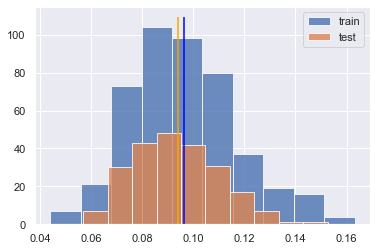

In [1173]:
train_interp = np.sum((bstr.predict_at_times(X_tr, bins=bins_HO, mode="surv") - 0.5)**2, axis=1)/pred_surv.shape[1]
test_interp = np.sum((pred_surv - 0.5)**2, axis=1)/pred_surv.shape[1]

plt.hist(train_interp, alpha=0.8, label="train")
plt.hist(test_interp, alpha=0.8, label="test")

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines([train_interp.mean()], ymin=0, ymax=ymax, color="blue")
plt.vlines([test_interp.mean()], ymin=0, ymax=ymax, color="orange")

plt.legend()

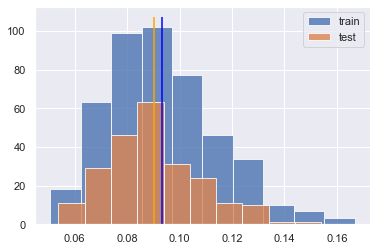

In [1004]:
train_interp = np.sum((bstr.predict_at_times(X_tr, bins=bins_HO, mode="surv") - 0.5)**2, axis=1)/pred_surv.shape[1]
test_interp = np.sum((pred_surv - 0.5)**2, axis=1)/pred_surv.shape[1]

plt.hist(train_interp, alpha=0.8, label="train")
plt.hist(test_interp, alpha=0.8, label="test")

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines([train_interp.mean()], ymin=0, ymax=ymax, color="blue")
plt.vlines([test_interp.mean()], ymin=0, ymax=ymax, color="orange")

plt.legend()

In [ ]:
[0.76360521 0.07304893 0.13299682 0.86558123 0.75005898 0.52793664
 0.73659702]

In [ ]:
[0.76387937 0.07364383 0.13161974 0.88202971 0.74879034 0.52826713
 0.73542529]

In [ ]:
[0.62474106 0.14258534 0.35411988 0.76309402 0.6937536  0.51879583
 0.67393416]

In [ ]:
[0.6246238  0.1413695  0.35526522 0.76653645 0.69048486 0.51676118
 0.67080522]

[0.62481923 0.14399089 0.33614265 0.76982147 0.68980032 0.50977725
 0.66940708]

In [ ]:
[0.74571624 0.07691478 0.13562212 0.85031324 0.74644416 0.51884859
 0.73265049]

In [ ]:
[0.75044551 0.07422903 0.13891308 0.86350385 0.74744301 0.5258475
 0.73401298]

In [1034]:
bstr.models[0].visualize(mode="surv")

In [ ]:
[0.75798492 0.07584531 0.15275895 0.84609398 0.74428908 0.52513036
 0.73100674]

In [ ]:
[0.76579849 0.0736009  0.13471011 0.85407327 0.74949491 0.52675405
 0.73599546] # rank timeline

In [ ]:
[0.75867032 0.07254859 0.1335381  0.84727707 0.7503295  0.53066127
 0.73701628] # minstd rank timeline

[0.75633996 0.07495719 0.13651817 0.83066202 0.7504991  0.53075341
 0.73718118] # minstd full timeline

In [ ]:
[0.76703221 0.07399259 0.14214758 0.8703668  0.74778725 0.52820659
#  0.73447933] # diptest rank timeline

[0.75044551 0.07422903 0.13891308 0.86350385 0.74744301 0.5258475
 0.73401298] # diptest full timeline

In [ ]:
[0.61622044 0.14232877 0.36427644 0.76000316 0.68964637 0.5158604
 0.66995968]

In [ ]:
[0.76662097 0.07352715 0.1427046  0.85226585 0.74681081 0.52533867
 0.73338826]

In [ ]:
[0.76703221 0.07399259 0.14214758 0.8703668  0.74778725 0.52820659
 0.73447933]

In [ ]:
[0.76031528 0.07545675 0.13330532 0.84776847 0.74616391 0.52064969
 0.73249638]

In [ ]:
[0.75222755 0.07254517 0.14051689 0.87888129 0.74781346 0.53118041
 0.73468419]
[0.75551748 0.0749408  0.14910095 0.85885689 0.7424502  0.52176386
 0.72907527]

In [ ]:
[0.62259136 0.14198701 0.35885451 0.77255067 0.69410347 0.5194261
 0.6743158 ]
[0.62798515 0.14223849 0.34295473 0.76877587 0.6948715  0.51542966
 0.67454411]

In [ ]:
[0.75551748 0.0749408  0.14910095 0.85885689 0.7424502  0.52176386
 0.72907527]

In [ ]:
[0.62778972 0.14300061 0.33354884 0.77477676 0.69121148 0.50949231
 0.6706261 ]

In [ ]:
[0.6281024  0.14091349 0.34395037 0.77027241 0.69435691 0.52027288
 0.67463645]

In [ ]:
[0.62614813 0.14374146 0.34480665 0.75541951 0.69278564 0.51871816
 0.67306706]

In [ ]:
[0.63091655 0.1422004  0.34096467 0.76252518 0.69420142 0.52163777
 0.67465319]

In [ ]:
[0.63162009 0.14071645 0.34137235 0.76280546 0.69149669 0.51923545
 0.67198272]

Text(0, 0.5, 'Mean leaf time')

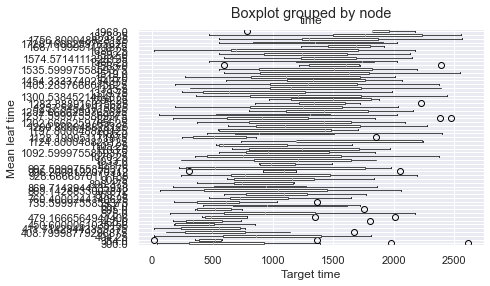

In [134]:
ind = 0
pred_0_numb = bstr.models[ind].predict(X_tr, target="numb")
pred_0_time = bstr.models[ind].predict(X_tr, target="time")

a = np.bincount(pred_0_numb.astype(int), weights=pred_0_time) / np.bincount(pred_0_numb.astype(int))

dd_ = pd.DataFrame()
dd_["time"] = y_tr["time"]
dd_["node"] = pred_0_time
ax = dd_.boxplot(column='time', by='node', vert=False)
# ax.set_yticks(np.unique(pred_0_numb[~pd.isna(pred_0_numb)]))

# plt.scatter(y_tr["time"], pred_0_time, c=pred_0_numb)
# plt.hlines(y=[a], xmin=y_tr["time"].min(), xmax=y_tr["time"].max(), alpha=0.3)
plt.xlabel("Target time")
plt.ylabel("Mean leaf time")

In [322]:
np.unique(pred_0_numb)

array([ 4.,  8., 10., 12., 14., 15., 20., 28., 30., 32., 33., 34., 35.,
       36., 37., 38., 39., 40., 41., 42., 43., 46., 47., 48., 52., 53.,
       55., 56., 57., 58.])

corr: -0.11191754874046404
p-value: 0.2337257810820236


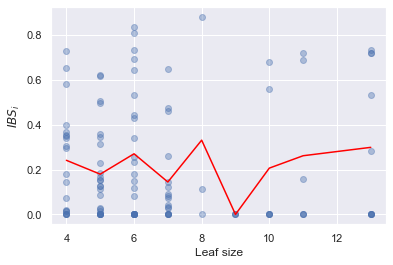

In [135]:
from scipy.stats import spearmanr

X_ = X_HO.reset_index(drop=True)

ind = 0
X_sub = X_.loc[X_.index.difference(bstr.oob_index[ind]), :]
y_sub = y_tr[X_.index.difference(bstr.oob_index[ind])]

pred_0_time = bstr.models[ind].predict(X_sub, target="time")
pred_0_size = bstr.models[ind].predict(X_sub, target="size")
pred_0_surv = bstr.models[ind].predict_at_times(X_sub, bins=bins_HO, mode="surv")

ibss = metr.ibs_WW(y_tr, y_sub, pred_0_surv, bins_HO, axis=0)
a = np.bincount(pred_0_size.astype(int), weights=ibss) / np.bincount(pred_0_size.astype(int))

plt.scatter(pred_0_size, ibss, alpha=0.4)
plt.plot(np.unique(pred_0_size), a[~np.isnan(a)], color="red")
plt.xlabel("Leaf size")
plt.ylabel(r"$IBS_i$")

rho, p = spearmanr(ibss[pred_0_size < 30], pred_0_size[pred_0_size < 30])
print("corr:", rho)
print("p-value:", p)

In [417]:
1/y_tr.shape[0]

0.00398406374501992

In [72]:
tree = CRAID1(features=features, l_reg=0.9, criterion="logrank", depth=15, min_samples_leaf=0.01, signif=0.01)
tree.fit(X_tr, y_tr)

pred_time = tree.predict(X_HO, target="time")
pred_surv = tree.predict_at_times(X_HO, bins=bins_HO, mode="surv")
# pred_surv[:, -1] = 0
# pred_surv[:, 0] = 1
    
pred_haz = tree.predict_at_times(X_HO, bins=bins_HO, mode="hazard")
print(count_metric(y_tr, y_HO, pred_time,
                   pred_surv, pred_haz, bins_HO, 
                   ['CI', "IBS_REMAIN", "BAL_IBS_REMAIN", "IAUC_WW_TI", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

[0.61252687 0.17566352 0.34249126 0.70510453 0.61882953 0.33525325
 0.58670566]


In [ ]:
[0.61252687 0.17563    0.34259632 0.70510453 0.68627588 0.48949298
 0.66398407]

In [ ]:
[0.60541333 0.18513587 0.34071538 0.71180638 0.62693293 0.33500373
 0.59386283]

In [ ]:
[0.6040258  0.20169796 0.35450373 0.7003046  0.60849561 0.28825217
 0.57221803]

In [204]:
from survivors.ensemble import BootstrapCRAID, IBSCleverBoostingCRAID
param_bstr = {'aggreg_func': 'mean', 'all_weight': True, 'balance': None, 
              'categ': categ, "l_reg": 0.0005,
              'criterion': 'peto', 'depth': 10, 'ens_metric_name': 'IBS_REMAIN', 
              'leaf_model': 'base_zero_after', 'max_features': 0.3, 'min_samples_leaf': 0.01, # 0.01 
              'n_estimators': 50, 'n_jobs': 5, 'size_sample': 0.7, 'weighted_tree': False}

bstr = IBSCleverBoostingCRAID1(**param_bstr)
bstr.fit(X_tr, y_tr)
bstr.tolerance_find_best(param_bstr["ens_metric_name"])
pred_time = bstr.predict(X_HO, target="time")
pred_surv = bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv")
pred_haz = bstr.predict_at_times(X_HO, bins=bins_HO, mode="hazard")

print(count_metric(y_tr, y_HO, pred_time,
                   pred_surv, pred_haz, bins_HO, 
                   ['CI', "IBS_REMAIN", "BAL_IBS_REMAIN", "IAUC_WW_TI", "AUPRC", "EVENT_AUPRC", "BAL_AUPRC"]))

UNIQUE (0):231, DIST: [189 132]
[1 3 3 4 2 4 3 5 2 2 4 3 4 2 4 3 5 2 2 4 5 1 3 3 3 5 2 3 3 3 5 3 3 2 3 4 4
 2 5 2 3 5 2 2 3 5 2 3 3 3 5 3 2 3 4 5 1 4 2 3 5 3 2 3 3 4 3 3 4 2 4 3 3 3
 4 3 4 3 3 2 4 4 3 4 2 3 3 3 3 3 6 1 4 2 3 4 4 2 3 3 4] [1 3 3 4 2 4 3 5 2 2 4 3 4 2 4 3 5 2 2 4 5 1 3 3 3 5 2 3 3 3 5 3 3 2 3 4 4
 2 5 2 3 5 2 2 3 5 2 3 3 3 5 3 2 3 4 5 1 4 2 3 5 3 2 3 3 4 3 3 4 2 4 3 3 3
 4 3 4 3 3 2 4 4 3 4 2 3 3 3 3 3 6 1 4 2 3 4 4 2 3 3 4]
[1 3 3 4 2 4 3 5 2 2 4 3 4 2 4 3 5 2 2 4 5 1 3 3 3 5 2 3 3 3 5 3 3 2 3 4 4
 2 5 2 3 5 2 2 3 5 2 3 3 3 5 3 2 3 4 5 1 4 2 3 5 3 2 3 3 4 3 3 4 2 4 3 3 3
 4 3 4 3 3 2 4 4 3 4 2 3 3 3 3 3 6 1 4 2 3 4 4 2 3 3 4] [1 3 3 4 2 4 3 5 2 2 4 3 4 2 4 3 5 2 2 4 5 1 3 3 3 5 2 3 3 3 5 3 3 2 3 4 4
 2 5 2 3 5 2 2 3 5 2 3 3 3 5 3 2 3 4 5 1 4 2 3 5 3 2 3 3 4 3 3 4 2 4 3 3 3
 4 3 4 3 3 2 4 4 3 4 2 3 3 3 3 3 6 1 4 2 3 4 4 2 3 3 4]
[1 3 3 4 2 4 3 5 2 2 4 3 4 2 4 3 5 2 2 4 5 1 3 3 3 5 2 3 3 3 5 3 3 2 3 4 4
 2 5 2 3 5 2 2 3 5 2 3 3 3 5 3 2 3 4 5 1 4 2 3 5 3 2 3 3 4 3 3 4 2 4 

[20 20 11 27 11 16 22 43  4  6  6 68 31 36] [1 2 2 2 3 1 2 2 3 1 2 2 2 0]
[  1  15  12  21   5  15  13 131 108] [1 2 1 2 3 1 2 2 0]
[  1  15  12  21   5  15  13 131 108] [1 2 1 2 3 1 2 2 0]
[  1  15  12  21   5  15  13 131 108] [1 2 1 2 3 1 2 2 0]
[95 14  3 63 24  6 16 43 17  3 21 16] [1 1 3 1 2 2 2 3 2 1 2 0]
[95 14  3 63 24  6 16 43 17  3 21 16] [1 1 3 1 2 2 2 3 2 1 2 0]
[95 14  3 63 24  6 16 43 17  3 21 16] [1 1 3 1 2 2 2 3 2 1 2 0]
[68 58  3  5  0 20 30  8 17  3  9  7  1  2  9  3 25  0 23  0 18  3  6  3] [1 3 2 3 0 2 3 1 2 3 1 3 1 2 2 2 4 0 4 0 3 1 2 0]
[68 58  3  5  0 20 30  8 17  3  9  7  1  2  9  3 25  0 23  0 18  3  6  3] [1 3 2 3 0 2 3 1 2 3 1 3 1 2 2 2 4 0 4 0 3 1 2 0]
[68 58  3  5  0 20 30  8 17  3  9  7  1  2  9  3 25  0 23  0 18  3  6  3] [1 3 2 3 0 2 3 1 2 3 1 3 1 2 2 2 4 0 4 0 3 1 2 0]
[ 4 58 28 37 12  2  9 40 64 50 15  2] [2 0 2 2 2 2 2 2 2 3 1 0]
[ 4 58 28 37 12  2  9 40 64 50 15  2] [2 0 2 2 2 2 2 2 2 3 1 0]
[ 4 58 28 37 12  2  9 40 64 50 15  2] [2 0 2 2 2 2 2 2 2 3 1

[ 5  7  2  2  3  1  2 12  6  2  8  8 11 16  4  5  6 18  5  6  3 17 10  6
  4 18 20  6 14 12  5  2  5 39 31] [1 2 2 2 3 1 2 3 1 2 3 1 2 2 2 2 2 2 2 3 1 2 2 2 2 3 1 2 2 2 2 2 2 2 0]
[ 5  7  2  2  3  1  2 12  6  2  8  8 11 16  4  5  6 18  5  6  3 17 10  6
  4 18 20  6 14 12  5  2  5 39 31] [1 2 2 2 3 1 2 3 1 2 3 1 2 2 2 2 2 2 2 3 1 2 2 2 2 3 1 2 2 2 2 2 2 2 0]
[ 5  7  2  2  3  1  2 12  6  2  8  8 11 16  4  5  6 18  5  6  3 17 10  6
  4 18 20  6 14 12  5  2  5 39 31] [1 2 2 2 3 1 2 3 1 2 3 1 2 2 2 2 2 2 2 3 1 2 2 2 2 3 1 2 2 2 2 2 2 2 0]
[48  7 35 13 12 20  9 20  8 17  4  8  0 11  4  6  2  1  8  6 18  7  6  3
 11  5 14  2  9  7] [1 2 2 2 2 2 2 2 2 3 1 4 0 2 2 3 2 1 2 3 1 2 2 2 3 1 2 2 2 0]
[48  7 35 13 12 20  9 20  8 17  4  8  0 11  4  6  2  1  8  6 18  7  6  3
 11  5 14  2  9  7] [1 2 2 2 2 2 2 2 2 3 1 4 0 2 2 3 2 1 2 3 1 2 2 2 3 1 2 2 2 0]
[48  7 35 13 12 20  9 20  8 17  4  8  0 11  4  6  2  1  8  6 18  7  6  3
 11  5 14  2  9  7] [1 2 2 2 2 2 2 2 2 3 1 4 0 2 2 3 2 1 2 3 1 2 2 2 3 1 2 2 

[ 3  0  7 15  0  5  2  5  2  6 17  2  7  5  4  0  4  4  7  6  6  2  1  4
  5  5  5  2  4  3  3  2  5  8  5  2 11  3  0  2  4  9  4  0  6  3  9 21
  6  6  3  3  2  7  9  4  4  2  4 11  2  2  2  5  5  7  2] [3 0 2 4 0 2 2 3 2 1 3 1 2 3 3 0 2 2 2 2 3 2 1 2 2 2 2 2 2 3 1 2 2 2 3 1 3
 3 0 2 2 3 3 0 2 2 2 2 2 2 2 2 2 2 2 2 3 2 1 3 2 1 2 2 2 2 2]
[  8  39  10  23 241] [2 2 1 2 0]
[  8  39  10  23 241] [2 2 1 2 0]
[  8  39  10  23 241] [2 2 1 2 0]
[ 82   5  11 104  17   0 102] [2 0 3 1 4 0 0]
[ 82   5  11 104  17   0 102] [2 0 3 1 4 0 0]
[ 82   5  11 104  17   0 102] [2 0 3 1 4 0 0]
[12 62 20 24 89 20 17  1 45 31] [1 2 2 2 2 3 2 1 2 0]
[12 62 20 24 89 20 17  1 45 31] [1 2 2 2 2 3 2 1 2 0]
[12 62 20 24 89 20 17  1 45 31] [1 2 2 2 2 3 2 1 2 0]
[40 96 51 43 21 70] [1 1 2 2 2 0]
[40 96 51 43 21 70] [1 1 2 2 2 0]
[40 96 51 43 21 70] [1 1 2 2 2 0]
[ 14  58  57   3 130  59] [2 0 4 0 2 0]
[ 14  58  57   3 130  59] [2 0 4 0 2 0]
[ 14  58  57   3 130  59] [2 0 4 0 2 0]
[ 3  0  7 15  3  4  3  4  6 17  2 

[ 4  2 17  9 13  4 10  0 10  7 15  0  5  3 14  0  9 10 78  3 33 15 10  7
  9 34] [1 2 2 3 2 1 4 0 2 3 3 0 2 2 4 0 3 1 2 2 3 1 2 2 2 0]
[ 4  2 17  9 13  4 10  0 10  7 15  0  5  3 14  0  9 10 78  3 33 15 10  7
  9 34] [1 2 2 3 2 1 4 0 2 3 3 0 2 2 4 0 3 1 2 2 3 1 2 2 2 0]
[ 4  2 17  9 13  4 10  0 10  7 15  0  5  3 14  0  9 10 78  3 33 15 10  7
  9 34] [1 2 2 3 2 1 4 0 2 3 3 0 2 2 4 0 3 1 2 2 3 1 2 2 2 0]
[18 37 70 23 44 36 62 22  9] [1 2 2 2 2 2 2 2 0]
[18 37 70 23 44 36 62 22  9] [1 2 2 2 2 2 2 2 0]
[18 37 70 23 44 36 62 22  9] [1 2 2 2 2 2 2 2 0]
[ 9 58 19  5  6  6  0 10  9  3  7  3  8  5 12  6  2  9  5  8  2  2  8 17
  4  7  4 10  4  8  3  0  7  8  4  4  3  8 15  0  1  9  2  1] [2 0 2 2 2 4 0 2 2 2 2 3 1 2 2 2 2 2 3 2 1 2 2 2 2 3 1 2 2 3 3 0 3 1 2 2 3
 1 6 0 0 2 2 0]
[ 9 58 19  5  6  6  0 10  9  3  7  3  8  5 12  6  2  9  5  8  2  2  8 17
  4  7  4 10  4  8  3  0  7  8  4  4  3  8 15  0  1  9  2  1] [2 0 2 2 2 4 0 2 2 2 2 3 1 2 2 2 2 2 3 2 1 2 2 2 2 3 1 2 2 3 3 0 3 1 2 2 3
 1 6 0 0 2 2

[28 63 82 61 60 27] [1 2 2 2 2 0]
[28 63 82 61 60 27] [1 2 2 2 2 0]
[28 63 82 61 60 27] [1 2 2 2 2 0]
[37 19 27  6  6  6 18 14 15  6  2 12 18  3 23 22  7  1 11  4  7  2 10  7
  9  7 22] [1 1 2 2 2 4 0 2 3 1 2 2 3 3 0 3 3 0 3 1 4 0 2 2 2 2 2]
[37 19 27  6  6  6 18 14 15  6  2 12 18  3 23 22  7  1 11  4  7  2 10  7
  9  7 22] [1 1 2 2 2 4 0 2 3 1 2 2 3 3 0 3 3 0 3 1 4 0 2 2 2 2 2]
[37 19 27  6  6  6 18 14 15  6  2 12 18  3 23 22  7  1 11  4  7  2 10  7
  9  7 22] [1 1 2 2 2 4 0 2 3 1 2 2 3 3 0 3 3 0 3 1 4 0 2 2 2 2 2]
[78  0 36 48 46 62 41  0 10] [3 0 1 2 3 1 4 0 0]
[78  0 36 48 46 62 41  0 10] [3 0 1 2 3 1 4 0 0]
[78  0 36 48 46 62 41  0 10] [3 0 1 2 3 1 4 0 0]
[ 49  26  47 156  43] [2 1 2 2 0]
[ 49  26  47 156  43] [2 1 2 2 0]
[ 49  26  47 156  43] [2 1 2 2 0]
[ 22 101  33   9   7  14  39  34   9  44   9] [1 1 2 3 1 2 3 2 1 2 0]
[ 22 101  33   9   7  14  39  34   9  44   9] [1 1 2 3 1 2 3 2 1 2 0]
[ 22 101  33   9   7  14  39  34   9  44   9] [1 1 2 3 1 2 3 2 1 2 0]
[40 74 21 13 25  5 

[ 8 19  7  3  8  5 14  1  5  7  0 11  5  7  6  6 19 26 10  3 20  3  6 18
 10 17  5  9  6  0 18  0 15 24] [1 1 2 2 3 1 4 0 2 5 0 1 2 3 1 2 2 2 2 2 2 3 2 1 2 2 2 3 4 0 3 0 2 0]
[ 8 19  7  3  8  5 14  1  5  7  0 11  5  7  6  6 19 26 10  3 20  3  6 18
 10 17  5  9  6  0 18  0 15 24] [1 1 2 2 3 1 4 0 2 5 0 1 2 3 1 2 2 2 2 2 2 3 2 1 2 2 2 3 4 0 3 0 2 0]
[ 8 19  7  3  8  5 14  1  5  7  0 11  5  7  6  6 19 26 10  3 20  3  6 18
 10 17  5  9  6  0 18  0 15 24] [1 1 2 2 3 1 4 0 2 5 0 1 2 3 1 2 2 2 2 2 2 3 2 1 2 2 2 3 4 0 3 0 2 0]
[41 89 37 28 16 74 36] [1 3 1 2 2 2 0]
[41 89 37 28 16 74 36] [1 3 1 2 2 2 0]
[41 89 37 28 16 74 36] [1 3 1 2 2 2 0]
[  7  12   2  32  47  10  45 128  38] [1 2 2 1 4 0 2 2 0]
[  7  12   2  32  47  10  45 128  38] [1 2 2 1 4 0 2 2 0]
[  7  12   2  32  47  10  45 128  38] [1 2 2 1 4 0 2 2 0]
[ 1  2 16  0  8  5  2 15  4  5 14  8  6  5  0 13  1  9  1  5  2  2  2  7
  5  2 10  0  2  3  2  4  1 15  4  7  9  4  5  2  8  5  1  2  5  5  2  4
  2  3  8 13  4  1  5  2  6  8  2  2  

[81 59 10  0 80 12 42 10 27] [1 3 3 0 2 3 1 2 0]
[81 59 10  0 80 12 42 10 27] [1 3 3 0 2 3 1 2 0]
[81 59 10  0 80 12 42 10 27] [1 3 3 0 2 3 1 2 0]
[49 30 76 74 92] [2 0 2 2 0]
[49 30 76 74 92] [2 0 2 2 0]
[49 30 76 74 92] [2 0 2 2 0]
[32  2 92 55 62 58 17  3] [1 2 2 3 1 2 2 0]
[32  2 92 55 62 58 17  3] [1 2 2 3 1 2 2 0]
[32  2 92 55 62 58 17  3] [1 2 2 3 1 2 2 0]
[ 53  16  17  56  59 120] [2 0 3 1 2 0]
[ 53  16  17  56  59 120] [2 0 3 1 2 0]
[ 53  16  17  56  59 120] [2 0 3 1 2 0]
[30 29 53 20 53  1 28 37  9 30  0 14 17] [2 1 2 2 3 1 2 3 1 4 0 2 0]
[30 29 53 20 53  1 28 37  9 30  0 14 17] [2 1 2 2 3 1 2 3 1 4 0 2 0]
[30 29 53 20 53  1 28 37  9 30  0 14 17] [2 1 2 2 3 1 2 3 1 4 0 2 0]
[ 70  95  13 108  35] [1 3 1 2 0]
[ 70  95  13 108  35] [1 3 1 2 0]
[ 70  95  13 108  35] [1 3 1 2 0]
[  8  49  20  14 138  92] [1 1 4 0 2 0]
[  8  49  20  14 138  92] [1 1 4 0 2 0]
[  8  49  20  14 138  92] [1 1 4 0 2 0]
[36  7  6 33 29 88 22 33 67] [2 0 2 2 2 3 1 2 0]
[36  7  6 33 29 88 22 33 67] [2 0 2 

[ 25  11  46  61 115  63] [2 1 2 2 2 0]
[ 25  11  46  61 115  63] [2 1 2 2 2 0]
[ 25  11  46  61 115  63] [2 1 2 2 2 0]
[ 14  25  52  28 189  13] [1 2 2 2 2 0]
[ 14  25  52  28 189  13] [1 2 2 2 2 0]
[ 14  25  52  28 189  13] [1 2 2 2 2 0]
[ 26  10  11   0   9 146 119] [1 3 3 0 2 2 0]
[ 26  10  11   0   9 146 119] [1 3 3 0 2 2 0]
[ 26  10  11   0   9 146 119] [1 3 3 0 2 2 0]
[  3 197  18  47  14  42] [1 2 2 2 2 0]
[  3 197  18  47  14  42] [1 2 2 2 2 0]
[  3 197  18  47  14  42] [1 2 2 2 2 0]
[48 37  2  2 32 21 19 84 49 16 11] [1 3 2 1 2 2 2 3 2 1 0]
[48 37  2  2 32 21 19 84 49 16 11] [1 3 2 1 2 2 2 3 2 1 0]
[48 37  2  2 32 21 19 84 49 16 11] [1 3 2 1 2 2 2 3 2 1 0]
[131  36  20 101  33] [1 3 0 2 0]
[131  36  20 101  33] [1 3 0 2 0]
[131  36  20 101  33] [1 3 0 2 0]
[ 17   0  50   8 246] [3 0 2 1 0]
[ 17   0  50   8 246] [3 0 2 1 0]
[ 17   0  50   8 246] [3 0 2 1 0]
[ 29  47  28  56 161] [1 1 2 2 0]
[ 29  47  28  56 161] [1 1 2 2 0]
[ 29  47  28  56 161] [1 1 2 2 0]
[101  38   6   9  1

[13 21  8  9 18  3 15 14 18  7 19 11 21  8 27 34  5  2 23 44  1] [1 1 3 1 4 0 3 2 1 3 1 2 2 2 2 3 3 0 2 2 0]
[13 21  8  9 18  3 15 14 18  7 19 11 21  8 27 34  5  2 23 44  1] [1 1 3 1 4 0 3 2 1 3 1 2 2 2 2 3 3 0 2 2 0]
[13 21  8  9 18  3 15 14 18  7 19 11 21  8 27 34  5  2 23 44  1] [1 1 3 1 4 0 3 2 1 3 1 2 2 2 2 3 3 0 2 2 0]
[ 5 16 10 13  3  2  6  5  5  4 10  0  4  0  4  6  4  7  7  8  8  3  2  3
  2  2  4  2  4  3  2  3  4  4  4 11  3  1  2  3  1  2  3  3  3  3  5  0
  4  4  0  4  0  3  2  3  2  4  3  0  3  1  4  6  3  3  3  3  5  2  5  4
  4  3  0  3  2  2  4  1  2  2  2  6  0  0  3  4  0  3] [1 1 2 2 2 2 3 1 3 1 4 0 4 0 2 3 2 2 1 2 2 2 2 2 2 2 4 0 2 3 1 2 2 3 1 2 3
 1 2 3 1 2 3 1 2 2 5 0 1 4 0 4 0 2 2 2 2 3 3 0 3 1 2 2 2 3 2 1 3 2 1 2 3 3
 0 3 1 2 3 1 2 2 2 6 0 0 3 4 0 1]
[ 5 16 10 13  3  2  6  5  5  4 10  0  4  0  4  6  4  7  7  8  8  3  2  3
  2  2  4  2  4  3  2  3  4  4  4 11  3  1  2  3  1  2  3  3  3  3  5  0
  4  4  0  4  0  3  2  3  2  4  3  0  3  1  4  6  3  3  3  3  5  2  

[32 14  4  5 11 17  0  2 19 26  2  7  4  0 22  2 17  5  3 32  2  5  7  4
 23  4 18 15  3 16] [1 3 1 2 2 4 0 2 2 3 1 2 4 0 3 1 2 2 2 2 2 2 3 1 2 2 2 2 2 0]
[32 14  4  5 11 17  0  2 19 26  2  7  4  0 22  2 17  5  3 32  2  5  7  4
 23  4 18 15  3 16] [1 3 1 2 2 4 0 2 2 3 1 2 4 0 3 1 2 2 2 2 2 2 3 1 2 2 2 2 2 0]
[32 14  4  5 11 17  0  2 19 26  2  7  4  0 22  2 17  5  3 32  2  5  7  4
 23  4 18 15  3 16] [1 3 1 2 2 4 0 2 2 3 1 2 4 0 3 1 2 2 2 2 2 2 3 1 2 2 2 2 2 0]
[ 4 45 77 73 70 52] [1 1 2 2 2 0]
[ 4 45 77 73 70 52] [1 1 2 2 2 0]
[ 4 45 77 73 70 52] [1 1 2 2 2 0]
[ 17   2  10  23 269] [1 2 1 2 0]
[ 17   2  10  23 269] [1 2 1 2 0]
[ 17   2  10  23 269] [1 2 1 2 0]
[ 1 38  0 33  4 23 71  6 98 47] [1 5 0 2 2 1 2 2 2 0]
[ 1 38  0 33  4 23 71  6 98 47] [1 5 0 2 2 1 2 2 2 0]
[ 1 38  0 33  4 23 71  6 98 47] [1 5 0 2 2 1 2 2 2 0]
[  3   1   3  18   4  27  14  37 175  39] [2 0 2 2 3 1 2 2 2 0]
[  3   1   3  18   4  27  14  37 175  39] [2 0 2 2 3 1 2 2 2 0]
[  3   1   3  18   4  27  14  37 175  39]

[15 24 10  9 10  1  4  5  2  4 10  7  7 10  5  4  9  5  3  7  2  2  4  2
  6  3  2 16 18  4 14  6  3  0  5  3  5  2  3  4  4  8  3  2  6  2  6 10
  7  2  4  0  2  3  2  3  2] [1 2 2 1 3 1 3 3 0 2 3 2 1 2 2 3 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 0 2 2 2
 2 2 3 1 3 2 2 1 2 2 2 3 2 3 0 2 2 2 2 0]
[15 24 10  9 10  1  4  5  2  4 10  7  7 10  5  4  9  5  3  7  2  2  4  2
  6  3  2 16 18  4 14  6  3  0  5  3  5  2  3  4  4  8  3  2  6  2  6 10
  7  2  4  0  2  3  2  3  2] [1 2 2 1 3 1 3 3 0 2 3 2 1 2 2 3 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 0 2 2 2
 2 2 3 1 3 2 2 1 2 2 2 3 2 3 0 2 2 2 2 0]
[ 1  3  6  7  3  2  8 17 12 10 16  6  0  3  4  7  5  5  8  9 20 11 14  8
  2  6  4  4  6  7  3  2  5  4  8  7  1 15 19  6  1  4  2  6 15  8  1] [1 1 2 2 3 1 2 2 2 2 2 6 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 3 1 3 2 2 2 1 2 3 1
 2 2 3 1 2 2 2 2 2 0]
[ 1  3  6  7  3  2  8 17 12 10 16  6  0  3  4  7  5  5  8  9 20 11 14  8
  2  6  4  4  6  7  3  2  5  4  8  7  1 15 19  6  1  4  2  6 15  8  1] [1 1 2 2 3 1 2 2 2 2 2 6 0 0 2 

[123  57  26 115] [1 3 0 2]
[123  57  26 115] [1 3 0 2]
[123  57  26 115] [1 3 0 2]
[ 53  55  31   0 182] [2 2 3 0 0]
[ 53  55  31   0 182] [2 2 3 0 0]
[ 53  55  31   0 182] [2 2 3 0 0]
[68  1  4  5  0 28 44 11 23 88 42  7] [2 0 3 3 0 2 2 3 1 3 1 0]
[68  1  4  5  0 28 44 11 23 88 42  7] [2 0 3 3 0 2 2 3 1 3 1 0]
[68  1  4  5  0 28 44 11 23 88 42  7] [2 0 3 3 0 2 2 3 1 3 1 0]
[59 23 12  7 11 15  9  5 10 19 58 27  0 21 29 11  5] [1 1 3 2 1 4 0 2 2 2 2 4 0 2 3 1 0]
[59 23 12  7 11 15  9  5 10 19 58 27  0 21 29 11  5] [1 1 3 2 1 4 0 2 2 2 2 4 0 2 3 1 0]
[59 23 12  7 11 15  9  5 10 19 58 27  0 21 29 11  5] [1 1 3 2 1 4 0 2 2 2 2 4 0 2 3 1 0]
[ 15 138  80   1  16  30  29   0  12] [1 2 3 1 2 2 4 0 0]
[ 15 138  80   1  16  30  29   0  12] [1 2 3 1 2 2 4 0 0]
[ 15 138  80   1  16  30  29   0  12] [1 2 3 1 2 2 4 0 0]
[163   6  88  38  26] [1 2 1 2 0]
[163   6  88  38  26] [1 2 1 2 0]
[163   6  88  38  26] [1 2 1 2 0]
[ 3 32 56  7 85 24 21 47  9  0 37] [1 2 3 1 2 2 2 2 4 0 0]
[ 3 32 56  7 85 24 2

[ 21  59  45   0 196] [1 2 4 0 0]
[ 21  59  45   0 196] [1 2 4 0 0]
[ 21  59  45   0 196] [1 2 4 0 0]
[ 22  21  21   5 252] [1 1 2 2 0]
[ 22  21  21   5 252] [1 1 2 2 0]
[ 22  21  21   5 252] [1 1 2 2 0]
[ 7 28 78 36 33  1 35  0 10  6 18  3 11  0 11 20 15  6  3] [1 3 2 1 3 1 4 0 2 2 2 3 3 0 2 3 1 2 0]
[ 7 28 78 36 33  1 35  0 10  6 18  3 11  0 11 20 15  6  3] [1 3 2 1 3 1 4 0 2 2 2 3 3 0 2 3 1 2 0]
[ 7 28 78 36 33  1 35  0 10  6 18  3 11  0 11 20 15  6  3] [1 3 2 1 3 1 4 0 2 2 2 3 3 0 2 3 1 2 0]
[100  37  90  45  49] [1 2 2 2 0]
[100  37  90  45  49] [1 2 2 2 0]
[100  37  90  45  49] [1 2 2 2 0]
[10 62 32  6 20 15 22 28  3  3  2  2  3 10 11 17 12 10  8 10  0 11  7  9
  8] [1 1 2 2 2 2 3 1 3 2 2 1 2 2 2 2 2 2 2 4 0 2 2 2 0]
[10 62 32  6 20 15 22 28  3  3  2  2  3 10 11 17 12 10  8 10  0 11  7  9
  8] [1 1 2 2 2 2 3 1 3 2 2 1 2 2 2 2 2 2 2 4 0 2 2 2 0]
[10 62 32  6 20 15 22 28  3  3  2  2  3 10 11 17 12 10  8 10  0 11  7  9
  8] [1 1 2 2 2 2 3 1 3 2 2 1 2 2 2 2 2 2 2 4 0 2 2 2 0]
[ 2  1 

[51 23  9  8 35 18 14 14 13 38  6 14 17 22  8 18 13] [1 3 1 2 2 2 2 2 2 2 2 2 2 3 2 1 0]
[51 23  9  8 35 18 14 14 13 38  6 14 17 22  8 18 13] [1 3 1 2 2 2 2 2 2 2 2 2 2 3 2 1 0]
[51 23  9  8 35 18 14 14 13 38  6 14 17 22  8 18 13] [1 3 1 2 2 2 2 2 2 2 2 2 2 3 2 1 0]
[ 7  3 13  6  0  4 11  3  2  7  2  6  5  8 11 28 30 58 72  0  2 43] [2 0 2 6 0 0 2 2 2 3 1 2 3 1 2 2 2 2 4 0 2 0]
[ 7  3 13  6  0  4 11  3  2  7  2  6  5  8 11 28 30 58 72  0  2 43] [2 0 2 6 0 0 2 2 2 3 1 2 3 1 2 2 2 2 4 0 2 0]
[ 7  3 13  6  0  4 11  3  2  7  2  6  5  8 11 28 30 58 72  0  2 43] [2 0 2 6 0 0 2 2 2 3 1 2 3 1 2 2 2 2 4 0 2 0]
[ 5  2  4  7  2 12 12  0 19  6 10  9  3  7  3  2  4  0  4  2  2  6  3  3
  3  5  1  2  2  3  4  4  2  2  4  2  6  3  1  3  3  3  2  3  2  2  2  3
  1 12  2  2  3  2  3  4  3  2  3  4  1  2  2  7  2  1  4  4  4  7  0  2
  2  7  6  0  6  2  2  2  6  0  0  2  3  4  0  2  3  1  2] [2 0 2 4 0 2 5 0 1 2 2 3 1 2 2 2 4 0 3 1 2 2 2 2 2 4 0 2 2 3 1 2 2 2 2 2 2
 3 1 2 2 3 1 2 2 2 2 3 1 2 2 2 2 2 3 1

[ 66  14  23  18 129  71] [2 0 2 2 2 0]
[ 66  14  23  18 129  71] [2 0 2 2 2 0]
[ 66  14  23  18 129  71] [2 0 2 2 2 0]
[13  5 15 11  0 26 10 12  9  2  4  0  4 17  3  4  2  3  3  0  6  4  2  6
  2  7  4  8  2  3  7  0  2 13  5  3  2 11  5  3  2  7  4 21 14  0 10  8
  0  1  8  0  6  2] [1 3 1 4 0 2 2 2 3 1 4 0 3 1 2 3 1 3 3 0 2 2 2 3 1 2 2 2 2 2 4 0 2 2 2 2 2
 2 2 2 2 3 1 2 4 0 2 5 0 1 5 0 1 0]
[13  5 15 11  0 26 10 12  9  2  4  0  4 17  3  4  2  3  3  0  6  4  2  6
  2  7  4  8  2  3  7  0  2 13  5  3  2 11  5  3  2  7  4 21 14  0 10  8
  0  1  8  0  6  2] [1 3 1 4 0 2 2 2 3 1 4 0 3 1 2 3 1 3 3 0 2 2 2 3 1 2 2 2 2 2 4 0 2 2 2 2 2
 2 2 2 2 3 1 2 4 0 2 5 0 1 5 0 1 0]
[13  5 15 11  0 26 10 12  9  2  4  0  4 17  3  4  2  3  3  0  6  4  2  6
  2  7  4  8  2  3  7  0  2 13  5  3  2 11  5  3  2  7  4 21 14  0 10  8
  0  1  8  0  6  2] [1 3 1 4 0 2 2 2 3 1 4 0 3 1 2 3 1 3 3 0 2 2 2 3 1 2 2 2 2 2 4 0 2 2 2 2 2
 2 2 2 2 3 1 2 4 0 2 5 0 1 5 0 1 0]
[126  27 102  53  13] [1 1 2 2 0]
[126  27 102  5

[131   1  57  48  74  10] [2 1 2 2 2 0]
[131   1  57  48  74  10] [2 1 2 2 2 0]
[131   1  57  48  74  10] [2 1 2 2 2 0]
[ 1 69 11 37  2 13  8 24  0  4 22 29 25 51  7 16  2] [1 3 1 3 1 2 2 5 0 1 3 1 2 2 3 1 0]
[ 1 69 11 37  2 13  8 24  0  4 22 29 25 51  7 16  2] [1 3 1 3 1 2 2 5 0 1 3 1 2 2 3 1 0]
[ 1 69 11 37  2 13  8 24  0  4 22 29 25 51  7 16  2] [1 3 1 3 1 2 2 5 0 1 3 1 2 2 3 1 0]
[ 65   0 108  43  19   0  21  16   5  11  27   6] [3 0 2 1 4 0 2 2 2 2 2 0]
[ 65   0 108  43  19   0  21  16   5  11  27   6] [3 0 2 1 4 0 2 2 2 2 2 0]
[ 65   0 108  43  19   0  21  16   5  11  27   6] [3 0 2 1 4 0 2 2 2 2 2 0]
[ 2  2  3 11  3 13  7  9  4 13  6  8  5  4  0  4  8  9 11  2  4  9  6  2
  2 11  9  8 13  4 10  2  6  3  9  6 11  8  5  1  2  5  3  9  0  4 11  1
  2  5  9  4  6  7] [1 2 3 1 3 1 3 1 2 2 2 2 3 3 0 2 2 2 3 1 2 2 2 2 2 2 2 2 3 1 2 2 2 2 3 1 2
 2 3 1 2 3 1 5 0 1 3 1 2 2 2 2 2 2]
[ 2  2  3 11  3 13  7  9  4 13  6  8  5  4  0  4  8  9 11  2  4  9  6  2
  2 11  9  8 13  4 10  2  6  3  9  

[13 11  4 17 12 15 10  9  0 23  8  9 24  0 33 35 58 23 17] [2 1 3 1 2 2 3 4 0 2 2 1 4 0 2 2 2 2 0]
[13 11  4 17 12 15 10  9  0 23  8  9 24  0 33 35 58 23 17] [2 1 3 1 2 2 3 4 0 2 2 1 4 0 2 2 2 2 0]
[13 11  4 17 12 15 10  9  0 23  8  9 24  0 33 35 58 23 17] [2 1 3 1 2 2 3 4 0 2 2 1 4 0 2 2 2 2 0]
[  1  48  28  10 234] [1 1 2 2 0]
[  1  48  28  10 234] [1 1 2 2 0]
[  1  48  28  10 234] [1 1 2 2 0]
[ 9 44 47  7 45 16 10 14  9 22 18 22 11  6 41] [1 2 1 2 2 4 0 2 2 2 2 2 3 1 0]
[ 9 44 47  7 45 16 10 14  9 22 18 22 11  6 41] [1 2 1 2 2 4 0 2 2 2 2 2 3 1 0]
[ 9 44 47  7 45 16 10 14  9 22 18 22 11  6 41] [1 2 1 2 2 4 0 2 2 2 2 2 3 1 0]
[ 3  1  9 11 80 31  8 12  5 30 14 22  9  9  1  8 14 29  1  9  5  2  8] [2 0 2 2 2 2 3 1 3 1 4 0 2 3 1 2 2 3 1 2 3 1 2]
[ 3  1  9 11 80 31  8 12  5 30 14 22  9  9  1  8 14 29  1  9  5  2  8] [2 0 2 2 2 2 3 1 3 1 4 0 2 3 1 2 2 3 1 2 3 1 2]
[ 3  1  9 11 80 31  8 12  5 30 14 22  9  9  1  8 14 29  1  9  5  2  8] [2 0 2 2 2 2 3 1 3 1 4 0 2 3 1 2 2 3 1 2 3 1 2]
[ 4  7 

UNIQUE (12):233, DIST: [180 141]
[2 2 3 3 4 4 2 6 0 4 3 3 3 3 4 5 1 3 3 3 6 1 3 4 2 4 3 4 2 3 5 2 3 3 3 4 3
 3 3 3 5 2 3 3 5 2 3 3 3 3 4 3 3 3 3 4 3 6 0 3 4 5 3 1 3 4 3 3 3 3 5 3 2 3
 3 7 0 4 3 3 3 4 2 3 4 5 1 3 3 3 5 2 4 3 2 4 3 3 3 4 3] [2 2 3 3 4 4 2 6 0 4 3 3 3 3 4 5 1 3 3 3 6 1 3 4 2 4 3 4 2 3 5 2 3 3 3 4 3
 3 3 3 5 2 3 3 5 2 3 3 3 3 4 3 3 3 3 4 3 6 0 3 4 5 3 1 3 4 3 3 3 3 5 3 2 3
 3 7 0 4 3 3 3 4 2 3 4 5 1 3 3 3 5 2 4 3 2 4 3 3 3 4 3]
[2 2 3 3 4 4 2 6 0 4 3 3 3 3 4 5 1 3 3 3 6 1 3 4 2 4 3 4 2 3 5 2 3 3 3 4 3
 3 3 3 5 2 3 3 5 2 3 3 3 3 4 3 3 3 3 4 3 6 0 3 4 5 3 1 3 4 3 3 3 3 5 3 2 3
 3 7 0 4 3 3 3 4 2 3 4 5 1 3 3 3 5 2 4 3 2 4 3 3 3 4 3] [2 2 3 3 4 4 2 6 0 4 3 3 3 3 4 5 1 3 3 3 6 1 3 4 2 4 3 4 2 3 5 2 3 3 3 4 3
 3 3 3 5 2 3 3 5 2 3 3 3 3 4 3 3 3 3 4 3 6 0 3 4 5 3 1 3 4 3 3 3 3 5 3 2 3
 3 7 0 4 3 3 3 4 2 3 4 5 1 3 3 3 5 2 4 3 2 4 3 3 3 4 3]
[2 2 3 3 4 4 2 6 0 4 3 3 3 3 4 5 1 3 3 3 6 1 3 4 2 4 3 4 2 3 5 2 3 3 3 4 3
 3 3 3 5 2 3 3 5 2 3 3 3 3 4 3 3 3 3 4 3 6 0 3 4 5 3 1 3 4 3 3 3 3 5

[11 21 20 44 13  7 14 18 12  4 11 23 19 44 11 28  5 10  3  3] [1 2 1 2 2 2 2 2 2 3 1 2 2 3 1 2 2 2 2 0]
[11 21 20 44 13  7 14 18 12  4 11 23 19 44 11 28  5 10  3  3] [1 2 1 2 2 2 2 2 2 3 1 2 2 3 1 2 2 2 2 0]
[  4 106  27  10  60  37   0  31   7  17  22] [1 1 2 2 2 5 0 3 0 2 0]
[  4 106  27  10  60  37   0  31   7  17  22] [1 1 2 2 2 5 0 3 0 2 0]
[  4 106  27  10  60  37   0  31   7  17  22] [1 1 2 2 2 5 0 3 0 2 0]
[67 16 13 23 33  3 49 33 30 53  1] [1 1 2 2 2 2 2 2 2 2 0]
[67 16 13 23 33  3 49 33 30 53  1] [1 1 2 2 2 2 2 2 2 2 0]
[67 16 13 23 33  3 49 33 30 53  1] [1 1 2 2 2 2 2 2 2 2 0]
[82 93 57 50  3 36] [1 1 2 2 2 0]
[82 93 57 50  3 36] [1 1 2 2 2 0]
[82 93 57 50  3 36] [1 1 2 2 2 0]
[15 24  3 12  9  7  3  2 21  7  2 33  5  4  7 13  2  8  5  4  0  2 10  0
  5  4 10 12  1  6 21  2 20 12 22  8] [1 1 3 2 2 1 3 2 1 4 0 2 3 1 2 3 1 2 3 4 0 1 5 0 1 2 3 2 1 2 2 2 3 1 2 0]
[15 24  3 12  9  7  3  2 21  7  2 33  5  4  7 13  2  8  5  4  0  2 10  0
  5  4 10 12  1  6 21  2 20 12 22  8] [1 1 3 

[16 26  0 28 47 25  4 23 10  8  5  8  9  5  3 11 25  6  2  5  0  9 14  2
  7  4  2  7  5  5] [1 5 0 0 2 2 2 2 3 1 2 2 3 1 3 1 2 2 2 5 0 1 2 2 2 3 2 2 1 0]
[16 26  0 28 47 25  4 23 10  8  5  8  9  5  3 11 25  6  2  5  0  9 14  2
  7  4  2  7  5  5] [1 5 0 0 2 2 2 2 3 1 2 2 3 1 3 1 2 2 2 5 0 1 2 2 2 3 2 2 1 0]
[16 26  0 28 47 25  4 23 10  8  5  8  9  5  3 11 25  6  2  5  0  9 14  2
  7  4  2  7  5  5] [1 5 0 0 2 2 2 2 3 1 2 2 3 1 3 1 2 2 2 5 0 1 2 2 2 3 2 2 1 0]
[50  2  3  5 32 19  9 22 59 31  9 32  9  2 32  5] [1 1 3 2 1 2 3 2 1 2 2 2 3 2 1 0]
[50  2  3  5 32 19  9 22 59 31  9 32  9  2 32  5] [1 1 3 2 1 2 3 2 1 2 2 2 3 2 1 0]
[50  2  3  5 32 19  9 22 59 31  9 32  9  2 32  5] [1 1 3 2 1 2 3 2 1 2 2 2 3 2 1 0]
[ 6  0  2  4  3  4  7  5  2  3  0  7  5  4  9  7  2  4  5  3  1  4  7  2
 10  3  2  3 10  4  6  3  2 17  5  7  6  2 30  0  6  7  4  4  5  2 10  3
 23  4  5  7  2 20  0  6  7] [4 0 1 2 3 1 2 3 2 3 0 2 2 2 2 2 2 2 3 2 1 2 2 2 3 1 2 2 2 2 2 2 2 2 2 2 2
 2 4 0 3 2 2 1 3 1 2 2 2 2 3 1 2 

[19 12  5  0 13 19 19 24 17 10 81  9 93] [1 3 3 0 2 2 3 1 2 2 3 1 0]
[19 12  5  0 13 19 19 24 17 10 81  9 93] [1 3 3 0 2 2 3 1 2 2 3 1 0]
[19 12  5  0 13 19 19 24 17 10 81  9 93] [1 3 3 0 2 2 3 1 2 2 3 1 0]
[17 90 43  3 20 17  5 29  6 19 44 28] [1 2 2 2 2 2 2 2 2 2 2 0]
[17 90 43  3 20 17  5 29  6 19 44 28] [1 2 2 2 2 2 2 2 2 2 2 0]
[17 90 43  3 20 17  5 29  6 19 44 28] [1 2 2 2 2 2 2 2 2 2 2 0]
[23  2 20 55 48 53 51 47 22] [1 2 2 1 2 2 2 2 0]
[23  2 20 55 48 53 51 47 22] [1 2 2 1 2 2 2 2 0]
[23  2 20 55 48 53 51 47 22] [1 2 2 1 2 2 2 2 0]
[ 1  6  5 46  8  0 14  7 11  2 17  5  4  6  8 12  9  1  4  6  8  7  6  7
  0 21 19  1 11  2  5 17 21 12  8  2  2] [1 2 2 3 3 0 2 2 3 1 3 1 2 3 1 2 3 1 3 2 1 2 2 4 0 2 3 1 3 1 3 1 3 1 2 2 0]
[ 1  6  5 46  8  0 14  7 11  2 17  5  4  6  8 12  9  1  4  6  8  7  6  7
  0 21 19  1 11  2  5 17 21 12  8  2  2] [1 2 2 3 3 0 2 2 3 1 3 1 2 3 1 2 3 1 3 2 1 2 2 4 0 2 3 1 3 1 3 1 3 1 2 2 0]
[ 1  6  5 46  8  0 14  7 11  2 17  5  4  6  8 12  9  1  4  6  8  7  6  7
 

[ 92   7  17 102  15  24  64] [2 0 3 1 3 1 0]
[ 92   7  17 102  15  24  64] [2 0 3 1 3 1 0]
[ 92   7  17 102  15  24  64] [2 0 3 1 3 1 0]
[19 27 57  5 10 19 12 24 34  2  9  8 12  5  4  0  9  8  4 23  6  8  7  5
  4] [1 1 2 2 3 1 3 1 2 2 2 2 2 2 4 0 2 2 2 3 1 2 3 1 0]
[19 27 57  5 10 19 12 24 34  2  9  8 12  5  4  0  9  8  4 23  6  8  7  5
  4] [1 1 2 2 3 1 3 1 2 2 2 2 2 2 4 0 2 2 2 3 1 2 3 1 0]
[19 27 57  5 10 19 12 24 34  2  9  8 12  5  4  0  9  8  4 23  6  8  7  5
  4] [1 1 2 2 3 1 3 1 2 2 2 2 2 2 4 0 2 2 2 3 1 2 3 1 0]
[113  74   0 121  13] [1 4 0 2 0]
[113  74   0 121  13] [1 4 0 2 0]
[113  74   0 121  13] [1 4 0 2 0]
[ 1  2 13 10  3  8  6 20  3  7 19  2  5  6  5  3  6  3 15  6  0  3 20 11
 16 22 25 11  4  7  4  8 11 28  8] [1 2 2 1 2 2 2 2 2 2 2 2 3 2 1 2 2 2 2 4 0 2 2 2 2 2 2 2 3 2 1 3 2 1 0]
[ 1  2 13 10  3  8  6 20  3  7 19  2  5  6  5  3  6  3 15  6  0  3 20 11
 16 22 25 11  4  7  4  8 11 28  8] [1 2 2 1 2 2 2 2 2 2 2 2 3 2 1 2 2 2 2 4 0 2 2 2 2 2 2 2 3 2 1 3 2 1 0]
[ 1  2 13 

[ 32   8   5  41 235] [1 1 3 1 0]
[ 32   8   5  41 235] [1 1 3 1 0]
[ 32   8   5  41 235] [1 1 3 1 0]
[ 30  27  11   4   8 241] [2 0 3 2 1 0]
[ 30  27  11   4   8 241] [2 0 3 2 1 0]
[ 30  27  11   4   8 241] [2 0 3 2 1 0]
[51 59 25 60 45 81] [2 1 2 3 1 0]
[51 59 25 60 45 81] [2 1 2 3 1 0]
[51 59 25 60 45 81] [2 1 2 3 1 0]
[ 53 131  24  13  83  17] [1 1 2 2 2 0]
[ 53 131  24  13  83  17] [1 1 2 2 2 0]
[ 53 131  24  13  83  17] [1 1 2 2 2 0]
[ 92  11  50 106  62] [1 3 0 2 0]
[ 92  11  50 106  62] [1 3 0 2 0]
[ 92  11  50 106  62] [1 3 0 2 0]
[88 15 47 49  9 94 19] [1 1 2 2 2 2 0]
[88 15 47 49  9 94 19] [1 1 2 2 2 2 0]
[88 15 47 49  9 94 19] [1 1 2 2 2 2 0]
[190  61  52  18] [1 2 1 2]
[190  61  52  18] [1 2 1 2]
[190  61  52  18] [1 2 1 2]
[65 31 53 51 36 12 49 19  5] [1 2 1 2 4 0 2 2 0]
[65 31 53 51 36 12 49 19  5] [1 2 1 2 4 0 2 2 0]
[65 31 53 51 36 12 49 19  5] [1 2 1 2 4 0 2 2 0]
[24 30  8 32 43 28 34 28 13  3 26  6  4 42] [1 1 3 1 2 2 3 1 2 3 1 2 2 0]
[24 30  8 32 43 28 34 28 13  3 2

[25 56 34 78 39 10 24 45 10] [1 1 2 2 3 1 3 1 0]
[25 56 34 78 39 10 24 45 10] [1 1 2 2 3 1 3 1 0]
[25 56 34 78 39 10 24 45 10] [1 1 2 2 3 1 3 1 0]
[ 7  9 15  5  5 10  4  6  7  6 30  3 15 10 20 19  3  2 13 28 46  7  0 29
  0 22] [1 1 2 2 3 1 2 2 3 1 2 3 1 2 2 2 2 2 2 2 2 4 0 4 0 0]
[ 7  9 15  5  5 10  4  6  7  6 30  3 15 10 20 19  3  2 13 28 46  7  0 29
  0 22] [1 1 2 2 3 1 2 2 3 1 2 3 1 2 2 2 2 2 2 2 2 4 0 4 0 0]
[ 7  9 15  5  5 10  4  6  7  6 30  3 15 10 20 19  3  2 13 28 46  7  0 29
  0 22] [1 1 2 2 3 1 2 2 3 1 2 3 1 2 2 2 2 2 2 2 2 4 0 4 0 0]
[20 10  8 10  6  6  6 13  7  6  3  3  2  7  5  9  5  6  3  2  1  2  3  4
  5  7  2  6 14  4  2  4  2  3  4  3  8  2  2  1  3  1  3  1  2  6  3  4
  0  3  3  1  5  1 11  8 11  2  2  5  3  8  0  7  5  4  0  3] [1 1 2 2 2 2 2 2 2 2 2 2 2 2 3 1 2 2 3 2 1 2 2 2 2 2 2 2 3 3 0 2 2 2 2 2 3
 2 2 1 3 1 3 1 2 2 3 3 0 2 3 1 3 1 3 1 2 2 2 2 3 3 0 2 3 3 0 2]
[20 10  8 10  6  6  6 13  7  6  3  3  2  7  5  9  5  6  3  2  1  2  3  4
  5  7  2  6 14  4  2  4  2 

[70 32  7 35  4  9 24 15 19  1  3  1 22  4  5 10 10 13 10 15  9  0  3] [1 3 1 2 2 2 3 2 2 1 3 1 3 1 3 0 3 2 3 2 3 0 2]
[70 32  7 35  4  9 24 15 19  1  3  1 22  4  5 10 10 13 10 15  9  0  3] [1 3 1 2 2 2 3 2 2 1 3 1 3 1 3 0 3 2 3 2 3 0 2]
[70 32  7 35  4  9 24 15 19  1  3  1 22  4  5 10 10 13 10 15  9  0  3] [1 3 1 2 2 2 3 2 2 1 3 1 3 1 3 0 3 2 3 2 3 0 2]
[ 29  13 127  73  79] [1 2 2 2 0]
[ 29  13 127  73  79] [1 2 2 2 0]
[ 29  13 127  73  79] [1 2 2 2 0]
[62 85 60 71 43] [1 3 2 1 0]
[62 85 60 71 43] [1 3 2 1 0]
[62 85 60 71 43] [1 3 2 1 0]
[  4  15  22  23  15   2  10  41 157  13   5  14] [1 1 2 2 4 0 2 2 2 2 2 0]
[  4  15  22  23  15   2  10  41 157  13   5  14] [1 1 2 2 4 0 2 2 2 2 2 0]
[  4  15  22  23  15   2  10  41 157  13   5  14] [1 1 2 2 4 0 2 2 2 2 2 0]
[ 9 12 20  5 49 72 89 65] [1 1 2 2 2 2 2 0]
[ 9 12 20  5 49 72 89 65] [1 1 2 2 2 2 2 0]
[ 9 12 20  5 49 72 89 65] [1 1 2 2 2 2 2 0]
[  1  11   7  55   9 205  33] [1 2 2 3 2 1 0]
[  1  11   7  55   9 205  33] [1 2 2 3 2 1 0]
[ 

[10  5 20  7  8 16 16 25 41 24  5 47 12 50 35] [1 1 2 2 2 3 1 2 2 3 1 2 2 2 0]
[10  5 20  7  8 16 16 25 41 24  5 47 12 50 35] [1 1 2 2 2 3 1 2 2 3 1 2 2 2 0]
[ 3  0 67 32 24 13  2 18 15 11 11 17 17 13 26 11 41] [3 0 1 2 2 3 2 2 1 2 2 2 2 2 2 2 0]
[ 3  0 67 32 24 13  2 18 15 11 11 17 17 13 26 11 41] [3 0 1 2 2 3 2 2 1 2 2 2 2 2 2 2 0]
[ 3  0 67 32 24 13  2 18 15 11 11 17 17 13 26 11 41] [3 0 1 2 2 3 2 2 1 2 2 2 2 2 2 2 0]
[ 19  36  31  42 147  46] [1 1 2 3 1 0]
[ 19  36  31  42 147  46] [1 1 2 3 1 0]
[ 19  36  31  42 147  46] [1 1 2 3 1 0]
[15 56 62 71 53  5 59] [1 2 2 2 2 2 0]
[15 56 62 71 53  5 59] [1 2 2 2 2 2 0]
[15 56 62 71 53  5 59] [1 2 2 2 2 2 0]
[ 18   8  16   6   9  13  24  21  10  54 142] [1 1 3 2 1 2 2 2 3 1 0]
[ 18   8  16   6   9  13  24  21  10  54 142] [1 1 3 2 1 2 2 2 3 1 0]
[ 18   8  16   6   9  13  24  21  10  54 142] [1 1 3 2 1 2 2 2 3 1 0]
[ 6 64  6  6 20 16  7  1 19  7 16  6 18  9 13 33  7 12 11  9  0  5 12  6
  3  2  7] [1 3 1 2 3 1 3 1 3 1 3 2 1 2 2 2 2 2 2 4 0 2

[ 1 13 38  2  3 24  9  0 10  0  4  7  7  5  0  1  4  3  3  7  2  3 10  3
  2  9  2 10  6  5  6  1  5  0  4 18  1  9  0  4  5  6  2  5  8  6  2 21
  4  5  3  8  0  2  2  1] [1 2 1 2 2 2 5 0 3 0 2 3 1 5 0 1 2 2 2 2 2 2 2 2 2 3 1 3 1 2 3 1 4 0 2 4 0
 4 0 3 1 2 2 2 2 3 1 3 1 2 2 4 0 2 2 0]
[ 1 13 38  2  3 24  9  0 10  0  4  7  7  5  0  1  4  3  3  7  2  3 10  3
  2  9  2 10  6  5  6  1  5  0  4 18  1  9  0  4  5  6  2  5  8  6  2 21
  4  5  3  8  0  2  2  1] [1 2 1 2 2 2 5 0 3 0 2 3 1 5 0 1 2 2 2 2 2 2 2 2 2 3 1 3 1 2 3 1 4 0 2 4 0
 4 0 3 1 2 2 2 2 3 1 3 1 2 2 4 0 2 2 0]
[23 61 20 59 45 73 10 30] [1 2 2 3 1 3 1 0]
[23 61 20 59 45 73 10 30] [1 2 2 3 1 3 1 0]
[23 61 20 59 45 73 10 30] [1 2 2 3 1 3 1 0]
[ 3  5 49 22 30  0 58  0 11  8 59  0  3 17  6  6 15 18 11] [2 2 1 3 3 0 4 0 3 1 4 0 2 3 1 2 2 2 0]
[ 3  5 49 22 30  0 58  0 11  8 59  0  3 17  6  6 15 18 11] [2 2 1 3 3 0 4 0 3 1 4 0 2 3 1 2 2 2 0]
[ 3  5 49 22 30  0 58  0 11  8 59  0  3 17  6  6 15 18 11] [2 2 1 3 3 0 4 0 3 1 4 0 2 3 1 2 2 2 

[ 5  3  3 20 10 15  5 19  3 16  4  5 20  9  7 36  8 14  4 16 52 15 14 18] [2 1 2 2 3 1 2 2 3 2 1 3 1 3 1 1 3 2 2 3 1 2 2 0]
[ 5  3  3 20 10 15  5 19  3 16  4  5 20  9  7 36  8 14  4 16 52 15 14 18] [2 1 2 2 3 1 2 2 3 2 1 3 1 3 1 1 3 2 2 3 1 2 2 0]
[ 5  3  3 20 10 15  5 19  3 16  4  5 20  9  7 36  8 14  4 16 52 15 14 18] [2 1 2 2 3 1 2 2 3 2 1 3 1 3 1 1 3 2 2 3 1 2 2 0]
[ 7 16  3 27  5 27  6  4  4 15  9  6 19  3  8  7 18  9  2  7  9 19  8  7
 13  0 34  5 13  8  3] [2 0 3 1 2 2 2 2 2 2 2 2 2 2 2 3 2 2 1 2 2 3 1 2 4 0 2 2 2 2 0]
[ 7 16  3 27  5 27  6  4  4 15  9  6 19  3  8  7 18  9  2  7  9 19  8  7
 13  0 34  5 13  8  3] [2 0 3 1 2 2 2 2 2 2 2 2 2 2 2 3 2 2 1 2 2 3 1 2 4 0 2 2 2 2 0]
[ 7 16  3 27  5 27  6  4  4 15  9  6 19  3  8  7 18  9  2  7  9 19  8  7
 13  0 34  5 13  8  3] [2 0 3 1 2 2 2 2 2 2 2 2 2 2 2 3 2 2 1 2 2 3 1 2 4 0 2 2 2 2 0]
[ 1 43 17  7  2 46 10  5 60 81 49] [1 1 2 3 2 2 3 0 3 1 0]
[ 1 43 17  7  2 46 10  5 60 81 49] [1 1 2 3 2 2 3 0 3 1 0]
[ 1 43 17  7  2 46 10  5 60 81

[12  4  2  7  2  6  4  4  3  4 18 19 11  7 20  4  6 10 41  9 17 13 16 26
 56] [2 0 2 2 2 3 1 3 1 2 2 2 2 2 4 0 2 2 2 2 2 2 2 2 2]
[12  4  2  7  2  6  4  4  3  4 18 19 11  7 20  4  6 10 41  9 17 13 16 26
 56] [2 0 2 2 2 3 1 3 1 2 2 2 2 2 4 0 2 2 2 2 2 2 2 2 2]
[ 5 16 40 42 64 18 15 20 34  6  4  5 21 20  4  7] [1 2 1 3 1 2 3 1 3 1 2 3 1 2 2 0]
[ 5 16 40 42 64 18 15 20 34  6  4  5 21 20  4  7] [1 2 1 3 1 2 3 1 3 1 2 3 1 2 2 0]
[ 5 16 40 42 64 18 15 20 34  6  4  5 21 20  4  7] [1 2 1 3 1 2 3 1 3 1 2 3 1 2 2 0]
[ 45 109  33  21  43  70] [1 1 2 3 1 0]
[ 45 109  33  21  43  70] [1 1 2 3 1 0]
[ 45 109  33  21  43  70] [1 1 2 3 1 0]
[ 2  0  5  7 10 13  0  7  5  3  4  5  3  5  9  6  3  6  3  3  7  3  3  5
  0  2  7  1  3  3  6  3  3  3  5  2  7 12  2  4  3  4  3  8  4  7 10  4
  4  1  4  4  1  3  2 10  5  5  8  2  3  1  5  0  5  2  4  1  6  2  3  2
  4  2  4  4  1] [2 0 2 2 3 3 0 3 1 2 2 2 2 3 1 2 3 3 0 2 3 2 1 5 0 2 3 0 3 1 3 1 2 2 2 2 2
 3 2 1 2 2 3 1 2 2 2 2 3 1 2 3 1 2 2 2 3 1 2 2 3 1 4 0 2 

UNIQUE (21):231, DIST: [169 152]
[2 2 4 2 3 5 2 4 2 3 6 2 2 3 3 4 4 3 2 3 4 3 3 3 3 4 4 2 3 3 5 3 2 3 3 4 3
 3 3 3 4 4 2 3 6 2 3 2 4 3 3 3 3 3 3 4 3 3 3 5 3 2 3 3 3 4 3 5 1 3 4 3 4 3
 3 4 2 3 3 4 3 3 4 2 3 4 4 2 3 3 6 2 3 3 3 3 4 3 3 2 4] [2 2 4 2 3 5 2 4 2 3 6 2 2 3 3 4 4 3 2 3 4 3 3 3 3 4 4 2 3 3 5 3 2 3 3 4 3
 3 3 3 4 4 2 3 6 2 3 2 4 3 3 3 3 3 3 4 3 3 3 5 3 2 3 3 3 4 3 5 1 3 4 3 4 3
 3 4 2 3 3 4 3 3 4 2 3 4 4 2 3 3 6 2 3 3 3 3 4 3 3 2 4]
[2 2 4 2 3 5 2 4 2 3 6 2 2 3 3 4 4 3 2 3 4 3 3 3 3 4 4 2 3 3 5 3 2 3 3 4 3
 3 3 3 4 4 2 3 6 2 3 2 4 3 3 3 3 3 3 4 3 3 3 5 3 2 3 3 3 4 3 5 1 3 4 3 4 3
 3 4 2 3 3 4 3 3 4 2 3 4 4 2 3 3 6 2 3 3 3 3 4 3 3 2 4] [2 2 4 2 3 5 2 4 2 3 6 2 2 3 3 4 4 3 2 3 4 3 3 3 3 4 4 2 3 3 5 3 2 3 3 4 3
 3 3 3 4 4 2 3 6 2 3 2 4 3 3 3 3 3 3 4 3 3 3 5 3 2 3 3 3 4 3 5 1 3 4 3 4 3
 3 4 2 3 3 4 3 3 4 2 3 4 4 2 3 3 6 2 3 3 3 3 4 3 3 2 4]
[2 2 4 2 3 5 2 4 2 3 6 2 2 3 3 4 4 3 2 3 4 3 3 3 3 4 4 2 3 3 5 3 2 3 3 4 3
 3 3 3 4 4 2 3 6 2 3 2 4 3 3 3 3 3 3 4 3 3 3 5 3 2 3 3 3 4 3 5 1 3 4

[26 33  7 15 15 10 10  8  9  7  6 12 38  2  5  6 19  7 16 20 25 19  0  6] [1 1 2 4 0 2 2 2 2 2 2 2 3 2 1 3 1 2 2 2 2 4 0 0]
[26 33  7 15 15 10 10  8  9  7  6 12 38  2  5  6 19  7 16 20 25 19  0  6] [1 1 2 4 0 2 2 2 2 2 2 2 3 2 1 3 1 2 2 2 2 4 0 0]
[26 33  7 15 15 10 10  8  9  7  6 12 38  2  5  6 19  7 16 20 25 19  0  6] [1 1 2 4 0 2 2 2 2 2 2 2 3 2 1 3 1 2 2 2 2 4 0 0]
[19 52 22 47 21  6  7  8 42 11 15 10 11 17 30  3] [1 1 4 0 2 3 1 3 2 1 3 1 2 2 2 0]
[19 52 22 47 21  6  7  8 42 11 15 10 11 17 30  3] [1 1 4 0 2 3 1 3 2 1 3 1 2 2 2 0]
[19 52 22 47 21  6  7  8 42 11 15 10 11 17 30  3] [1 1 4 0 2 3 1 3 2 1 3 1 2 2 2 0]
[49 12 22 96 94 48] [2 1 3 2 1 0]
[49 12 22 96 94 48] [2 1 3 2 1 0]
[49 12 22 96 94 48] [2 1 3 2 1 0]
[  4   8 115 119  75] [2 0 2 2 0]
[  4   8 115 119  75] [2 0 2 2 0]
[  4   8 115 119  75] [2 0 2 2 0]
[ 21   3   7   6  39 205  40] [1 2 3 2 1 2 0]
[ 21   3   7   6  39 205  40] [1 2 3 2 1 2 0]
[ 21   3   7   6  39 205  40] [1 2 3 2 1 2 0]
[ 25  74  59  63 100] [1 2 2 2 0]


[ 3  0  4  6  6  3  4  4  0  4  0  4  4  2  2  3  8  3  3  1  3  3  3  5
  7  4  4 13  2 15  6  6  6  8  2  5  4  5  4  2  2  3  8  6  6  3  2  4
 12 13  9  4 10  4  4 12  0  2  3  5 22 16] [3 0 1 2 2 3 1 4 0 4 0 2 4 0 2 3 1 2 3 1 3 1 3 2 1 4 0 3 1 2 2 2 2 3 1 3 2
 1 2 2 2 2 2 2 3 1 2 2 2 2 2 2 2 2 2 4 0 2 2 3 1 2]
[ 3  0  4  6  6  3  4  4  0  4  0  4  4  2  2  3  8  3  3  1  3  3  3  5
  7  4  4 13  2 15  6  6  6  8  2  5  4  5  4  2  2  3  8  6  6  3  2  4
 12 13  9  4 10  4  4 12  0  2  3  5 22 16] [3 0 1 2 2 3 1 4 0 4 0 2 4 0 2 3 1 2 3 1 3 1 3 2 1 4 0 3 1 2 2 2 2 3 1 3 2
 1 2 2 2 2 2 2 3 1 2 2 2 2 2 2 2 2 2 4 0 2 2 3 1 2]
[ 3  0  4  6  6  3  4  4  0  4  0  4  4  2  2  3  8  3  3  1  3  3  3  5
  7  4  4 13  2 15  6  6  6  8  2  5  4  5  4  2  2  3  8  6  6  3  2  4
 12 13  9  4 10  4  4 12  0  2  3  5 22 16] [3 0 1 2 2 3 1 4 0 4 0 2 4 0 2 3 1 2 3 1 3 1 3 2 1 4 0 3 1 2 2 2 2 3 1 3 2
 1 2 2 2 2 2 2 3 1 2 2 2 2 2 2 2 2 2 4 0 2 2 3 1 2]
[ 4  3 10  2  5 14  6  7  4  2 11  7  3  3  2  2 

[ 4 77  0 12 15  7  2 10  2  4  4 25 28  8 11  5  5 10  0  4  5 11  5  9
 33  3 10  1  4  7] [1 4 0 2 2 3 1 3 1 2 2 3 1 2 2 2 2 4 0 3 2 1 2 2 2 2 3 1 2 0]
[ 4 77  0 12 15  7  2 10  2  4  4 25 28  8 11  5  5 10  0  4  5 11  5  9
 33  3 10  1  4  7] [1 4 0 2 2 3 1 3 1 2 2 3 1 2 2 2 2 4 0 3 2 1 2 2 2 2 3 1 2 0]
[57 40  0 23  4 63  5 23  7 14 33 52] [1 4 0 3 1 3 1 2 2 2 2 0]
[57 40  0 23  4 63  5 23  7 14 33 52] [1 4 0 3 1 3 1 2 2 2 2 0]
[57 40  0 23  4 63  5 23  7 14 33 52] [1 4 0 3 1 3 1 2 2 2 2 0]
[ 5 15 17 30  3 13 23  7 28 10 25  8 21 40  8 15 21 11 21] [1 1 2 2 2 2 2 3 1 2 2 3 1 3 1 3 1 2 0]
[ 5 15 17 30  3 13 23  7 28 10 25  8 21 40  8 15 21 11 21] [1 1 2 2 2 2 2 3 1 2 2 3 1 3 1 3 1 2 0]
[ 5 15 17 30  3 13 23  7 28 10 25  8 21 40  8 15 21 11 21] [1 1 2 2 2 2 2 3 1 2 2 3 1 3 1 3 1 2 0]
[ 17 104  41  39  16   7  22   7  30   6   0   4   0  12   1   6   6   1
   2] [1 1 2 2 3 1 2 2 2 4 0 4 0 3 1 3 2 1 0]
[ 17 104  41  39  16   7  22   7  30   6   0   4   0  12   1   6   6   1
   2] [1 

[ 4 20  8 17 49  3  6  2  4  2 34 19 25  5  8 11 18  5  3  6  8  4  3 16
 24  7  2  6  2] [2 1 2 2 3 2 1 2 2 2 2 3 1 2 2 2 2 3 2 1 2 2 2 2 3 2 1 2 0]
[ 4 20  8 17 49  3  6  2  4  2 34 19 25  5  8 11 18  5  3  6  8  4  3 16
 24  7  2  6  2] [2 1 2 2 3 2 1 2 2 2 2 3 1 2 2 2 2 3 2 1 2 2 2 2 3 2 1 2 0]
[  5   8  14  37  29  76 152] [1 2 2 3 1 2 0]
[  5   8  14  37  29  76 152] [1 2 2 3 1 2 0]
[  5   8  14  37  29  76 152] [1 2 2 3 1 2 0]
[11 24 17 29  7 15  9  7  5 11 12 30  3  6  5 23 45 15  3 44] [2 0 2 2 3 2 1 4 0 3 1 3 2 3 0 2 2 3 1 0]
[11 24 17 29  7 15  9  7  5 11 12 30  3  6  5 23 45 15  3 44] [2 0 2 2 3 2 1 4 0 3 1 3 2 3 0 2 2 3 1 0]
[11 24 17 29  7 15  9  7  5 11 12 30  3  6  5 23 45 15  3 44] [2 0 2 2 3 2 1 4 0 3 1 3 2 3 0 2 2 3 1 0]
[21 20 85 48 23 80 44] [1 3 2 1 2 2 0]
[21 20 85 48 23 80 44] [1 3 2 1 2 2 0]
[21 20 85 48 23 80 44] [1 3 2 1 2 2 0]
[ 6  2  8 22 11 28  4  8  2 22 27  0 16  9 21  5 10  3 10 10  7  2  4 17
 14  6 13  2  3 20  6  3] [1 1 3 1 2 2 2 2 2 2 5 0 1 2 4 0 2

[ 2  1  3  1  4  2  2  6  2  4  4  0  3  1  2  5  0  2  3  6  1  5  3  4
  0  4  1  4  3  4  7  3  2  2  5  2  2  4  1  3  8  2  5  4  1  7  2  2
 15  4  7  5  5  0  2  8  8  3  2  4  1 11  4  4 16  6  5  3  3  8  7  8
  7  0 21  3  7] [2 1 3 1 2 2 2 2 2 3 4 0 2 1 2 4 0 2 2 3 1 2 2 4 0 3 1 2 3 1 2 3 1 2 3 1 2
 3 1 2 2 2 2 3 1 2 2 2 2 2 3 1 4 0 2 2 2 2 2 3 1 2 2 2 2 2 3 1 2 2 2 2 4 0
 2 2 2]
[ 9 35  6  7  3 14 10  1 30  2  2 19 21  7 18  3  2 14  8 11 20  8 11 16
 14 19 11] [1 1 3 3 0 3 2 1 2 2 2 2 2 3 1 3 2 1 2 2 2 2 2 2 2 2 0]
[ 9 35  6  7  3 14 10  1 30  2  2 19 21  7 18  3  2 14  8 11 20  8 11 16
 14 19 11] [1 1 3 3 0 3 2 1 2 2 2 2 2 3 1 3 2 1 2 2 2 2 2 2 2 2 0]
[ 9 35  6  7  3 14 10  1 30  2  2 19 21  7 18  3  2 14  8 11 20  8 11 16
 14 19 11] [1 1 3 3 0 3 2 1 2 2 2 2 2 3 1 3 2 1 2 2 2 2 2 2 2 2 0]
[ 8 11  4 15 21 20  7 10  5  9 15  7  4  2  8  3  3  4  0  3  9  4  1 11
  9  1 11  6  2  2  5  8  5  0  2  2  2  3  6  7  4  5  2  7  0  5  3  3
  6  4  2  2  3  1  3  2  2  7  1  3  1]

[ 16 171  12  10  94  18] [1 3 1 2 2 0]
[ 16 171  12  10  94  18] [1 3 1 2 2 0]
[ 46  72  48  21 134] [1 1 3 1 0]
[ 46  72  48  21 134] [1 1 3 1 0]
[ 46  72  48  21 134] [1 1 3 1 0]
[  9  97  56 101  58] [1 1 2 2 0]
[  9  97  56 101  58] [1 1 2 2 0]
[  9  97  56 101  58] [1 1 2 2 0]
[ 50   7   0 187  77] [2 3 0 2 0]
[ 50   7   0 187  77] [2 3 0 2 0]
[ 50   7   0 187  77] [2 3 0 2 0]
[ 74  11  32 193  11] [2 1 2 2 0]
[ 74  11  32 193  11] [2 1 2 2 0]
[ 74  11  32 193  11] [2 1 2 2 0]
[ 24 196  13   8  57  16   7] [1 1 3 2 1 2 0]
[ 24 196  13   8  57  16   7] [1 1 3 2 1 2 0]
[ 24 196  13   8  57  16   7] [1 1 3 2 1 2 0]
[34 24 28 12  8  9 20  3 45 32 21 25 13 31 12  4] [1 1 2 3 1 2 3 2 1 3 1 2 2 3 1 0]
[34 24 28 12  8  9 20  3 45 32 21 25 13 31 12  4] [1 1 2 3 1 2 3 2 1 3 1 2 2 3 1 0]
[34 24 28 12  8  9 20  3 45 32 21 25 13 31 12  4] [1 1 2 3 1 2 3 2 1 3 1 2 2 3 1 0]
[19  0 63 62  4 10  4  8  7 71  7 11 15 14 25  1] [3 0 2 1 2 3 1 2 2 3 1 2 2 2 2 0]
[19  0 63 62  4 10  4  8  7 71  7 11 1

[123  41  33  24  99   1] [1 2 2 2 2 0]
[123  41  33  24  99   1] [1 2 2 2 2 0]
[ 4 20  5  4 27  9 17 10 12 27  4  7  5  6  6  4  2  5  2 15  9  9  2 17
  9  7  6 14  2 11 11 11  3  4  5 10] [1 1 2 3 1 2 2 2 3 1 3 1 3 1 2 3 2 3 0 2 3 1 2 2 2 3 1 2 2 2 2 2 2 3 1 0]
[ 4 20  5  4 27  9 17 10 12 27  4  7  5  6  6  4  2  5  2 15  9  9  2 17
  9  7  6 14  2 11 11 11  3  4  5 10] [1 1 2 3 1 2 2 2 3 1 3 1 3 1 2 3 2 3 0 2 3 1 2 2 2 3 1 2 2 2 2 2 2 3 1 0]
[ 4 20  5  4 27  9 17 10 12 27  4  7  5  6  6  4  2  5  2 15  9  9  2 17
  9  7  6 14  2 11 11 11  3  4  5 10] [1 1 2 3 1 2 2 2 3 1 3 1 3 1 2 3 2 3 0 2 3 1 2 2 2 3 1 2 2 2 2 2 2 3 1 0]
[34 45 12 15 30 20 29  3 28 25  9  6 57  8] [1 2 2 2 2 2 3 1 3 1 2 2 2 0]
[34 45 12 15 30 20 29  3 28 25  9  6 57  8] [1 2 2 2 2 2 3 1 3 1 2 2 2 0]
[34 45 12 15 30 20 29  3 28 25  9  6 57  8] [1 2 2 2 2 2 3 1 3 1 2 2 2 0]
[ 2 39  0  4  0 11  9 14 21 45 49 91 36] [1 3 0 4 0 2 2 2 2 2 3 1 0]
[ 2 39  0  4  0 11  9 14 21 45 49 91 36] [1 3 0 4 0 2 2 2 2 2 3 1 0]
[ 2 3

[3 3 7 6 6 3 5 4 3 9 4 5 3 5 3 5 7 2 5 8 3 0 6 2 3 2 3 3 3 3 4 2 4 2 2 2 3
 2 3 3 5 7 2 7 6 0 1 2 3 7 2 2 3 1 3 1 6 0 2 6 4 2 1 3 2 2 4 2 2 2 5 0 2 2
 4 2 5 2 3 3 3 3 3 3 3 2 5 0 2 2 3 2 3 2 3 1 4 1 2 2 3] [1 2 2 2 3 2 3 1 3 2 2 3 2 2 2 2 4 2 2 3 3 0 3 2 2 2 2 2 3 2 3 1 3 2 2 2 3
 2 2 2 3 2 2 2 6 0 1 2 3 3 2 2 3 1 3 1 5 0 2 3 3 2 1 3 2 2 3 2 2 2 5 0 2 2
 2 2 4 2 1 3 2 2 3 2 2 2 5 0 2 2 3 1 3 2 3 1 4 1 2 2 3]
[3 3 7 6 6 3 5 4 3 9 4 5 3 5 3 5 7 2 5 8 3 0 6 2 3 2 3 3 3 3 4 2 4 2 2 2 3
 2 3 3 5 7 2 7 6 0 1 2 3 7 2 2 3 1 3 1 6 0 2 6 4 2 1 3 2 2 4 2 2 2 5 0 2 2
 4 2 5 2 3 3 3 3 3 3 3 2 5 0 2 2 3 2 3 2 3 1 4 1 2 2 3] [1 2 2 2 3 2 3 1 3 2 2 3 2 2 2 2 4 2 2 3 3 0 3 2 2 2 2 2 3 2 3 1 3 2 2 2 3
 2 2 2 3 2 2 2 6 0 1 2 3 3 2 2 3 1 3 1 5 0 2 3 3 2 1 3 2 2 3 2 2 2 5 0 2 2
 2 2 4 2 1 3 2 2 3 2 2 2 5 0 2 2 3 1 3 2 3 1 4 1 2 2 3]
[ 2 10 13 11  8 18  8 31 25 46 15 83 51] [2 1 3 1 2 2 2 2 2 2 3 1 0]
[ 2 10 13 11  8 18  8 31 25 46 15 83 51] [2 1 3 1 2 2 2 2 2 2 3 1 0]
[ 2 10 13 11  8 18  8 31 25 46 15 83 5

[61 38 55 24  0  3 10  2  5 30 12  6 17 39  6  1  7  5] [1 2 1 5 0 1 4 0 2 2 2 3 1 2 4 0 2 0]
[61 38 55 24  0  3 10  2  5 30 12  6 17 39  6  1  7  5] [1 2 1 5 0 1 4 0 2 2 2 3 1 2 4 0 2 0]
[61 38 55 24  0  3 10  2  5 30 12  6 17 39  6  1  7  5] [1 2 1 5 0 1 4 0 2 2 2 3 1 2 4 0 2 0]
[40  0 26 33  6  7 20 10 13 16 32 27 18 15  6  6  6 18 15  4  3] [3 0 1 2 3 2 2 2 1 2 2 2 3 2 1 2 2 2 2 2 0]
[40  0 26 33  6  7 20 10 13 16 32 27 18 15  6  6  6 18 15  4  3] [3 0 1 2 3 2 2 2 1 2 2 2 3 2 1 2 2 2 2 2 0]
[40  0 26 33  6  7 20 10 13 16 32 27 18 15  6  6  6 18 15  4  3] [3 0 1 2 3 2 2 2 1 2 2 2 3 2 1 2 2 2 2 2 0]
[50 10 28  8 11 33 15 40  7 25  0 15 13 55 11] [1 2 2 3 2 1 2 3 1 4 0 2 2 2 0]
[50 10 28  8 11 33 15 40  7 25  0 15 13 55 11] [1 2 2 3 2 1 2 3 1 4 0 2 2 2 0]
[50 10 28  8 11 33 15 40  7 25  0 15 13 55 11] [1 2 2 3 2 1 2 3 1 4 0 2 2 2 0]
[ 5  1 27 16 20 14 27  9  5 11 13 79 86  8] [2 0 3 1 2 3 1 2 2 2 2 2 2 0]
[ 5  1 27 16 20 14 27  9  5 11 13 79 86  8] [2 0 3 1 2 3 1 2 2 2 2 2 2 0]
[ 5  1

[ 6  4  0 11 30  7 21 10 15 26 20  5  4  6  9  5 16  2  5  5  9  8  6  1
  3  3 11  4 11  2  8  4  2  8 12  4  2  2  9  3  2] [1 3 0 2 2 2 4 0 2 2 2 2 2 2 3 1 3 1 2 2 2 3 2 1 3 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2]
[ 6  4  0 11 30  7 21 10 15 26 20  5  4  6  9  5 16  2  5  5  9  8  6  1
  3  3 11  4 11  2  8  4  2  8 12  4  2  2  9  3  2] [1 3 0 2 2 2 4 0 2 2 2 2 2 2 3 1 3 1 2 2 2 3 2 1 3 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2]
[ 2 48 12 35 22  4  1  6  4  3 10 43 27 26 38 18 19  3] [2 2 1 2 2 3 1 3 2 1 2 2 2 3 1 3 1 0]
[ 2 48 12 35 22  4  1  6  4  3 10 43 27 26 38 18 19  3] [2 2 1 2 2 3 1 3 2 1 2 2 2 3 1 3 1 0]
[ 2 48 12 35 22  4  1  6  4  3 10 43 27 26 38 18 19  3] [2 2 1 2 2 3 1 3 2 1 2 2 2 3 1 3 1 0]
[26 77 10 47  4 28 24 11 22 18  4 21  4 13  6  6] [1 1 3 1 2 2 4 0 2 2 2 4 0 2 2 0]
[26 77 10 47  4 28 24 11 22 18  4 21  4 13  6  6] [1 1 3 1 2 2 4 0 2 2 2 4 0 2 2 0]
[26 77 10 47  4 28 24 11 22 18  4 21  4 13  6  6] [1 1 3 1 2 2 4 0 2 2 2 4 0 2 2 0]
[142   6  43  19  43  68] [2 0 2 3 1 0]
[142

[ 3  0  4  9 10 10  5  7  3 18  8 14  8  4 12 16  3 12  1 19 25  9  9 14
  9  2 25 24 13  4 21] [3 0 1 3 1 2 3 1 3 1 2 2 2 3 1 2 2 4 0 2 2 2 2 2 4 0 2 2 2 2 0]
[ 3  0  4  9 10 10  5  7  3 18  8 14  8  4 12 16  3 12  1 19 25  9  9 14
  9  2 25 24 13  4 21] [3 0 1 3 1 2 3 1 3 1 2 2 2 3 1 2 2 4 0 2 2 2 2 2 4 0 2 2 2 2 0]
[62 27 67  0 12 49  4 56 12 24  8] [1 2 4 0 2 2 2 2 3 1 0]
[62 27 67  0 12 49  4 56 12 24  8] [1 2 4 0 2 2 2 2 3 1 0]
[62 27 67  0 12 49  4 56 12 24  8] [1 2 4 0 2 2 2 2 3 1 0]
[ 71  15  55   0 180] [2 1 4 0 0]
[ 71  15  55   0 180] [2 1 4 0 0]
[ 71  15  55   0 180] [2 1 4 0 0]
[64 18 28 15 23  5 11  5 28 15  6 16  8 26 12 37  4] [2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0]
[64 18 28 15 23  5 11  5 28 15  6 16  8 26 12 37  4] [2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0]
[64 18 28 15 23  5 11  5 28 15  6 16  8 26 12 37  4] [2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0]
[ 5  4  8 10 10 10  7  6 17 18  2 12  5 10  0  6  6  7 16 27 13  2 13 10
 20  5  4 11 11 12  8 10 14  2] [2 1 2 2 2 2 2 2 2 3 1 2 3 3 

UNIQUE (29):235, DIST: [168 153]
[1 3 3 3 3 4 3 3 3 3 4 4 2 3 3 5 3 2 3 3 4 5 1 3 4 3 4 2 4 2 5 2 4 2 4 3 3
 3 3 3 4 3 3 3 3 4 4 2 3 4 3 4 2 3 3 4 3 3 3 4 3 3 4 2 4 3 3 3 4 2 4 4 3 3
 2 5 2 3 3 3 5 3 2 4 2 5 4 1 4 2 4 4 3 2 4 3 3 4 6 0 3] [1 3 3 3 3 4 3 3 3 3 4 4 2 3 3 5 3 2 3 3 4 5 1 3 4 3 4 2 4 2 5 2 4 2 4 3 3
 3 3 3 4 3 3 3 3 4 4 2 3 4 3 4 2 3 3 4 3 3 3 4 3 3 4 2 4 3 3 3 4 2 4 4 3 3
 2 5 2 3 3 3 5 3 2 4 2 5 4 1 4 2 4 4 3 2 4 3 3 4 6 0 3]
[1 3 3 3 3 4 3 3 3 3 4 4 2 3 3 5 3 2 3 3 4 5 1 3 4 3 4 2 4 2 5 2 4 2 4 3 3
 3 3 3 4 3 3 3 3 4 4 2 3 4 3 4 2 3 3 4 3 3 3 4 3 3 4 2 4 3 3 3 4 2 4 4 3 3
 2 5 2 3 3 3 5 3 2 4 2 5 4 1 4 2 4 4 3 2 4 3 3 4 6 0 3] [1 3 3 3 3 4 3 3 3 3 4 4 2 3 3 5 3 2 3 3 4 5 1 3 4 3 4 2 4 2 5 2 4 2 4 3 3
 3 3 3 4 3 3 3 3 4 4 2 3 4 3 4 2 3 3 4 3 3 3 4 3 3 4 2 4 3 3 3 4 2 4 4 3 3
 2 5 2 3 3 3 5 3 2 4 2 5 4 1 4 2 4 4 3 2 4 3 3 4 6 0 3]
[1 3 3 3 3 4 3 3 3 3 4 4 2 3 3 5 3 2 3 3 4 5 1 3 4 3 4 2 4 2 5 2 4 2 4 3 3
 3 3 3 4 3 3 3 3 4 4 2 3 4 3 4 2 3 3 4 3 3 3 4 3 3 4 2 4 3 3 3 4 2 4

[ 2 38 17 10 33  7  3 22  9 29  2  9 32 14 15 23 13  0 27  0 16] [1 1 2 2 2 2 3 1 2 3 2 1 2 2 2 2 4 0 4 0 0]
[ 2 38 17 10 33  7  3 22  9 29  2  9 32 14 15 23 13  0 27  0 16] [1 1 2 2 2 2 3 1 2 3 2 1 2 2 2 2 4 0 4 0 0]
[11  7  7  3  3  2  5 12  7 14 10  4  1 14 12 13  6 21 13 35  0  2 14 30
 24 11 40] [1 1 2 2 3 2 1 3 1 2 2 3 1 3 1 2 3 1 2 5 0 2 1 2 2 2 0]
[11  7  7  3  3  2  5 12  7 14 10  4  1 14 12 13  6 21 13 35  0  2 14 30
 24 11 40] [1 1 2 2 3 2 1 3 1 2 2 3 1 3 1 2 3 1 2 5 0 2 1 2 2 2 0]
[11  7  7  3  3  2  5 12  7 14 10  4  1 14 12 13  6 21 13 35  0  2 14 30
 24 11 40] [1 1 2 2 3 2 1 3 1 2 2 3 1 3 1 2 3 1 2 5 0 2 1 2 2 2 0]
[67 62 20 66  4 10 79 10  0  0  2  1] [1 2 3 1 3 1 2 6 0 0 2 0]
[67 62 20 66  4 10 79 10  0  0  2  1] [1 2 3 1 3 1 2 6 0 0 2 0]
[67 62 20 66  4 10 79 10  0  0  2  1] [1 2 3 1 3 1 2 6 0 0 2 0]
[ 1  4 32  8 11 18  5 15  4  6  7  5  4  5  7  2  3  9  9 10 11  7  2  5
  2  3 15  2  8  9  4  4  5  0  1  4  3  8  0  3  6 12  5  4  3  7  2  2
  5 14] [1 1 2 2 2 2 2 2

[ 9  5  4 11 10  2  2  7  0  8  9  3  2  3 15  5  9  4 10 26  0  9  3  7
  0 13  6  6 13 13  6  0  0  5  9  8  2 11  1  9  4 19  7 12  2  6  6] [1 2 3 1 2 2 2 4 0 2 3 1 2 2 3 1 2 2 2 4 0 2 2 5 0 1 3 1 2 3 5 0 0 2 2 2 2
 3 1 2 2 3 1 3 1 3 1]
[ 9  5  4 11 10  2  2  7  0  8  9  3  2  3 15  5  9  4 10 26  0  9  3  7
  0 13  6  6 13 13  6  0  0  5  9  8  2 11  1  9  4 19  7 12  2  6  6] [1 2 3 1 2 2 2 4 0 2 3 1 2 2 3 1 2 2 2 4 0 2 2 5 0 1 3 1 2 3 5 0 0 2 2 2 2
 3 1 2 2 3 1 3 1 3 1]
[ 6 12  2  6  1  5  5 18 13 10  6  9 33 73 86  0 36] [1 1 2 4 0 2 2 2 2 2 2 2 3 1 4 0 0]
[ 6 12  2  6  1  5  5 18 13 10  6  9 33 73 86  0 36] [1 1 2 4 0 2 2 2 2 2 2 2 3 1 4 0 0]
[ 6 12  2  6  1  5  5 18 13 10  6  9 33 73 86  0 36] [1 1 2 4 0 2 2 2 2 2 2 2 3 1 4 0 0]
[ 5  3 19 18  5  8  2  5 10  4  9  4  3  2  8  9  0  2  5  3  5  2  3  1
  2  3  6  1  2  4 11  5  0  2  1  3  2  7  3  3  2  3  6  6  0  0  2  6
  8  5  1  3  1  5  2  2  5  2  1  5  3  2  2  4 10  3  2  1  9  0  2  5
  1  2  3  5  2  5  2  2  1] [1 

[14  4 25 27  4 30  4 32  4  8 11  0 17  2 19 24 10 30  2  7 14 19  0 14] [1 2 2 2 2 2 2 2 3 1 5 0 1 2 2 2 2 3 1 2 2 4 0 0]
[14  4 25 27  4 30  4 32  4  8 11  0 17  2 19 24 10 30  2  7 14 19  0 14] [1 2 2 2 2 2 2 2 3 1 5 0 1 2 2 2 2 3 1 2 2 4 0 0]
[14  4 25 27  4 30  4 32  4  8 11  0 17  2 19 24 10 30  2  7 14 19  0 14] [1 2 2 2 2 2 2 2 3 1 5 0 1 2 2 2 2 3 1 2 2 4 0 0]
[15 24 19 14 18 86 38  0  6  0 14 21 66] [1 2 2 2 2 2 4 0 5 0 1 3 1]
[15 24 19 14 18 86 38  0  6  0 14 21 66] [1 2 2 2 2 2 4 0 5 0 1 3 1]
[15 24 19 14 18 86 38  0  6  0 14 21 66] [1 2 2 2 2 2 4 0 5 0 1 3 1]
[146  25  16  20   0   0  38  23  13  40] [2 2 2 5 0 0 2 2 2 0]
[146  25  16  20   0   0  38  23  13  40] [2 2 2 5 0 0 2 2 2 0]
[146  25  16  20   0   0  38  23  13  40] [2 2 2 5 0 0 2 2 2 0]
[ 51  23  50  45 151   1] [1 2 3 2 1 0]
[ 51  23  50  45 151   1] [1 2 3 2 1 0]
[ 51  23  50  45 151   1] [1 2 3 2 1 0]
[77 18 19 12  8 12  3  1 14  5 11 12  8 33  5 17  7 17  3 19 11  9] [2 0 4 0 3 1 3 1 2 3 1 3 1 2 3 1 2 3 1 2 

[ 7 52 14  8 31 43 37  6  4  8 14 14 34  5 14 20  0  0 10] [1 2 2 2 2 2 3 1 2 2 2 2 2 2 2 6 0 0 2]
[ 32  88  12   5   8  69 107] [1 3 1 2 2 2 0]
[ 32  88  12   5   8  69 107] [1 3 1 2 2 2 0]
[ 32  88  12   5   8  69 107] [1 3 1 2 2 2 0]
[ 14   0  11  21   0   2 138 135] [3 0 2 4 0 2 2 0]
[ 14   0  11  21   0   2 138 135] [3 0 2 4 0 2 2 0]
[ 14   0  11  21   0   2 138 135] [3 0 2 4 0 2 2 0]
[ 24  39  96  54   7 101] [1 1 2 2 2 0]
[ 24  39  96  54   7 101] [1 1 2 2 2 0]
[ 24  39  96  54   7 101] [1 1 2 2 2 0]
[10 52 54 23  3  6  9 18 15  0 17  0 17  9  2  2  4 10  1  3 15  4  9  6
 12  1 16  3] [2 1 2 2 2 2 2 2 4 0 4 0 2 3 1 2 2 3 1 2 3 2 1 2 3 1 2 0]
[10 52 54 23  3  6  9 18 15  0 17  0 17  9  2  2  4 10  1  3 15  4  9  6
 12  1 16  3] [2 1 2 2 2 2 2 2 4 0 4 0 2 3 1 2 2 3 1 2 3 2 1 2 3 1 2 0]
[10 52 54 23  3  6  9 18 15  0 17  0 17  9  2  2  4 10  1  3 15  4  9  6
 12  1 16  3] [2 1 2 2 2 2 2 2 4 0 4 0 2 3 1 2 2 3 1 2 3 2 1 2 3 1 2 0]
[ 2  0  3 24 30 27 15  2  5  3  5  9  9 13  7 26 14 

[3 2 2 2 3 4 0 3 3 3 4 5 0 2 6 1 2 2 5 0 6 2 4 3 5 3 3 5 4 2 4 2 4 2 2 5 2
 2 4 2 3 4 3 1 3 5 3 3 4 4 2 6 5 2 3 1 3 2 3 3 2 5 1 6 5 9 4 2 2 3 5 0 2 5
 1 2 4 5 3 4 3 5 2 5 3 2 3 3 3 4 3 3 2 3 3 4 3 3 4 4 5] [1 2 2 2 3 4 0 3 2 2 2 5 0 2 4 1 2 2 5 0 3 2 2 3 1 3 2 2 4 2 1 2 4 1 2 3 2
 2 3 2 2 3 3 1 2 3 2 3 1 4 1 2 3 2 3 1 3 2 3 3 1 3 1 3 2 2 3 2 2 3 5 0 1 4
 1 2 3 2 2 2 3 2 2 3 2 2 2 3 2 2 3 2 2 2 3 4 0 3 2 2 3]
[3 2 2 2 3 4 0 3 3 3 4 5 0 2 6 1 2 2 5 0 6 2 4 3 5 3 3 5 4 2 4 2 4 2 2 5 2
 2 4 2 3 4 3 1 3 5 3 3 4 4 2 6 5 2 3 1 3 2 3 3 2 5 1 6 5 9 4 2 2 3 5 0 2 5
 1 2 4 5 3 4 3 5 2 5 3 2 3 3 3 4 3 3 2 3 3 4 3 3 4 4 5] [1 2 2 2 3 4 0 3 2 2 2 5 0 2 4 1 2 2 5 0 3 2 2 3 1 3 2 2 4 2 1 2 4 1 2 3 2
 2 3 2 2 3 3 1 2 3 2 3 1 4 1 2 3 2 3 1 3 2 3 3 1 3 1 3 2 2 3 2 2 3 5 0 1 4
 1 2 3 2 2 2 3 2 2 3 2 2 2 3 2 2 3 2 2 2 3 4 0 3 2 2 3]
[3 2 2 2 3 4 0 3 3 3 4 5 0 2 6 1 2 2 5 0 6 2 4 3 5 3 3 5 4 2 4 2 4 2 2 5 2
 2 4 2 3 4 3 1 3 5 3 3 4 4 2 6 5 2 3 1 3 2 3 3 2 5 1 6 5 9 4 2 2 3 5 0 2 5
 1 2 4 5 3 4 3 5 2 5 3 2 3

[ 4 48  0 60 10 29 31 70 46  4 10  9] [1 4 0 3 1 3 1 2 2 3 1 0]
[ 4 48  0 60 10 29 31 70 46  4 10  9] [1 4 0 3 1 3 1 2 2 3 1 0]
[ 4 48  0 60 10 29 31 70 46  4 10  9] [1 4 0 3 1 3 1 2 2 3 1 0]
[ 72  67  19 137  26] [2 1 2 2 0]
[ 72  67  19 137  26] [2 1 2 2 0]
[ 72  67  19 137  26] [2 1 2 2 0]
[ 56   0 122  72  71] [3 0 1 2 0]
[ 56   0 122  72  71] [3 0 1 2 0]
[ 56   0 122  72  71] [3 0 1 2 0]
[ 2 21 59 57 19 20 29  6 42 14 14 38] [2 0 2 2 2 2 2 2 2 2 2 0]
[ 2 21 59 57 19 20 29  6 42 14 14 38] [2 0 2 2 2 2 2 2 2 2 2 0]
[ 2 21 59 57 19 20 29  6 42 14 14 38] [2 0 2 2 2 2 2 2 2 2 2 0]
[ 13 113  43   4  23  15   6  41  24   8  18   7   6] [1 2 2 2 2 2 2 2 2 2 3 1 0]
[ 13 113  43   4  23  15   6  41  24   8  18   7   6] [1 2 2 2 2 2 2 2 2 2 3 1 0]
[ 13 113  43   4  23  15   6  41  24   8  18   7   6] [1 2 2 2 2 2 2 2 2 2 3 1 0]
[11  5 36 12 35  4 12 13  4 17 15 14 57  3  9  5 58 11] [1 2 2 1 3 1 2 3 1 2 2 2 3 2 1 2 2 0]
[11  5 36 12 35  4 12 13  4 17 15 14 57  3  9  5 58 11] [1 2 2 1 3 1 2 3

[ 4  3  4  2  6  0  1  3  8  2  8  6  3  6 14  0  7 13 10  0 23 13 13 14
  9 14  1 11 10 11  8 13 10 21  2  5 43] [1 2 1 2 5 0 1 3 3 0 2 2 2 3 3 0 2 2 4 0 2 3 1 2 2 3 1 3 1 2 3 1 2 3 1 2 0]
[ 4  3  4  2  6  0  1  3  8  2  8  6  3  6 14  0  7 13 10  0 23 13 13 14
  9 14  1 11 10 11  8 13 10 21  2  5 43] [1 2 1 2 5 0 1 3 3 0 2 2 2 3 3 0 2 2 4 0 2 3 1 2 2 3 1 3 1 2 3 1 2 3 1 2 0]
[ 4  3  4  2  6  0  1  3  8  2  8  6  3  6 14  0  7 13 10  0 23 13 13 14
  9 14  1 11 10 11  8 13 10 21  2  5 43] [1 2 1 2 5 0 1 3 3 0 2 2 2 3 3 0 2 2 4 0 2 3 1 2 2 3 1 3 1 2 3 1 2 3 1 2 0]
[ 1  9 15  1  9  5  9  2  7 12  3  3  7  0  2  7 10 13  6  1  4  8  6  7
  7  2  2 20 12  5  8  5  7  7  9  7 18  4 12  6  3  5  1  3  3  8  0 18
  2] [1 1 3 1 2 3 1 2 2 2 2 2 5 0 2 2 1 3 2 1 2 2 2 3 1 2 2 3 1 2 2 2 3 2 1 2 2
 2 2 2 2 3 1 2 2 4 0 2 0]
[ 1  9 15  1  9  5  9  2  7 12  3  3  7  0  2  7 10 13  6  1  4  8  6  7
  7  2  2 20 12  5  8  5  7  7  9  7 18  4 12  6  3  5  1  3  3  8  0 18
  2] [1 1 3 1 2 3 1 2 2 2 2 2 5 

[28 68 10 15 33 18  7 29 20 22 28 24  4  5  2  8] [1 1 3 1 2 4 0 2 2 2 2 2 2 2 2 0]
[28 68 10 15 33 18  7 29 20 22 28 24  4  5  2  8] [1 1 3 1 2 4 0 2 2 2 2 2 2 2 2 0]
[28 68 10 15 33 18  7 29 20 22 28 24  4  5  2  8] [1 1 3 1 2 4 0 2 2 2 2 2 2 2 2 0]
[15 43  3  5  0 83 30 49 30 26 37] [1 2 2 4 0 1 2 2 2 2 0]
[15 43  3  5  0 83 30 49 30 26 37] [1 2 2 4 0 1 2 2 2 2 0]
[15 43  3  5  0 83 30 49 30 26 37] [1 2 2 4 0 1 2 2 2 2 0]
[44  0 43  8 14 16 28 13 25 19 18 28 34 28  0  3] [3 0 2 2 3 1 3 2 1 2 2 2 2 4 0 0]
[44  0 43  8 14 16 28 13 25 19 18 28 34 28  0  3] [3 0 2 2 3 1 3 2 1 2 2 2 2 4 0 0]
[44  0 43  8 14 16 28 13 25 19 18 28 34 28  0  3] [3 0 2 2 3 1 3 2 1 2 2 2 2 4 0 0]
[ 62 110  52  37  60] [1 1 2 2 0]
[ 62 110  52  37  60] [1 1 2 2 0]
[ 62 110  52  37  60] [1 1 2 2 0]
[ 2  7 24 73 34 40 78 63] [1 2 2 3 2 1 2 0]
[ 2  7 24 73 34 40 78 63] [1 2 2 3 2 1 2 0]
[ 2  7 24 73 34 40 78 63] [1 2 2 3 2 1 2 0]
[  3 122  55  40  34   2  59   6] [1 1 2 2 4 0 2 0]
[  3 122  55  40  34   2  59   6]

[17 14 31 13 33 15 16  4 10  0 19 12  2  7  0  4 15  2 22  2  9  4  0  3
  4 10 10 26  3  7  6  1] [1 3 0 3 1 2 2 2 5 0 1 2 2 5 0 1 2 2 3 1 2 4 0 2 2 3 2 1 2 2 2 0]
[17 14 31 13 33 15 16  4 10  0 19 12  2  7  0  4 15  2 22  2  9  4  0  3
  4 10 10 26  3  7  6  1] [1 3 0 3 1 2 2 2 5 0 1 2 2 5 0 1 2 2 3 1 2 4 0 2 2 3 2 1 2 2 2 0]
[17 14 31 13 33 15 16  4 10  0 19 12  2  7  0  4 15  2 22  2  9  4  0  3
  4 10 10 26  3  7  6  1] [1 3 0 3 1 2 2 2 5 0 1 2 2 5 0 1 2 2 3 1 2 4 0 2 2 3 2 1 2 2 2 0]
[92 35 21 68 53 52] [1 1 2 2 2 0]
[92 35 21 68 53 52] [1 1 2 2 2 0]
[92 35 21 68 53 52] [1 1 2 2 2 0]
[ 8 31 16 32 21 14  5 12 33  1 32  7 28 22 11  8 13  5 22] [1 1 3 2 2 2 1 2 4 0 3 2 1 3 1 2 2 2 2]
[ 8 31 16 32 21 14  5 12 33  1 32  7 28 22 11  8 13  5 22] [1 1 3 2 2 2 1 2 4 0 3 2 1 3 1 2 2 2 2]
[ 8 31 16 32 21 14  5 12 33  1 32  7 28 22 11  8 13  5 22] [1 1 3 2 2 2 1 2 4 0 3 2 1 3 1 2 2 2 2]
[ 19  64 127  63  15  33] [1 3 2 1 2 0]
[ 19  64 127  63  15  33] [1 3 2 1 2 0]
[ 19  64 127  63  15  33] 

[  3   0  24  16  10   0   4  11  47 167   9  30] [3 0 3 1 4 0 2 2 2 3 1 0]
[  3   0  24  16  10   0   4  11  47 167   9  30] [3 0 3 1 4 0 2 2 2 3 1 0]
[  3   0  24  16  10   0   4  11  47 167   9  30] [3 0 3 1 4 0 2 2 2 3 1 0]
[ 5  6 31 16 13 10 32 21  6 73 12 31  2  9  2  5 10 15  0 22] [1 3 1 2 3 1 2 2 2 2 2 2 2 2 2 2 3 3 0 0]
[ 5  6 31 16 13 10 32 21  6 73 12 31  2  9  2  5 10 15  0 22] [1 3 1 2 3 1 2 2 2 2 2 2 2 2 2 2 3 3 0 0]
[ 5  6 31 16 13 10 32 21  6 73 12 31  2  9  2  5 10 15  0 22] [1 3 1 2 3 1 2 2 2 2 2 2 2 2 2 2 3 3 0 0]
[153  19  64  65   9   2   3   6] [1 1 2 2 3 1 2 0]
[153  19  64  65   9   2   3   6] [1 1 2 2 3 1 2 0]
[153  19  64  65   9   2   3   6] [1 1 2 2 3 1 2 0]
[ 49   0  13   0 116  18  25 100] [3 0 3 0 3 2 1 0]
[ 49   0  13   0 116  18  25 100] [3 0 3 0 3 2 1 0]
[ 49   0  13   0 116  18  25 100] [3 0 3 0 3 2 1 0]
[ 8 54 10  3  3 19  8  3 19  9  4  6  5  8  4  6 13  5 16  0  2 20  9  2
  4 13  0 14 11  7  5  4 12 14  1] [1 1 2 3 1 2 4 0 2 2 2 2 2 2 2 2 2 2 5 0

[ 4  8 21  1  7 18  2 15 15 26 36 12 45 12  8 38 53] [1 1 4 0 2 2 2 3 2 2 2 1 3 1 2 2 0]
[ 4  8 21  1  7 18  2 15 15 26 36 12 45 12  8 38 53] [1 1 4 0 2 2 2 3 2 2 2 1 3 1 2 2 0]
[ 4  8 21  1  7 18  2 15 15 26 36 12 45 12  8 38 53] [1 1 4 0 2 2 2 3 2 2 2 1 3 1 2 2 0]
[17 42 26 26 24 27  0  7  0 71  9 17 17 14 24] [1 2 2 2 2 4 0 4 0 2 3 1 2 2 0]
[17 42 26 26 24 27  0  7  0 71  9 17 17 14 24] [1 2 2 2 2 4 0 4 0 2 3 1 2 2 0]
[17 42 26 26 24 27  0  7  0 71  9 17 17 14 24] [1 2 2 2 2 4 0 4 0 2 3 1 2 2 0]
[ 10   9   5   4   5  26  33 229] [1 2 1 3 2 1 2 2]
[ 10   9   5   4   5  26  33 229] [1 2 1 3 2 1 2 2]
[ 10   9   5   4   5  26  33 229] [1 2 1 3 2 1 2 2]
[ 3 17 19 19 12  1 17  4  4  2  2  9  1 10  5  1  2  5  4  5  6 10  0  0
 14  1  3  4  1  6  3  4  0  4  0  2  4  0  1 10  0  2  2  2  6  0  3  3
  4  6  7  4  5  3  8  6  4  0  5  2  2 10  2  2  4  0  3  2  5  2  1  1] [1 2 2 2 3 1 2 2 2 2 2 3 1 2 3 1 2 2 2 2 2 6 0 0 3 1 2 3 1 2 3 4 0 4 0 2 4
 0 1 4 0 2 2 2 5 0 1 1 3 2 2 2 3 1 2 2 4 0 2 

[109 161  47   0   4] [2 1 4 0 0]
[109 161  47   0   4] [2 1 4 0 0]
[109 161  47   0   4] [2 1 4 0 0]
[ 3 40 50 55 10 15 31 55 21 15 26] [1 1 2 2 3 1 2 3 2 1 0]
[ 3 40 50 55 10 15 31 55 21 15 26] [1 1 2 2 3 1 2 3 2 1 0]
[ 3 40 50 55 10 15 31 55 21 15 26] [1 1 2 2 3 1 2 3 2 1 0]
[92 47 39 26 13 13 26 14 19 10  9 11  1  1] [1 1 2 2 2 2 2 2 3 1 2 3 1 0]
[92 47 39 26 13 13 26 14 19 10  9 11  1  1] [1 1 2 2 2 2 2 2 3 1 2 3 1 0]
[92 47 39 26 13 13 26 14 19 10  9 11  1  1] [1 1 2 2 2 2 2 2 3 1 2 3 1 0]
[ 68 122   4  10  11  70  36] [1 3 0 2 3 1 0]
[ 68 122   4  10  11  70  36] [1 3 0 2 3 1 0]
[ 68 122   4  10  11  70  36] [1 3 0 2 3 1 0]
[20 38 40  1  8 18  1  7 25 14 26  2  4 12  5  6  0  4  6 25 18  4 23  1
 13] [1 2 3 1 2 3 1 2 2 2 3 2 2 0 3 5 0 1 2 2 3 1 3 1 0]
[20 38 40  1  8 18  1  7 25 14 26  2  4 12  5  6  0  4  6 25 18  4 23  1
 13] [1 2 3 1 2 3 1 2 2 2 3 2 2 0 3 5 0 1 2 2 3 1 3 1 0]
[20 38 40  1  8 18  1  7 25 14 26  2  4 12  5  6  0  4  6 25 18  4 23  1
 13] [1 2 3 1 2 3 1 2 2 2 3 

[16  3 46 22 23 32 24  3 17  6 38 29 25 37] [1 1 2 3 1 2 2 2 3 1 2 3 1 0]
[16  3 46 22 23 32 24  3 17  6 38 29 25 37] [1 1 2 3 1 2 2 2 3 1 2 3 1 0]
[16  3 46 22 23 32 24  3 17  6 38 29 25 37] [1 1 2 3 1 2 2 2 3 1 2 3 1 0]
[116  50  28   6  18   3  25   0   7  26   0  24   3   5  10] [2 1 2 2 2 2 4 0 2 4 0 2 2 2 0]
[116  50  28   6  18   3  25   0   7  26   0  24   3   5  10] [2 1 2 2 2 2 4 0 2 4 0 2 2 2 0]
[116  50  28   6  18   3  25   0   7  26   0  24   3   5  10] [2 1 2 2 2 2 4 0 2 4 0 2 2 2 0]
[30 54  7  2 26 41  3 21 29 10 27  2 50  0 10  9] [1 2 2 2 2 2 3 1 2 2 2 2 4 0 2 0]
[30 54  7  2 26 41  3 21 29 10 27  2 50  0 10  9] [1 2 2 2 2 2 3 1 2 2 2 2 4 0 2 0]
[30 54  7  2 26 41  3 21 29 10 27  2 50  0 10  9] [1 2 2 2 2 2 3 1 2 2 2 2 4 0 2 0]
[25 27 41 20 12  8 71 19 17 15 43 23] [2 0 2 3 1 3 2 1 3 1 2 0]
[25 27 41 20 12  8 71 19 17 15 43 23] [2 0 2 3 1 3 2 1 3 1 2 0]
[25 27 41 20 12  8 71 19 17 15 43 23] [2 0 2 3 1 3 2 1 3 1 2 0]
[ 32  50  48  40  34 104  13] [1 2 1 2 2 2 0]
[ 32  

[ 5 49 47  0  3  4 21  3  6 13 12 11 12 19 44 12 21 25 14] [2 1 4 0 3 1 3 2 1 3 1 2 2 2 2 2 2 2 0]
[ 5 49 47  0  3  4 21  3  6 13 12 11 12 19 44 12 21 25 14] [2 1 4 0 3 1 3 2 1 3 1 2 2 2 2 2 2 2 0]
[ 5 49 47  0  3  4 21  3  6 13 12 11 12 19 44 12 21 25 14] [2 1 4 0 3 1 3 2 1 3 1 2 2 2 2 2 2 2 0]
[ 12  22  44 155  55  15  14   4] [2 2 1 3 2 1 2 0]
[ 12  22  44 155  55  15  14   4] [2 2 1 3 2 1 2 0]
[ 12  22  44 155  55  15  14   4] [2 2 1 3 2 1 2 0]
[ 3 32 62 38 18 98 70] [2 0 2 2 3 1 0]
[ 3 32 62 38 18 98 70] [2 0 2 2 3 1 0]
[ 3 32 62 38 18 98 70] [2 0 2 2 3 1 0]
[76  7  6 35 19  3 15  5 11  6 11  6 14 14  6 21  9 33  8  8  8] [2 1 2 2 2 2 3 1 2 2 3 1 2 2 2 2 2 3 1 2 0]
[76  7  6 35 19  3 15  5 11  6 11  6 14 14  6 21  9 33  8  8  8] [2 1 2 2 2 2 3 1 2 2 3 1 2 2 2 2 2 3 1 2 0]
[76  7  6 35 19  3 15  5 11  6 11  6 14 14  6 21  9 33  8  8  8] [2 1 2 2 2 2 3 1 2 2 3 1 2 2 2 2 2 3 1 2 0]
[13 12 10 22 11  8  8 22 20 23 12 22 36 12  7  5  6 37  7 14 14] [1 1 2 2 2 2 2 3 1 2 3 1 2 3 1 2 2 2 2

[ 8  5 21  5 18 13 20 24  4 51 24 60 19 49] [1 1 3 1 2 2 2 2 2 2 2 2 2 0]
[ 8  5 21  5 18 13 20 24  4 51 24 60 19 49] [1 1 3 1 2 2 2 2 2 2 2 2 2 0]
[ 8  5 21  5 18 13 20 24  4 51 24 60 19 49] [1 1 3 1 2 2 2 2 2 2 2 2 2 0]
[18 45 22 49 60 67  0 13 47] [1 1 2 2 2 4 0 2 0]
[18 45 22 49 60 67  0 13 47] [1 1 2 2 2 4 0 2 0]
[18 45 22 49 60 67  0 13 47] [1 1 2 2 2 4 0 2 0]
[148  31   0  14  57  71] [1 4 0 2 2 0]
[148  31   0  14  57  71] [1 4 0 2 2 0]
[148  31   0  14  57  71] [1 4 0 2 2 0]
[ 3 37 22  5  0  3 11  2 20  4 13  2 17  6  5  2  8  1  4 10 13 16 14  5
  2  5  2  1 18  6 12 11  7  1  7  3  3  2  5  1  4  6  2] [1 2 2 4 0 2 3 1 3 1 2 2 2 2 2 2 3 1 2 2 2 2 2 3 2 2 2 1 2 2 2 3 2 1 3 2 1
 2 3 1 2 2 2]
[ 3 37 22  5  0  3 11  2 20  4 13  2 17  6  5  2  8  1  4 10 13 16 14  5
  2  5  2  1 18  6 12 11  7  1  7  3  3  2  5  1  4  6  2] [1 2 2 4 0 2 3 1 3 1 2 2 2 2 2 2 3 1 2 2 2 2 2 3 2 2 2 1 2 2 2 3 2 1 3 2 1
 2 3 1 2 2 2]
[ 3 37 22  5  0  3 11  2 20  4 13  2 17  6  5  2  8  1  4 10 13 16 14

[40  8 28  5 14  5  9  7 16  3  3 25 12 15  5  2  3 13  7  3  0  3  3  7
  1 10 13  8  2 10 14  0  2  4  5  7  2  1  2  4] [1 2 2 2 2 3 1 2 2 2 3 2 1 2 2 2 2 2 3 3 0 2 2 3 1 2 3 2 2 1 4 0 2 2 2 3 2
 1 2 0]
[40  8 28  5 14  5  9  7 16  3  3 25 12 15  5  2  3 13  7  3  0  3  3  7
  1 10 13  8  2 10 14  0  2  4  5  7  2  1  2  4] [1 2 2 2 2 3 1 2 2 2 3 2 1 2 2 2 2 2 3 3 0 2 2 3 1 2 3 2 2 1 4 0 2 2 2 3 2
 1 2 0]
[ 72  12  24   5  19  78 111] [1 3 1 2 2 2 0]
[ 72  12  24   5  19  78 111] [1 3 1 2 2 2 0]
[ 72  12  24   5  19  78 111] [1 3 1 2 2 2 0]
[ 17  88   0  42   0  19 155] [1 4 0 4 0 2 0]
[ 17  88   0  42   0  19 155] [1 4 0 4 0 2 0]
[ 17  88   0  42   0  19 155] [1 4 0 4 0 2 0]
[ 2 32 13 10  2 11 20 12 16  9  5  9  6  5  4 11 14  3 17  8  6  3  9 14
  2  4  8  0 13  5  2  4 12  7  3  2 17  0  1] [1 1 2 2 2 2 2 3 2 1 2 3 1 2 2 2 2 2 2 2 2 3 1 3 1 2 4 0 3 3 0 2 3 2 1 2 4
 0 0]
[ 2 32 13 10  2 11 20 12 16  9  5  9  6  5  4 11 14  3 17  8  6  3  9 14
  2  4  8  0 13  5  2  4 12  7  3  2 1

[ 2  6  1  4  9  2  3  5 12  3  6  4  2  4  5  3  3  2  4  2  3  2  3  2
  4  2  9  5  2  3  1  3  4  0  3  9  0  2  3  5  2  4  2  4  9  2  4  2
  2  3  4  1  3  1  8  2  4  2  2  2  3  6  2  2  3  2  2  3  5  3  0  5
  1  3  3  3  3  1  5  4  4  2  5  0  2  2  3  6  0  0  3  3  2  2  3  2
  4  2  2  2  3] [1 4 0 2 4 0 2 3 2 2 2 3 1 2 3 3 3 0 2 2 3 2 2 2 2 2 2 3 2 3 1 2 4 0 3 5 0
 2 1 3 2 2 2 2 2 2 4 1 2 3 2 1 3 1 3 2 2 2 2 2 3 3 2 2 1 2 2 3 3 3 0 3 1 3
 3 1 3 1 2 2 4 1 4 0 2 2 3 6 0 0 2 2 2 2 3 2 2 2 2 2 3]
[ 2  6  1  4  9  2  3  5 12  3  6  4  2  4  5  3  3  2  4  2  3  2  3  2
  4  2  9  5  2  3  1  3  4  0  3  9  0  2  3  5  2  4  2  4  9  2  4  2
  2  3  4  1  3  1  8  2  4  2  2  2  3  6  2  2  3  2  2  3  5  3  0  5
  1  3  3  3  3  1  5  4  4  2  5  0  2  2  3  6  0  0  3  3  2  2  3  2
  4  2  2  2  3] [1 4 0 2 4 0 2 3 2 2 2 3 1 2 3 3 3 0 2 2 3 2 2 2 2 2 2 3 2 3 1 2 4 0 3 5 0
 2 1 3 2 2 2 2 2 2 4 1 2 3 2 1 3 1 3 2 2 2 2 2 3 3 2 2 1 2 2 3 3 3 0 3 1 3
 3 1 3 1 2 2 4 1 4 0 2 2 3

[ 17  83  28  55 105  15  18] [1 1 3 1 2 2 0]
[ 17  83  28  55 105  15  18] [1 1 3 1 2 2 0]
[ 17  83  28  55 105  15  18] [1 1 3 1 2 2 0]
[13 16 30 26  9 66 38 11 24 88] [1 1 2 2 2 2 2 2 2 0]
[13 16 30 26  9 66 38 11 24 88] [1 1 2 2 2 2 2 2 2 0]
[13 16 30 26  9 66 38 11 24 88] [1 1 2 2 2 2 2 2 2 0]
[ 2  7 18 30 11  3  3  4  3  4  1  8 13  5  3  5  5 12  0  3  8  6  5  9
  2 11  5 28  5  4  5 18  0  4  7 12 14 23  3  9  3] [1 1 3 1 2 2 3 1 2 4 0 2 2 2 2 2 2 6 0 0 2 2 2 2 2 4 0 2 2 2 2 4 0 3 1 2 2
 2 2 2 0]
[ 2  7 18 30 11  3  3  4  3  4  1  8 13  5  3  5  5 12  0  3  8  6  5  9
  2 11  5 28  5  4  5 18  0  4  7 12 14 23  3  9  3] [1 1 3 1 2 2 3 1 2 4 0 2 2 2 2 2 2 6 0 0 2 2 2 2 2 4 0 2 2 2 2 4 0 3 1 2 2
 2 2 2 0]
[ 2  7 18 30 11  3  3  4  3  4  1  8 13  5  3  5  5 12  0  3  8  6  5  9
  2 11  5 28  5  4  5 18  0  4  7 12 14 23  3  9  3] [1 1 3 1 2 2 3 1 2 4 0 2 2 2 2 2 2 6 0 0 2 2 2 2 2 4 0 2 2 2 2 4 0 3 1 2 2
 2 2 2 0]
[132   0  10  15  47 117] [4 0 0 2 2 0]
[132   0  10  15  47 117] [

[119  91  20   9  16   6  17  37   3   0   3] [1 1 2 3 2 1 2 3 3 0 0]
[119  91  20   9  16   6  17  37   3   0   3] [1 1 2 3 2 1 2 3 3 0 0]
[119  91  20   9  16   6  17  37   3   0   3] [1 1 2 3 2 1 2 3 3 0 0]
[ 2  2  6 13  9 11 12  1 30  6 11  7 18  2 13 11  6  7  4  3  2 14 23 10
  6 14  3 11  4 21 14  8  0  2  2 13] [2 0 2 2 2 2 4 0 2 2 3 1 4 0 2 2 3 1 3 2 1 2 3 2 1 3 1 2 2 2 2 5 0 1 2 0]
[ 2  2  6 13  9 11 12  1 30  6 11  7 18  2 13 11  6  7  4  3  2 14 23 10
  6 14  3 11  4 21 14  8  0  2  2 13] [2 0 2 2 2 2 4 0 2 2 3 1 4 0 2 2 3 1 3 2 1 2 3 2 1 3 1 2 2 2 2 5 0 1 2 0]
[ 2  2  6 13  9 11 12  1 30  6 11  7 18  2 13 11  6  7  4  3  2 14 23 10
  6 14  3 11  4 21 14  8  0  2  2 13] [2 0 2 2 2 2 4 0 2 2 3 1 4 0 2 2 3 1 3 2 1 2 3 2 1 3 1 2 2 2 2 5 0 1 2 0]
[ 7 27 25  4  5  4  9  0  2  2 11  2 11  7  5 11  3  4  4  0  4  2  3  2
  4  9  7 16  2  2  4  5 14  4  5  2  3  2  3 12  5  5  9  6 39  0  9] [1 3 1 3 1 2 5 0 1 2 2 2 2 2 2 3 1 3 4 0 1 2 3 2 1 2 1 4 2 1 2 2 2 2 3 2 1
 2 2 2 3 1 2 2 4

[18  0 97  1  3 15 17  4 61  7 10  4 13 20  0 21 26  2  2] [3 0 2 1 3 2 1 2 2 2 4 0 2 4 0 2 2 2 0]
[18  0 97  1  3 15 17  4 61  7 10  4 13 20  0 21 26  2  2] [3 0 2 1 3 2 1 2 2 2 4 0 2 4 0 2 2 2 0]
[18  0 97  1  3 15 17  4 61  7 10  4 13 20  0 21 26  2  2] [3 0 2 1 3 2 1 2 2 2 4 0 2 4 0 2 2 2 0]
[37  9  0 13 17 23 23 20  5  6  7  6  8 10 24  3 27  5  4 14 12  5 10 11
  7 14  1] [2 4 0 2 1 2 2 2 2 2 2 2 2 2 3 1 2 2 2 2 3 2 1 2 2 2 0]
[37  9  0 13 17 23 23 20  5  6  7  6  8 10 24  3 27  5  4 14 12  5 10 11
  7 14  1] [2 4 0 2 1 2 2 2 2 2 2 2 2 2 3 1 2 2 2 2 3 2 1 2 2 2 0]
[37  9  0 13 17 23 23 20  5  6  7  6  8 10 24  3 27  5  4 14 12  5 10 11
  7 14  1] [2 4 0 2 1 2 2 2 2 2 2 2 2 2 3 1 2 2 2 2 3 2 1 2 2 2 0]
[64  0  9 64 66  7 71 40] [3 0 2 2 3 1 2 0]
[64  0  9 64 66  7 71 40] [3 0 2 2 3 1 2 0]
[64  0  9 64 66  7 71 40] [3 0 2 2 3 1 2 0]
[  2  16   5  12   0  41  11 128 106] [2 0 2 5 0 1 2 2 0]
[  2  16   5  12   0  41  11 128 106] [2 0 2 5 0 1 2 2 0]
[  2  16   5  12   0  41  11 128 10

[ 3  1  3  2  5  6  4  0  4  3  3  3  4  3  3  5  1  4  6  2  2 12 12  7
  1  5  2  3  4  6  2  9  0  3  9 32  6  2  4  5  8 17  1 24 23 12  2 13
 25  5] [2 0 2 2 2 2 4 0 3 1 2 2 2 2 2 3 1 2 3 2 2 1 2 3 1 3 1 2 2 2 2 4 0 3 1 3 1
 2 3 1 2 3 1 2 2 3 1 3 1 0]
[ 3  1  3  2  5  6  4  0  4  3  3  3  4  3  3  5  1  4  6  2  2 12 12  7
  1  5  2  3  4  6  2  9  0  3  9 32  6  2  4  5  8 17  1 24 23 12  2 13
 25  5] [2 0 2 2 2 2 4 0 3 1 2 2 2 2 2 3 1 2 3 2 2 1 2 3 1 3 1 2 2 2 2 4 0 3 1 3 1
 2 3 1 2 3 1 2 2 3 1 3 1 0]
[14  4 13 16  7 20 19 70 11  6  9 14 27 18  6  9 26  5 27] [1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0]
[14  4 13 16  7 20 19 70 11  6  9 14 27 18  6  9 26  5 27] [1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0]
[14  4 13 16  7 20 19 70 11  6  9 14 27 18  6  9 26  5 27] [1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0]
[79  8  9 21  8  2  8 11  4 11  2 16 14 12  6 13 13 11 12  3 10 31  0 16
  1] [1 2 2 3 1 2 2 2 2 3 2 1 3 0 3 2 2 2 3 1 2 4 0 2 0]
[79  8  9 21  8  2  8 11  4 11  2 16 14 12  6 13 13 11 12  

UNIQUE (45):226, DIST: [177 144]
[1 3 3 4 5 1 3 3 3 3 4 3 3 3 3 4 5 1 3 4 4 2 4 2 3 4 3 3 4 2 4 3 3 3 4 4 3
 3 3 2 4 3 4 2 3 4 3 3 3 3 4 3 3 3 4 3 3 4 2 4 3 3 4 2 4 4 2 3 6 0 4 3 3 4
 2 4 5 1 3 3 5 3 2 3 3 4 3 3 3 3 5 2 4 2 4 3 3 4 2 3 4] [1 3 3 4 5 1 3 3 3 3 4 3 3 3 3 4 5 1 3 4 4 2 4 2 3 4 3 3 4 2 4 3 3 3 4 4 3
 3 3 2 4 3 4 2 3 4 3 3 3 3 4 3 3 3 4 3 3 4 2 4 3 3 4 2 4 4 2 3 6 0 4 3 3 4
 2 4 5 1 3 3 5 3 2 3 3 4 3 3 3 3 5 2 4 2 4 3 3 4 2 3 4]
[1 3 3 4 5 1 3 3 3 3 4 3 3 3 3 4 5 1 3 4 4 2 4 2 3 4 3 3 4 2 4 3 3 3 4 4 3
 3 3 2 4 3 4 2 3 4 3 3 3 3 4 3 3 3 4 3 3 4 2 4 3 3 4 2 4 4 2 3 6 0 4 3 3 4
 2 4 5 1 3 3 5 3 2 3 3 4 3 3 3 3 5 2 4 2 4 3 3 4 2 3 4] [1 3 3 4 5 1 3 3 3 3 4 3 3 3 3 4 5 1 3 4 4 2 4 2 3 4 3 3 4 2 4 3 3 3 4 4 3
 3 3 2 4 3 4 2 3 4 3 3 3 3 4 3 3 3 4 3 3 4 2 4 3 3 4 2 4 4 2 3 6 0 4 3 3 4
 2 4 5 1 3 3 5 3 2 3 3 4 3 3 3 3 5 2 4 2 4 3 3 4 2 3 4]
[1 3 3 4 5 1 3 3 3 3 4 3 3 3 3 4 5 1 3 4 4 2 4 2 3 4 3 3 4 2 4 3 3 3 4 4 3
 3 3 2 4 3 4 2 3 4 3 3 3 3 4 3 3 3 4 3 3 4 2 4 3 3 4 2 4 4 2 3 6 0 4

[28  5  2  7 15 20  3 23 11 16  6  5  2  7  8 22 13  7 21  0  3  4  2  7
 11  8 26  8  6  4 12  6  3] [1 1 2 3 1 2 3 1 2 2 2 2 2 2 2 2 4 0 5 0 1 3 2 1 2 2 2 2 2 2 3 1 0]
[28  5  2  7 15 20  3 23 11 16  6  5  2  7  8 22 13  7 21  0  3  4  2  7
 11  8 26  8  6  4 12  6  3] [1 1 2 3 1 2 3 1 2 2 2 2 2 2 2 2 4 0 5 0 1 3 2 1 2 2 2 2 2 2 3 1 0]
[12 18  5 11 28 17 23 11 52  1 10  8 15 37 60 13] [1 1 2 2 3 2 1 2 4 0 3 1 2 2 2 0]
[12 18  5 11 28 17 23 11 52  1 10  8 15 37 60 13] [1 1 2 2 3 2 1 2 4 0 3 1 2 2 2 0]
[12 18  5 11 28 17 23 11 52  1 10  8 15 37 60 13] [1 1 2 2 3 2 1 2 4 0 3 1 2 2 2 0]
[28 21  5 92 12 14 81 68] [1 2 2 1 2 2 2 0]
[28 21  5 92 12 14 81 68] [1 2 2 1 2 2 2 0]
[28 21  5 92 12 14 81 68] [1 2 2 1 2 2 2 0]
[50 43 10 43 24 18 22 14 31 21 16 13 16] [1 1 2 2 3 1 2 2 3 1 2 2 0]
[50 43 10 43 24 18 22 14 31 21 16 13 16] [1 1 2 2 3 1 2 2 3 1 2 2 0]
[50 43 10 43 24 18 22 14 31 21 16 13 16] [1 1 2 2 3 1 2 2 3 1 2 2 0]
[ 3 90 21 31 23 38 17  9 29  0  8  7  5 13  8  2 10  3  4] [2 2 2 1 2

[ 2  4 15  3  4  7  7  4  3  3  2  3  4 16  2  7  5  3 11  7  6  8  8  4
  9 15  7 13 18 12  0  0  3  3 11 19  4  4 12  2  5 10  0  6 30] [1 1 3 2 2 1 3 1 2 3 1 3 2 2 1 3 1 2 3 1 2 3 2 1 2 2 2 2 3 5 0 0 3 1 2 2 2
 2 2 2 2 4 0 2 0]
[ 2  4 15  3  4  7  7  4  3  3  2  3  4 16  2  7  5  3 11  7  6  8  8  4
  9 15  7 13 18 12  0  0  3  3 11 19  4  4 12  2  5 10  0  6 30] [1 1 3 2 2 1 3 1 2 3 1 3 2 2 1 3 1 2 3 1 2 3 2 1 2 2 2 2 3 5 0 0 3 1 2 2 2
 2 2 2 2 4 0 2 0]
[ 5  1  6  4  9  7  3  7  7 14  9  1  9  8 22  7 34 22  1  8  7  5  7  2
 27 60 16 13] [2 1 2 2 2 2 3 2 1 2 3 1 2 2 2 2 2 3 1 2 2 2 2 2 2 2 2 2]
[ 5  1  6  4  9  7  3  7  7 14  9  1  9  8 22  7 34 22  1  8  7  5  7  2
 27 60 16 13] [2 1 2 2 2 2 3 2 1 2 3 1 2 2 2 2 2 3 1 2 2 2 2 2 2 2 2 2]
[ 5  1  6  4  9  7  3  7  7 14  9  1  9  8 22  7 34 22  1  8  7  5  7  2
 27 60 16 13] [2 1 2 2 2 2 3 2 1 2 3 1 2 2 2 2 2 3 1 2 2 2 2 2 2 2 2 2]
[ 1 13  5 10  8  6  2 14  8  0  2  6  8  7  4  4  1  2  5  2  9  1  5  0
  6  3  0  5  3  3  4  2  1  4

[22 23 24 26 12 22 11  3 11  3  9 12  3 11 26 11  0 32 20 23 16  1] [1 3 2 1 2 3 2 1 2 2 2 3 1 2 2 4 0 2 2 3 1 0]
[22 23 24 26 12 22 11  3 11  3  9 12  3 11 26 11  0 32 20 23 16  1] [1 3 2 1 2 3 2 1 2 2 2 3 1 2 2 4 0 2 2 3 1 0]
[19 74 19  7 25  3  2  2  8  3 10 32 11  8 16  7 10  3  7 10 18  8  8  1
 10] [2 0 2 2 2 3 2 1 2 3 1 2 2 2 2 2 3 1 3 1 2 2 3 1 0]
[19 74 19  7 25  3  2  2  8  3 10 32 11  8 16  7 10  3  7 10 18  8  8  1
 10] [2 0 2 2 2 3 2 1 2 3 1 2 2 2 2 2 3 1 3 1 2 2 3 1 0]
[19 74 19  7 25  3  2  2  8  3 10 32 11  8 16  7 10  3  7 10 18  8  8  1
 10] [2 0 2 2 2 3 2 1 2 3 1 2 2 2 2 2 3 1 3 1 2 2 3 1 0]
[ 1 13 16 53  7 12 30  0 38 11  5  5 21 23 15 11 27 14 15  2  2] [1 2 1 2 2 2 4 0 2 2 3 1 2 2 2 2 2 2 2 2 0]
[ 1 13 16 53  7 12 30  0 38 11  5  5 21 23 15 11 27 14 15  2  2] [1 2 1 2 2 2 4 0 2 2 3 1 2 2 2 2 2 2 2 2 0]
[ 1 13 16 53  7 12 30  0 38 11  5  5 21 23 15 11 27 14 15  2  2] [1 2 1 2 2 2 4 0 2 2 3 1 2 2 2 2 2 2 2 2 0]
[ 67   0  14  20   7  15   0 124  32  42] [4 0 1 3 1 4 

[ 14   0  34 198  19  56] [3 0 2 2 2 0]
[ 2  8 39 25  7  7  8 12 11 19 33 19  4  6 14  7 31 29 31  9] [2 0 2 2 2 3 1 2 2 3 1 4 0 2 2 2 2 2 2 0]
[ 2  8 39 25  7  7  8 12 11 19 33 19  4  6 14  7 31 29 31  9] [2 0 2 2 2 3 1 2 2 3 1 4 0 2 2 2 2 2 2 0]
[ 2  8 39 25  7  7  8 12 11 19 33 19  4  6 14  7 31 29 31  9] [2 0 2 2 2 3 1 2 2 3 1 4 0 2 2 2 2 2 2 0]
[  4   4 100   7   6  12  12  36  25  11  16   0   8   2  18   6  10  16
   0  21   7] [1 2 2 2 2 3 1 2 2 2 4 0 2 2 3 1 2 4 0 2 2]
[  4   4 100   7   6  12  12  36  25  11  16   0   8   2  18   6  10  16
   0  21   7] [1 2 2 2 2 3 1 2 2 2 4 0 2 2 3 1 2 4 0 2 2]
[  4   4 100   7   6  12  12  36  25  11  16   0   8   2  18   6  10  16
   0  21   7] [1 2 2 2 2 3 1 2 2 2 4 0 2 2 3 1 2 4 0 2 2]
[18 21 10  2  5 11  4  2  6  2  5  6 10  3 14  9  7  5  3  2  3  5  3  4
  3  3  3  2  3  3 16  3  4  3  6  4  1  5  5  3 11  0  0  7  6  5 14  6
  0  6  5 14  6 11  0  3] [1 1 2 2 3 1 3 1 2 2 2 2 2 2 2 2 3 1 3 1 3 2 2 1 2 2 3 1 2 2 2 2 2 2 2 4 0
 2 3 1 6

[29 12 61 10 56  2  3  7 11 31 13 11 11 13 12 12  5  3  3 12  0  4] [1 3 1 2 2 2 3 2 1 2 2 3 1 2 2 2 2 2 2 4 0 0]
[29 12 61 10 56  2  3  7 11 31 13 11 11 13 12 12  5  3  3 12  0  4] [1 3 1 2 2 2 3 2 1 2 2 3 1 2 2 2 2 2 2 4 0 0]
[29 12 61 10 56  2  3  7 11 31 13 11 11 13 12 12  5  3  3 12  0  4] [1 3 1 2 2 2 3 2 1 2 2 3 1 2 2 2 2 2 2 4 0 0]
[  7   4   7   8   3   4   2  16   5 163  20  28  28  26] [1 2 1 3 1 3 2 1 3 2 2 1 2 0]
[  7   4   7   8   3   4   2  16   5 163  20  28  28  26] [1 2 1 3 1 3 2 1 3 2 2 1 2 0]
[  7   4   7   8   3   4   2  16   5 163  20  28  28  26] [1 2 1 3 1 3 2 1 3 2 2 1 2 0]
[12  6 19 12 17  8  7 15 42  0  5  0  8 62  4  3 58  8  7 28] [1 2 2 2 2 2 2 2 4 0 4 0 2 2 3 1 2 2 2 0]
[12  6 19 12 17  8  7 15 42  0  5  0  8 62  4  3 58  8  7 28] [1 2 2 2 2 2 2 2 4 0 4 0 2 2 3 1 2 2 2 0]
[12  6 19 12 17  8  7 15 42  0  5  0  8 62  4  3 58  8  7 28] [1 2 2 2 2 2 2 2 4 0 4 0 2 2 3 1 2 2 2 0]
[  3 119  67  65   2   3  62] [2 1 2 2 2 2 0]
[  3 119  67  65   2   3  62] [2 1 2

[3 2 2 5 6 4 6 4 7 6 2 2 8 2 3 2 3 3 9 2 5 4 7 3 4 1 4 5 1 4 3 2 2 6 5 4 6
 0 2 3 2 4 2 4 4 5 3 4 1 3 2 2 3 2 3 3 1 5 0 5 4 1 2 2 5 2 4 2 1 4 2 3 2 4
 2 4 3 3 2 2 3 4 5 0 4 3 1 3 2 2 4 3 2 3 2 2 2 3 3 2 2 2] [1 2 2 3 2 2 4 1 2 3 2 2 2 2 3 2 2 3 2 2 3 2 2 2 4 1 2 4 1 2 3 2 2 2 3 2 5
 0 2 3 2 3 1 2 3 2 2 4 1 3 2 2 2 2 3 3 1 5 0 3 3 1 2 2 4 1 4 2 1 4 1 2 2 3
 2 2 2 3 2 2 3 3 4 0 2 3 1 3 2 2 3 2 2 3 2 2 2 3 3 2 2 0]
[ 2 26  8  0  3 16 20 25 71 84 66] [2 2 4 0 1 3 1 2 2 2 0]
[ 2 26  8  0  3 16 20 25 71 84 66] [2 2 4 0 1 3 1 2 2 2 0]
[ 2 26  8  0  3 16 20 25 71 84 66] [2 2 4 0 1 3 1 2 2 2 0]
[ 8 11 33 18  3  3 10  4  5 13 10 19 15 16 42  5 23 15 15 11 17 25] [1 1 2 2 2 2 2 2 2 2 3 2 1 2 3 1 2 3 1 2 2 0]
[ 8 11 33 18  3  3 10  4  5 13 10 19 15 16 42  5 23 15 15 11 17 25] [1 1 2 2 2 2 2 2 2 2 3 2 1 2 3 1 2 3 1 2 2 0]
[ 8 11 33 18  3  3 10  4  5 13 10 19 15 16 42  5 23 15 15 11 17 25] [1 1 2 2 2 2 2 2 2 2 3 2 1 2 3 1 2 3 1 2 2 0]
[ 9  7  2 11  7 16 32 24 35 21  6 30 80 41] [1 2 2 1 2 2 3 1 2 3 

[ 5  2 15 27 15 15 19  6  0  7  5 17 14  8  3 15  7  0  1  5 33  1  7 10
  7  6  6  3  5 20 14  2  5 13  3] [2 1 2 3 2 1 2 4 0 2 2 2 2 2 2 2 5 0 1 2 3 1 2 2 2 2 2 2 2 2 2 2 3 1 0]
[ 5  2 15 27 15 15 19  6  0  7  5 17 14  8  3 15  7  0  1  5 33  1  7 10
  7  6  6  3  5 20 14  2  5 13  3] [2 1 2 3 2 1 2 4 0 2 2 2 2 2 2 2 5 0 1 2 3 1 2 2 2 2 2 2 2 2 2 2 3 1 0]
[ 3 17 25 14  8 14  5 12 13  8  6  9  9  4  3  2  2 10 16  4  4  5  2  4
  7  8  2  5  5  4  7  2  7 14 20 11 12  5  4  5  2  2] [1 1 2 3 2 2 2 1 2 2 2 2 2 3 1 2 2 2 2 3 2 1 2 3 1 2 2 2 2 2 3 1 2 2 2 2 3
 1 2 3 1 0]
[ 3 17 25 14  8 14  5 12 13  8  6  9  9  4  3  2  2 10 16  4  4  5  2  4
  7  8  2  5  5  4  7  2  7 14 20 11 12  5  4  5  2  2] [1 1 2 3 2 2 2 1 2 2 2 2 2 3 1 2 2 2 2 3 2 1 2 3 1 2 2 2 2 2 3 1 2 2 2 2 3
 1 2 3 1 0]
[ 3 17 25 14  8 14  5 12 13  8  6  9  9  4  3  2  2 10 16  4  4  5  2  4
  7  8  2  5  5  4  7  2  7 14 20 11 12  5  4  5  2  2] [1 1 2 3 2 2 2 1 2 2 2 2 2 3 1 2 2 2 2 3 2 1 2 3 1 2 2 2 2 2 3 1 2 2 2 2 3
 1 2

In [ ]:
[0.63142466 0.13897244 0.33880481 0.77849349 0.69676951 0.51933245
 0.67666921]

In [ ]:
[0.63095564 0.13955309 0.33858166 0.77400584 0.69643067 0.51826744
 0.67624812]

In [ ]:
[0.63548954 0.13924513 0.34119313 0.77955671 0.69745137 0.5199105
 0.67733932]

In [ ]:
[0.57244479 0.23520613 0.57456988 0.65708472 0.7093925  0.52892556
 0.68894898]

In [ ]:
[0.61993355 0.14634433 0.35088034 0.75931829 0.69236935 0.51298624
 0.67204861]

In [ ]:
[0.7692255  0.07245466 0.13178534 0.87165268 0.74902336 0.52570024
 0.73548862]

train
test


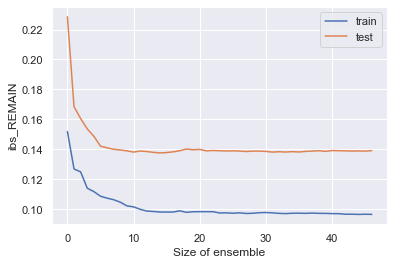

train
test


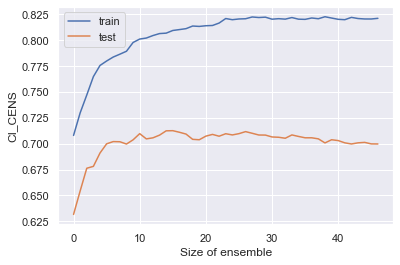

train
test


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls
C:\Program

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\metrics.py:374: RuntimeWarning: invalid value encountered in divide
  false_pos = cumsum_fp / n_controls


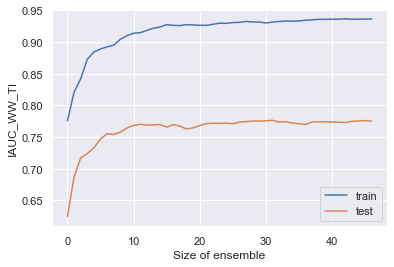

train
test


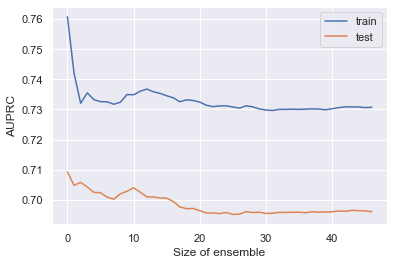

In [1175]:
axx = 1
for mtr in ["ibs_REMAIN", "CI_CENS", "IAUC_WW_TI", "AUPRC"]:
    bstr.plot_curve(X_tr, y_tr, bins_HO, "train", mtr, axes=axx)
    bstr.plot_curve(X_HO, y_HO, bins_HO, "test", mtr, axes=axx)
    plt.legend()
    plt.show()

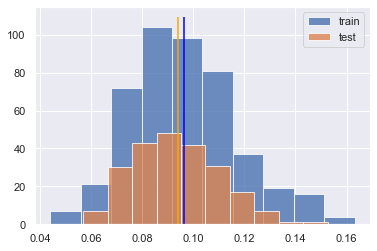

In [1176]:
train_interp = np.sum((bstr.predict_at_times(X_tr, bins=bins_HO, mode="surv") - 0.5)**2, axis=1)/pred_surv.shape[1]
test_interp = np.sum((pred_surv - 0.5)**2, axis=1)/pred_surv.shape[1]

plt.hist(train_interp, alpha=0.8, label="train")
plt.hist(test_interp, alpha=0.8, label="test")

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines([train_interp.mean()], ymin=0, ymax=ymax, color="blue")
plt.vlines([test_interp.mean()], ymin=0, ymax=ymax, color="orange")

plt.legend()

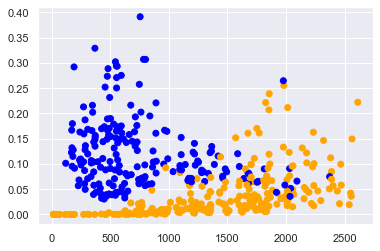

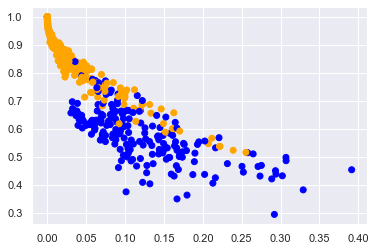

0.7307427905816783
0.073691731945372
0.7385611056932435
0.05703350556292255


In [1177]:
pred_surv_bstr = bstr.predict_at_times(X_tr, bins=bins_HO, mode="surv")
plt.scatter(y_tr["time"], metr.ibs_WW(y_tr, y_tr, pred_surv_bstr, bins_HO, axis=0), 
            c=np.where(y_tr["cens"], "blue", "orange"))
plt.show()
plt.scatter(metr.ibs_WW(y_tr, y_tr, pred_surv_bstr, bins_HO, axis=0), 
            metr.auprc(y_tr, y_tr, pred_surv_bstr, bins_HO, axis=0), 
            c=np.where(y_tr["cens"], "blue", "orange"))
plt.show()
print(np.mean(metr.auprc(y_tr, y_tr, pred_surv_bstr, bins_HO, axis=0)))
print(np.mean(metr.ibs_WW(y_tr, y_tr, pred_surv_bstr, bins_HO, axis=0)))

print(np.median(metr.auprc(y_tr, y_tr, pred_surv_bstr, bins_HO, axis=0)))
print(np.median(metr.ibs_WW(y_tr, y_tr, pred_surv_bstr, bins_HO, axis=0)))

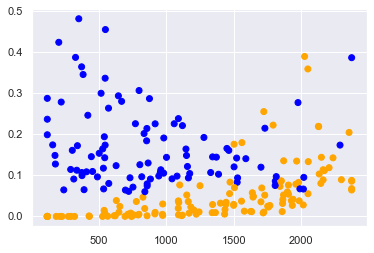

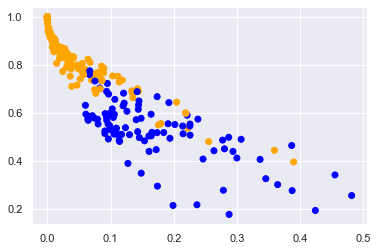

0.6960098722297549
0.10136738799619358
0.7219543051480454
0.08032619425019871


In [1178]:
pred_surv_bstr = bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv")
plt.scatter(y_HO["time"], metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0), 
            c=np.where(y_HO["cens"], "blue", "orange"))
plt.show()
plt.scatter(metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0), 
            metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0), 
            c=np.where(y_HO["cens"], "blue", "orange"))
plt.show()
print(np.mean(metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))
print(np.mean(metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))

print(np.median(metr.auprc(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))
print(np.median(metr.ibs_WW(y_tr, y_HO, pred_surv_bstr, bins_HO, axis=0)))

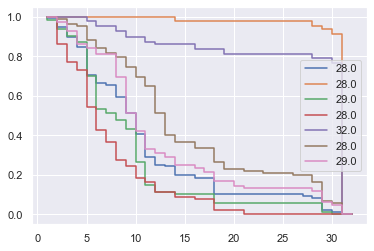

In [549]:
pred_surv_bstr = bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv")

for i in np.where(y_HO["time"] > 25)[0]:
    plt.step(bins_HO, pred_surv_bstr[i], label=y_HO["time"][i])

plt.legend()

In [547]:
X_HO[y_HO["time"] == 29]

min_Prothrombin_time  min_fibrinogen  max____lymphocyte  \
342                  17.4            0.79                6.2   
344                  15.1            4.58                5.2   

     min_HCV_antibody_quantification  max_White_blood_cell_count  \
342                             0.08                       32.99   
344                             0.17                       12.23   

     min_neutrophils_count  max_Prothrombin_time  mean____lymphocyte  \
342                   7.16                  20.0            4.033333   
344                   5.65                  16.5            3.425000   

     max_neutrophils_count  min_PLT_distribution_width  ...  \
342                  31.24                        11.3  ...   
344                  11.13                        16.7  ...   

     min_mean_corpuscular_hemoglobin_  mean_globulin  \
342                              29.2         36.425   
344                              31.3         30.150   

     min_Amino_terminal_brain_natriuretic_peptide_precursor_NT_proBNP_  \
342                                             3251.0                   
344                                              362.0                   

     max_neutrophils___  min_monocytes_count  min_Mean_platelet_volume  \
342                95.0                 0.14                      10.3   
344                93.6                 0.16                      12.0   

     max_Tumor_necrosis_factor_  min_Serum_chloride  \
342                        11.3                97.1   
344                         NaN               113.5   

     max_Hypersensitive_cardiac_troponinI  mean_Uric_acid  
342                                8443.5          315.50  
344                                  14.4          228.25  

[2 rows x 221 columns]

In [548]:
bstr.models[0].visualize(mode="surv")

In [ ]:
[0.76148047 0.07352419 0.13980771 0.82946707 0.74286172 0.5305663
 0.72999533] # rank timeline

In [ ]:
[0.75421522 0.07813184 0.14888686 0.8335198  0.73483829 0.52543357
 0.72214709] # minstd full timeline

[0.76065798 0.07439718 0.14766853 0.85279943 0.7351438  0.52829684
 0.72260762] # minstd rank timeline

In [ ]:
[0.75188485 0.07409013 0.14285489 0.85783089 0.74401594 0.5302137
 0.73105823] # diptest full timeline

In [ ]:
[0.62220051 0.14063964 0.35077657 0.7636975  0.69013242 0.51602659
 0.67040949]

In [ ]:
[0.63251905 0.14106872 0.34654997 0.76467459 0.69642419 0.519807
 0.67641677]

In [177]:
from scipy.signal import find_peaks, peak_widths

def max_width_peaks(x):
    peaks, _ = find_peaks(x)
    print(peaks)
    if len(peaks) > 1:
        distances = np.diff(peaks)
        return max(distances)
    return 0

max_width_peaks(np.histogram(data, bins=30)[0])

[ 7 21]


14

BC: 0.3097707514464615
diptest: 0.11607142857142858


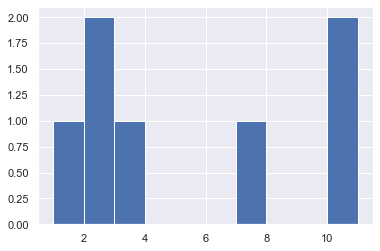

In [294]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks, peak_widths
from scipy.stats import skew, kurtosis

# Сгенерируем случайные данные
# data = np.concatenate([np.random.normal(0, 1, 1000), np.random.normal(4, 1, 1000)])
x = np.array([1, 2, 1, 0, 0, 0, 1, 0, 0, 1, 1])
data = np.repeat(np.arange(1, x.size + 1), x.astype(int))

plt.hist(data)
sk = skew(data)
ku = kurtosis(data)
n = data.size

BC = (sk**2 + 1) / (ku + 3*((n - 1)**2 / ((n - 2) * (n - 3))))
print("BC:", BC)
print("diptest:", diptest.dipstat(data))
# # Построим гистограмму
# plt.hist(data, bins=30)

# print(max_width_peaks(np.histogram(data, bins=30)[0]))

In [153]:
peaks

array([2, 7], dtype=int64)

In [ ]:
[0.75243317 0.07333642 0.13933905 0.8614329  0.74303577 0.52134847
 0.72960017]

In [ ]:
[0.74996573 0.07691214 0.14588498 0.85021201 0.74433642 0.52095168
 0.73079795]

In [ ]:
[0.76422207 0.06826685 0.13153203 0.89333202 0.75438083 0.53143861
 0.74086918]

[0.76319397 0.0720167  0.14611618 0.86796958 0.75141347 0.52898566
 0.73793299]

In [ ]:
[0.75668266 0.07506964 0.13524413 0.80499555 0.74893613 0.52512688
 0.73537194]

[0.75695682 0.07440272 0.14538163 0.85218725 0.74779245 0.52774081
 0.73445599]

In [ ]:
[0.75791638 0.07364925 0.13941104 0.84413016 0.74317018 0.52911454
 0.73019711]

[0.76004112 0.0753898  0.14509276 0.83574934 0.74281228 0.52814724
 0.72980227]

In [ ]:
[0.77930089 0.07105522 0.13704887 0.85401808 0.7516657  0.52669224
 0.73803095]

In [ ]:
[0.76319397 0.0720167  0.14611618 0.86796958 0.75141347 0.52898566
 0.73793299]



In [ ]:
[0.75716244 0.07354856 0.13494969 0.85672017 0.74750994 0.52062937
 0.7337596 ]

In [ ]:
[0.75517478 0.07205391 0.13473618 0.86944936 0.74515232 0.52232319
 0.73164753]
[0.7540096  0.07487264 0.13640897 0.87782645 0.74885486 0.52464159
 0.73526618]

In [ ]:
[0.62259136 0.14198701 0.35885451 0.77255067 0.69410347 0.5194261
 0.6743158 ]

In [ ]:
[0.7540096  0.07479226 0.13625052 0.87836153 0.74900861 0.52494637
 0.73542908]

In [ ]:
[0.74002742 0.07227528 0.13196277 0.86458745 0.74718982 0.52254975
 0.73357527]

In [ ]:
[0.75531186 0.07359772 0.14559497 0.85845047 0.74459797 0.52122024
 0.73105993]

In [ ]:
[0.75716244 0.07354856 0.13494969 0.85672017 0.74750994 0.52062937
 0.7337596 ]

In [ ]:
[0.75517478 0.07205391 0.13473618 0.86944936 0.74515232 0.52232319
 0.73164753]

In [ ]:
[0.75551748 0.0749408  0.14910095 0.85885689 0.7424502  0.52176386
 0.72907527]

In [ ]:
[0.63056478 0.14079638 0.34322143 0.76938389 0.69300919 0.51992004
 0.67340143]

In [ ]:
[0.63146375 0.14081558 0.34032002 0.76382246 0.6913002  0.51914928
 0.67179873]

In [ ]:
[0.63306625 0.13905343 0.37198661 0.78508546 0.68627601 0.52907648
 0.66846826]

In [1187]:
max(split_time_to_bins(y["time"], bins_HO))

2254

0.0459077959077959


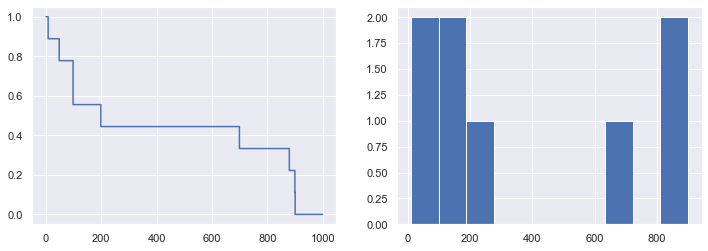

In [1247]:
def count_sf_diff_1(time, cens, bins=None, ax=None):
    c_time = np.cumsum(time[::-1])[::-1]
    sf = np.cumprod((1.0 - cens / (c_time + 1)))
    sf[c_time == 0] = 0.0
    if not(bins is None):
        ax.step(bins, sf[1:-1])
    return np.sum((sf - 0.5)**2) / sf.shape[0] # max(1, bins[-1] - bins[0])

def research_surv(time, cens, bins=None):
    if bins is None:
        bins = np.arange(time.min() - 1, time.max())
    t1 = split_time_to_bins(time, bins)
    bins1 = split_time_to_bins(bins, bins)
    max_bin = bins1.max()
    curr_time_hist, curr_cens_hist = get_sa_hists(t1, cens, minlength=max_bin + 2)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    print(count_sf_diff_1(curr_time_hist, curr_cens_hist, bins, axes[0]))
    axes[1].hist(time)
    plt.show()
    
# research_surv(y["time"], y["cens"], bins_HO)
a = np.array([10, 50, 100, 100, 200, 700, 880, 900])
research_surv(a, np.ones_like(a), np.arange(1, 1000))

0.0783070803463687


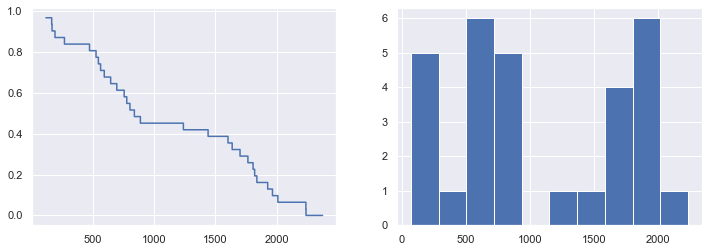

0.0998902888943751


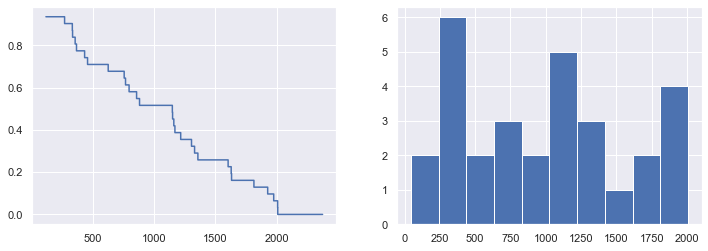

0.10956793897709104


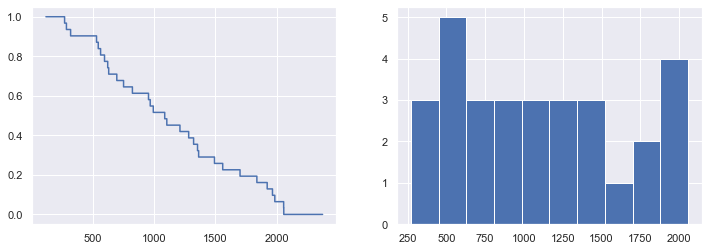

0.0821057841171544


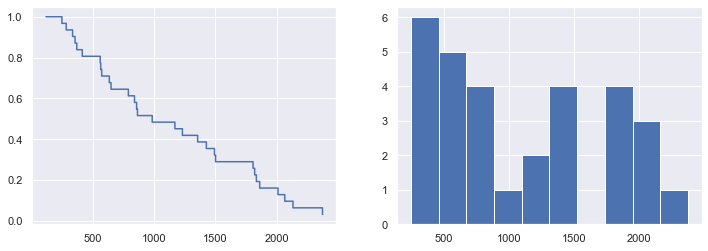

0.07891804776528515


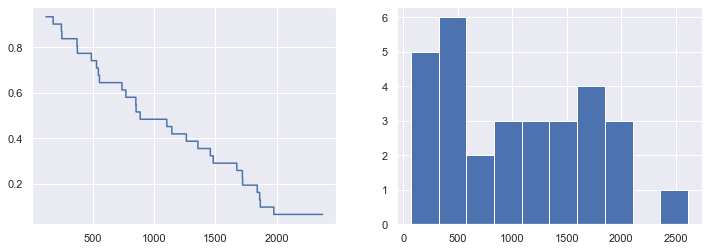

0.07064968355671637


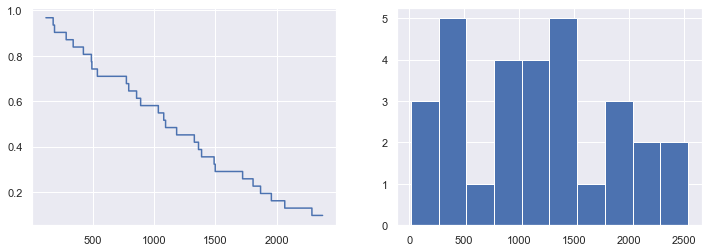

0.0905042788484833


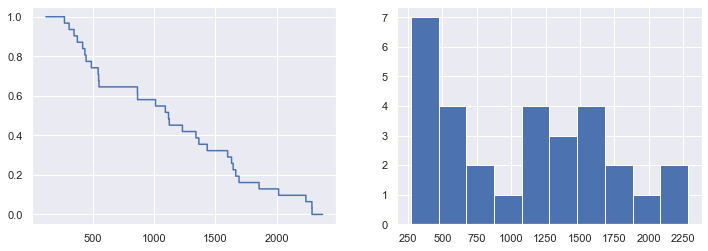

0.06150916797220192


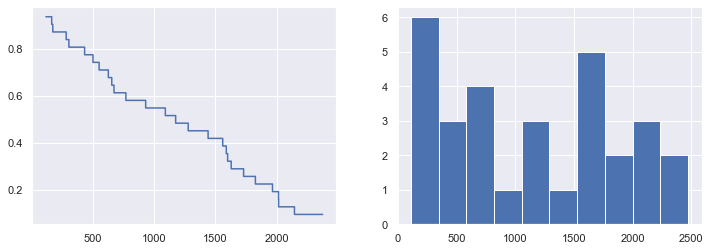

0.07776071673307786


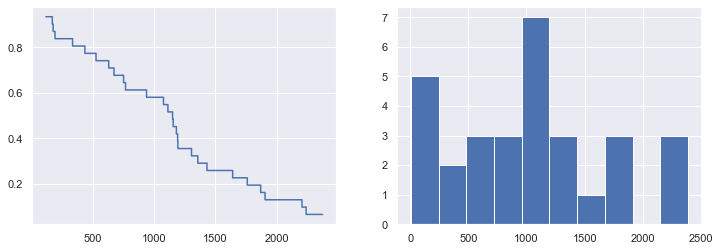

0.08327695882199576


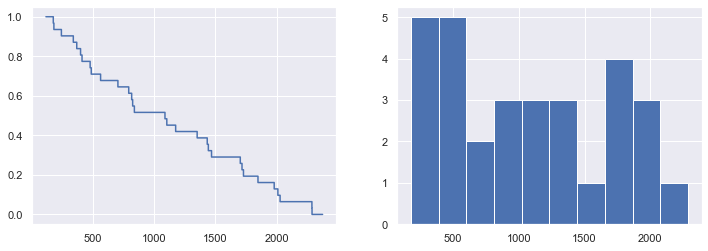

In [1265]:
import random

for i in range(10):
    a = random.sample(list(y["time"]), 30)
    research_surv(a, np.ones_like(a), bins_HO)

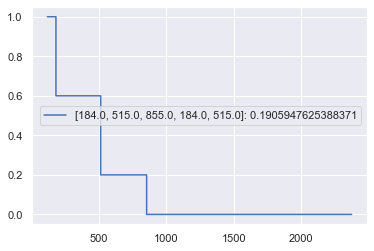

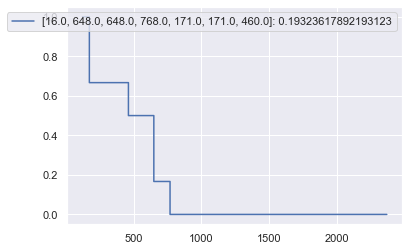

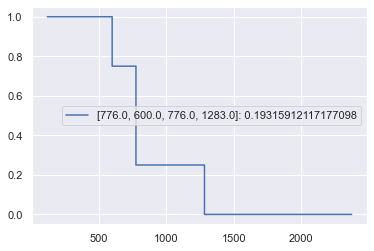

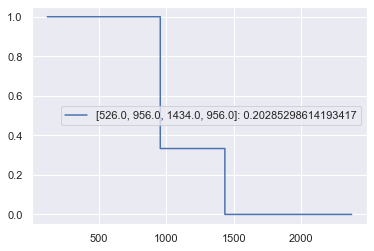

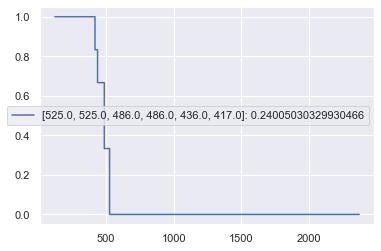

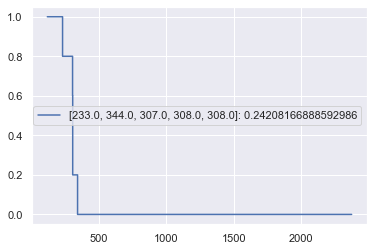

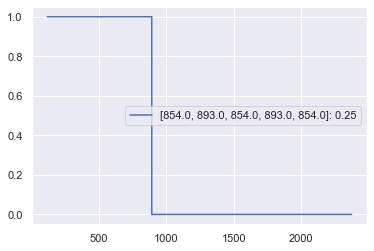

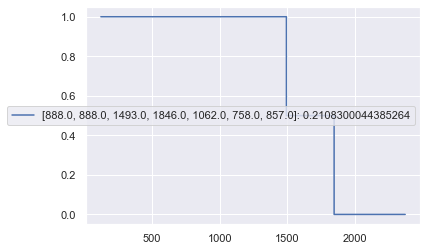

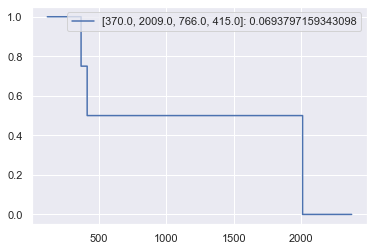

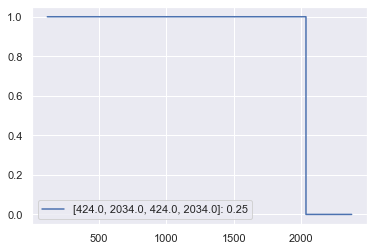

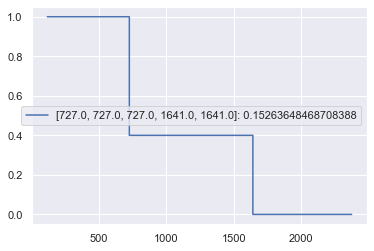

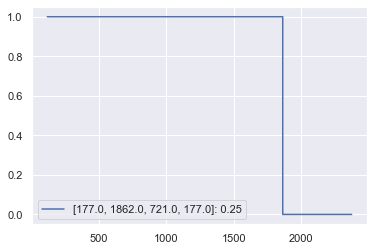

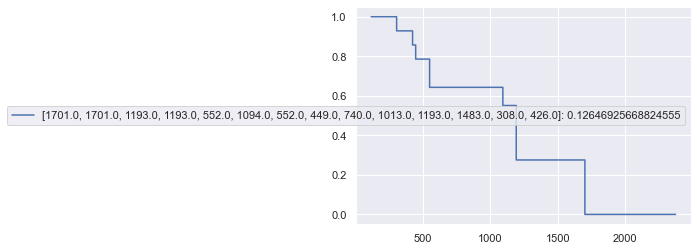

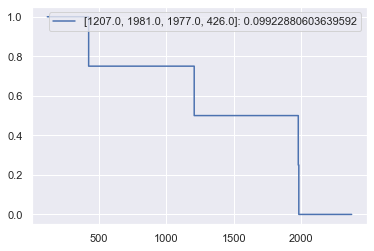

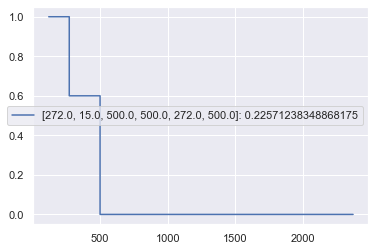

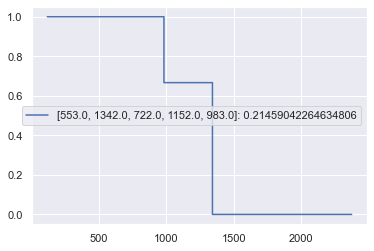

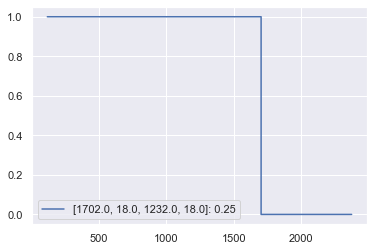

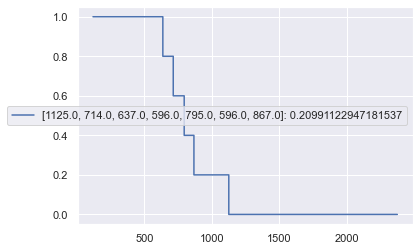

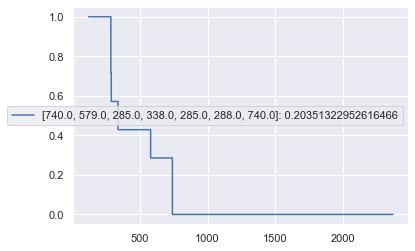

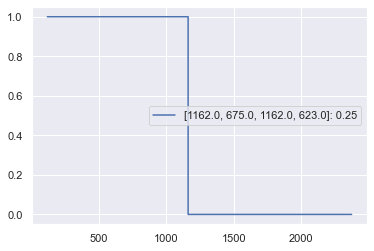

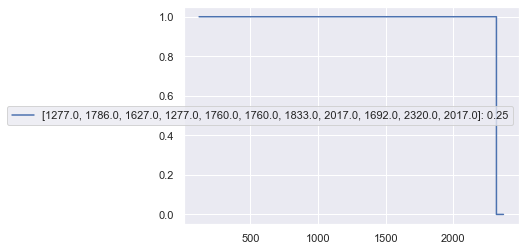

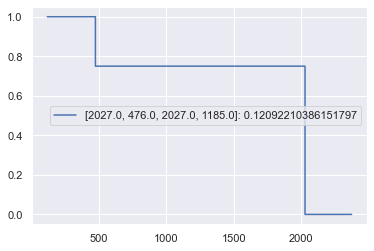

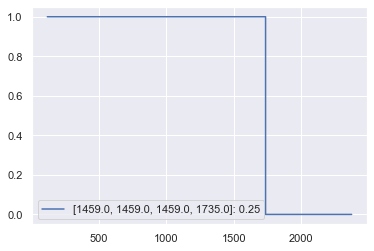

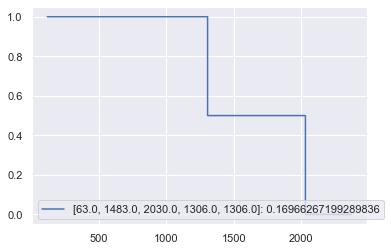

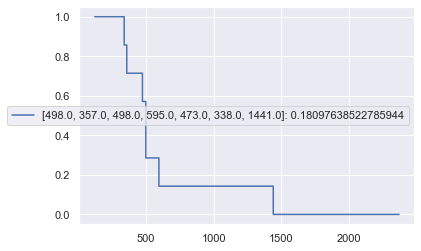

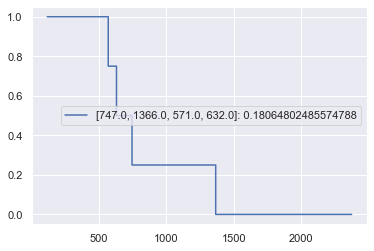

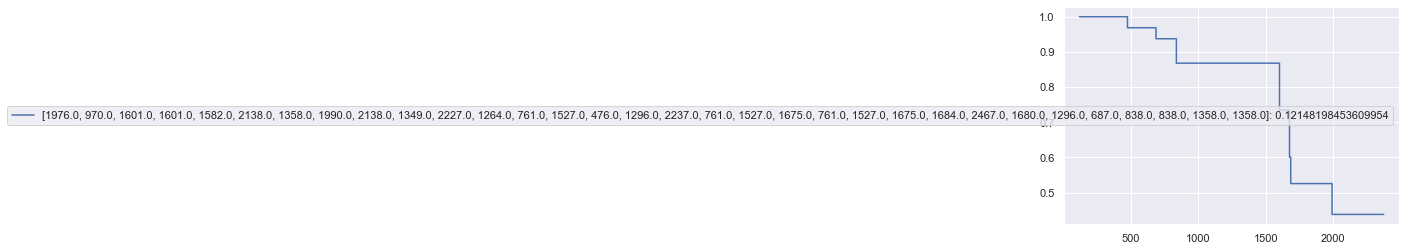

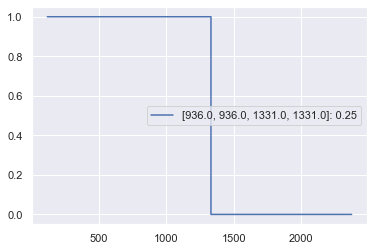

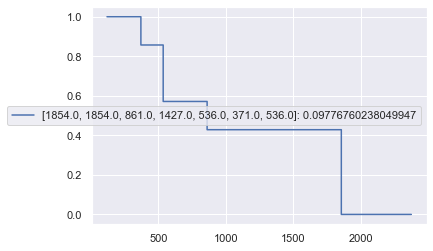

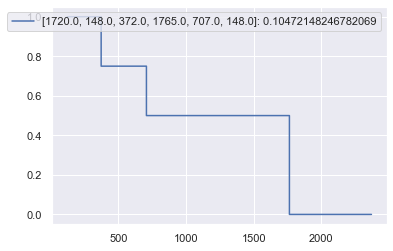

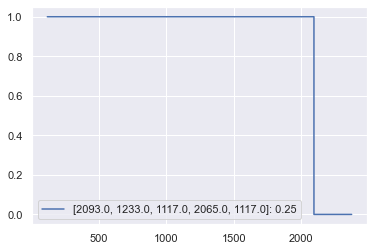

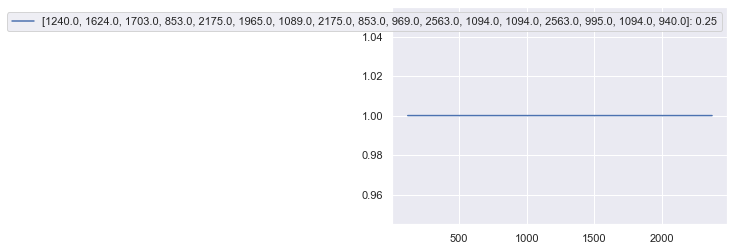

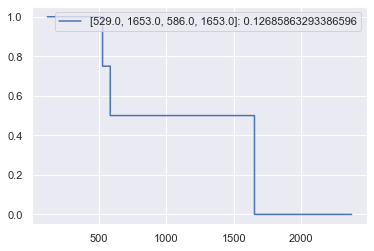

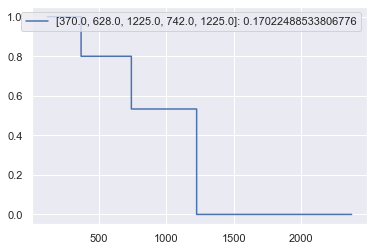

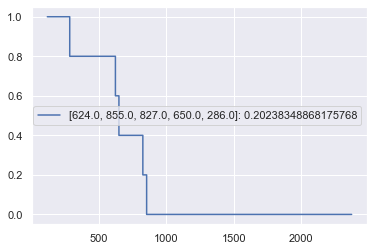

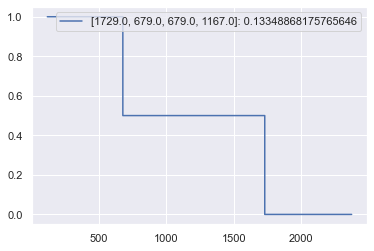

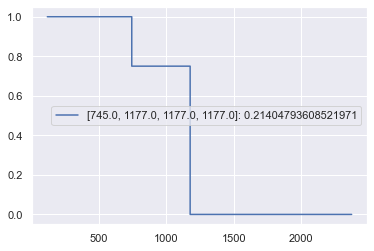

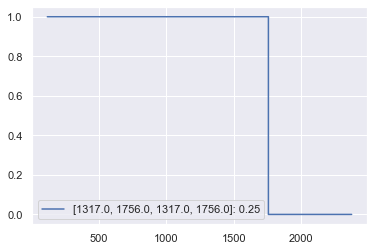

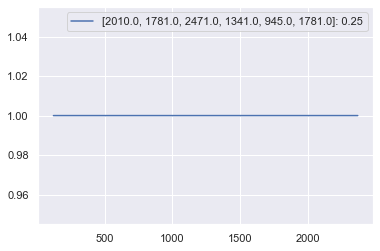

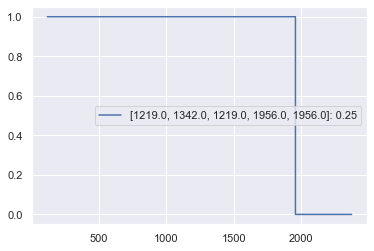

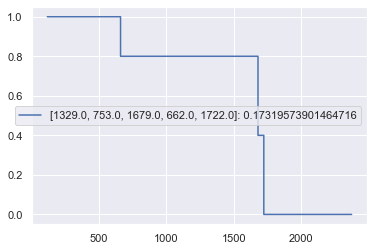

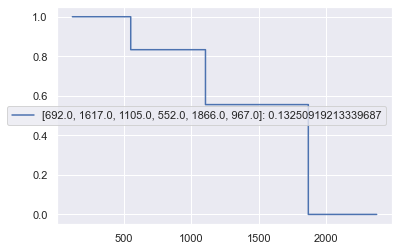

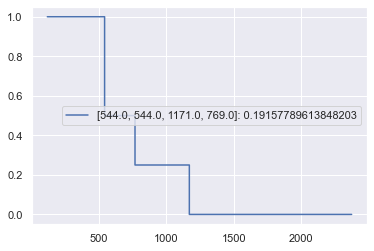

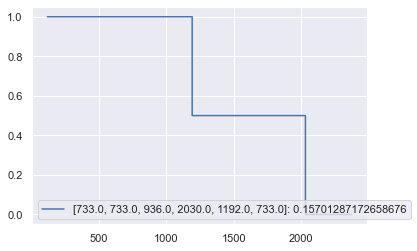

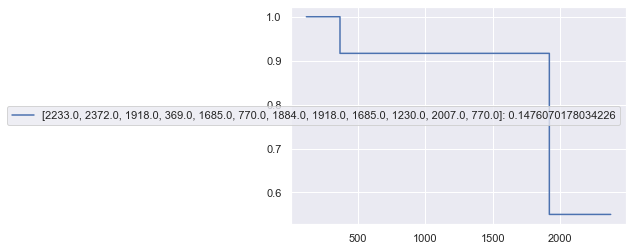

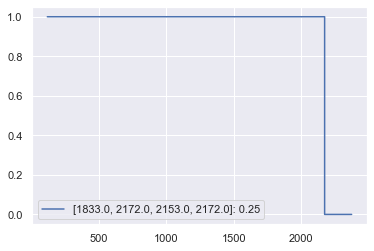

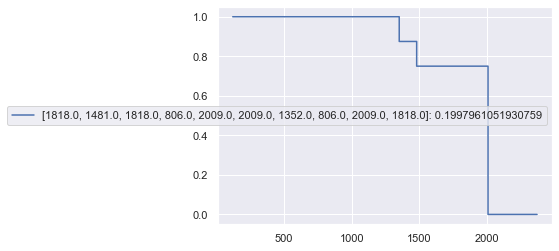

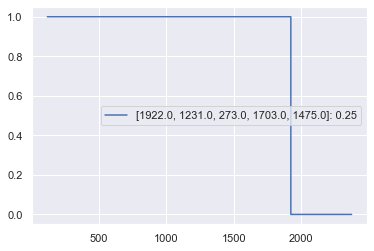

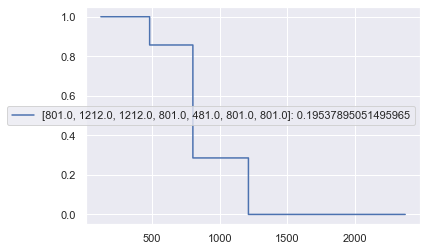

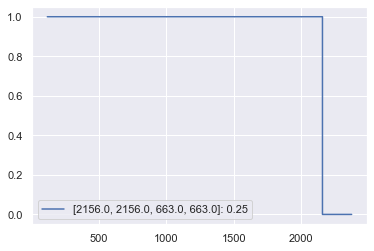

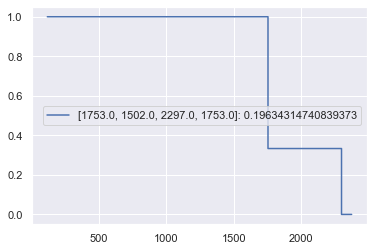

In [1268]:
for k, n in bstr.models[0].nodes.items():
    if not(n.is_leaf):
        continue
    sf = n.leaf_model.predict_survival_at_times(X=None, bins=bins_HO)
    plt.step(bins_HO, sf, label=f"{n.leaf_model.lists['time']}: {np.sum((sf - 0.5)**2) / sf.shape[0]}")
    plt.legend()
    plt.show()

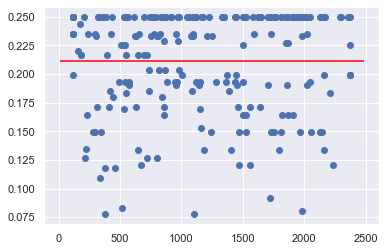

In [1331]:
sfs = bstr.models[0].predict_at_times(X_HO, mode="surv", bins=bins_HO)
nodes = bstr.models[0].predict(X_HO, target="numb")

ibss = metr.ibs_WW(y_tr, y_HO, sfs, bins_HO, axis=0)
plt.scatter(y_HO["time"], np.sum((sfs - 0.5)**2, axis=1) / sfs.shape[1])
xmin, xmax, ymin, ymax = plt.axis()
plt.hlines([np.mean(np.sum((sfs - 0.5)**2, axis=1) / sfs.shape[1])], 
           xmin=xmin, xmax=xmax, color="red")

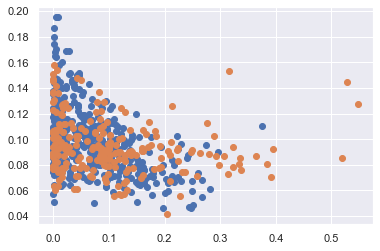

In [1376]:
sfs = bstr.predict_at_times(X_tr, mode="surv", bins=bins_HO)
# nodes = bstr.predict(X_tr, target="numb")

ibss = metr.ibs_WW(y_tr, y_tr, sfs, bins_HO, axis=0)
plt.scatter(ibss, np.sum((sfs - 0.5)**2, axis=1) / sfs.shape[1])

sfs = bstr.predict_at_times(X_HO, mode="surv", bins=bins_HO)
# nodes = bstr.predict(X_HO, target="numb")

ibss = metr.ibs_WW(y_tr, y_HO, sfs, bins_HO, axis=0)
plt.scatter(ibss, np.sum((sfs - 0.5)**2, axis=1) / sfs.shape[1])

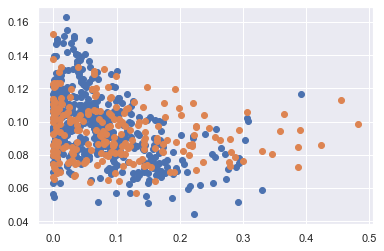

In [1369]:
sfs = bstr.predict_at_times(X_tr, mode="surv", bins=bins_HO)
nodes = bstr.predict(X_tr, target="numb")

ibss = metr.ibs_WW(y_tr, y_tr, sfs, bins_HO, axis=0)
plt.scatter(ibss, np.sum((sfs - 0.5)**2, axis=1) / sfs.shape[1])

sfs = bstr.predict_at_times(X_HO, mode="surv", bins=bins_HO)
nodes = bstr.predict(X_HO, target="numb")

ibss = metr.ibs_WW(y_tr, y_HO, sfs, bins_HO, axis=0)
plt.scatter(ibss, np.sum((sfs - 0.5)**2, axis=1) / sfs.shape[1])

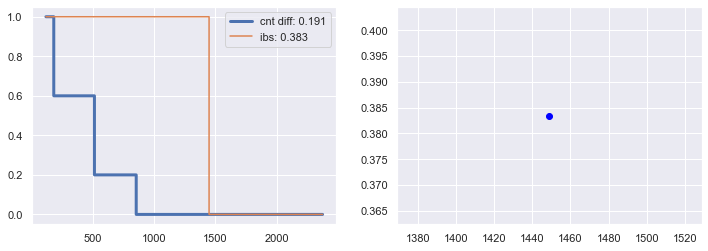

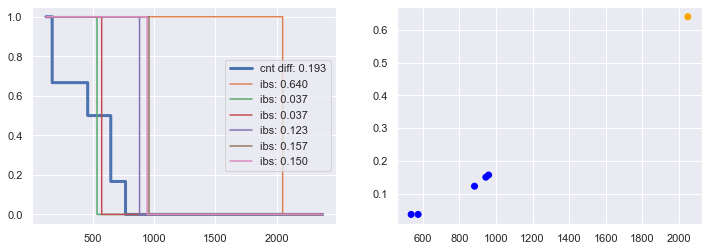

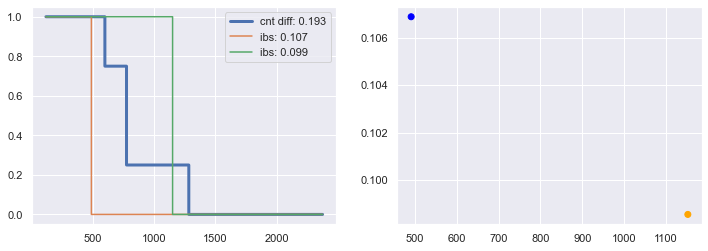

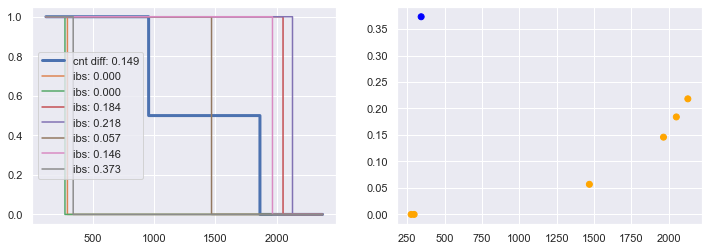

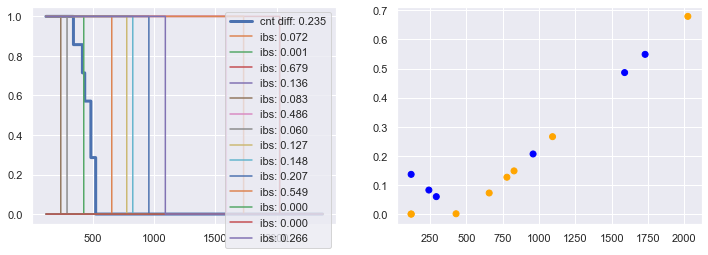

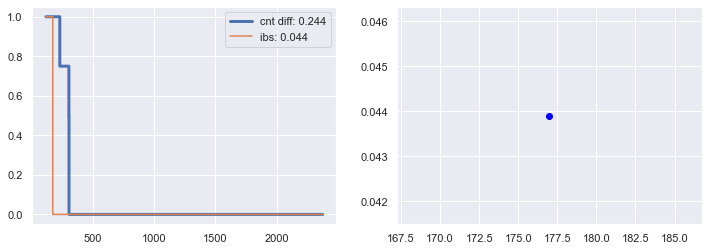

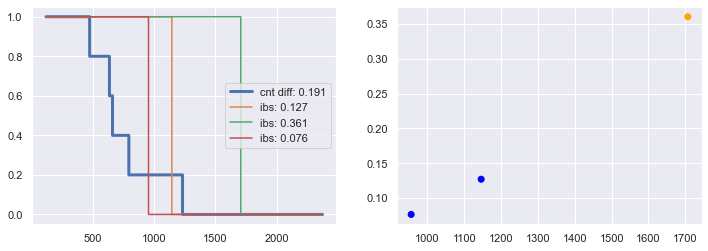

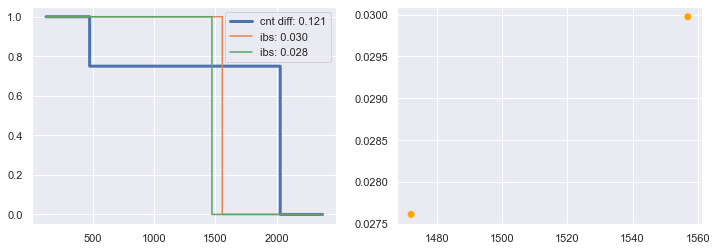

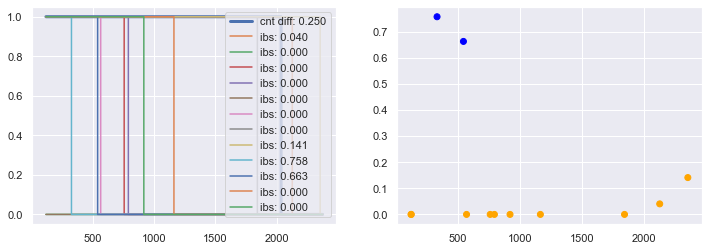

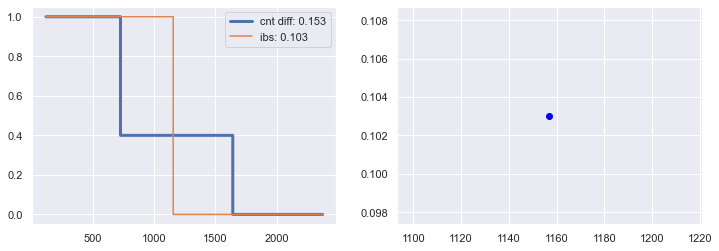

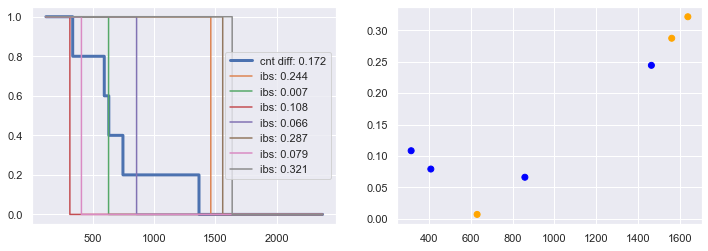

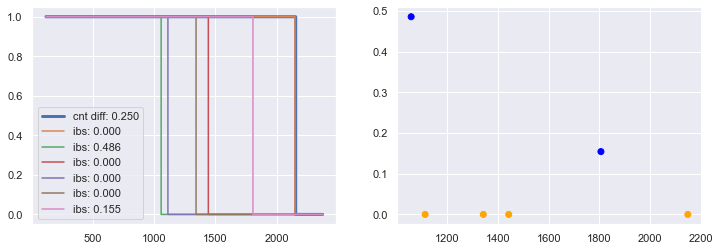

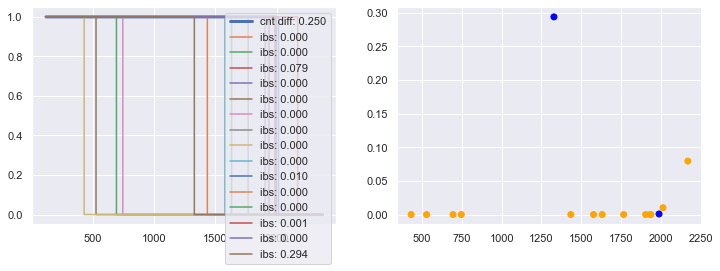

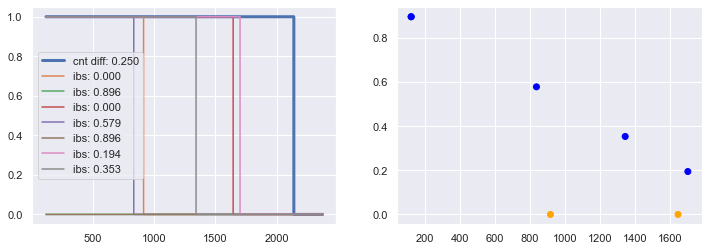

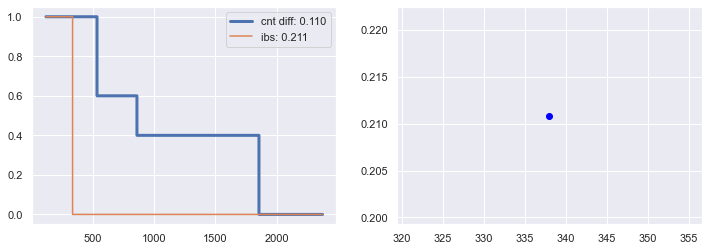

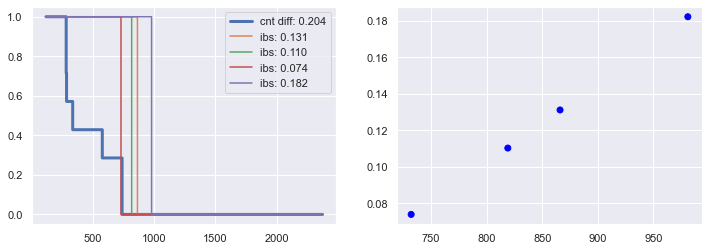

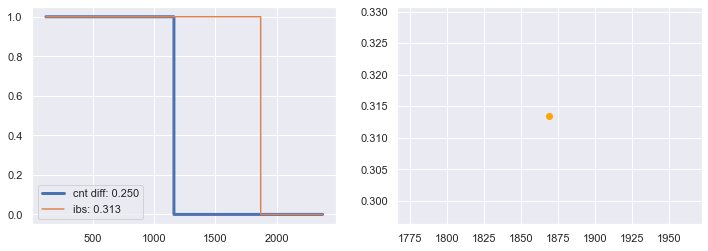

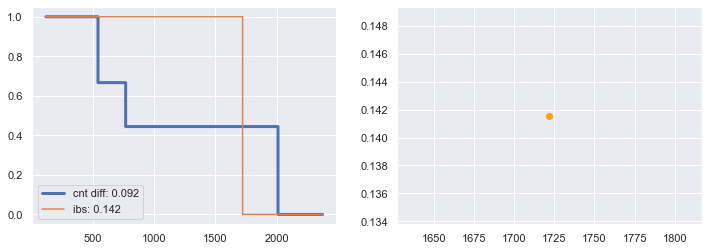

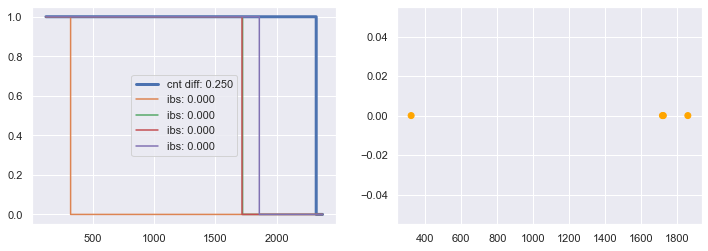

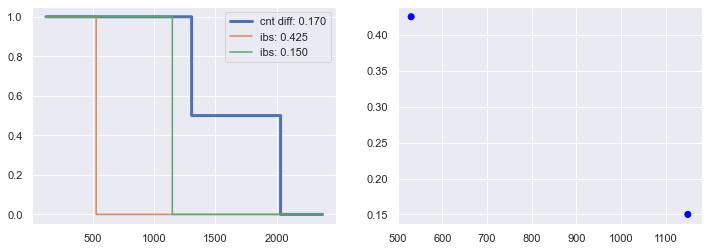

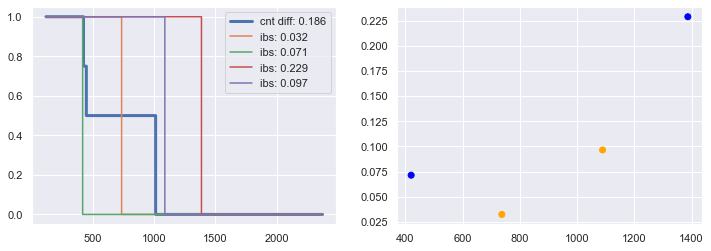

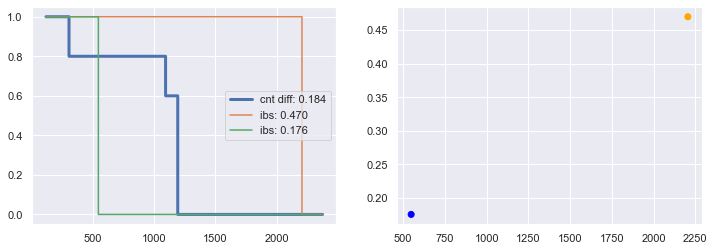

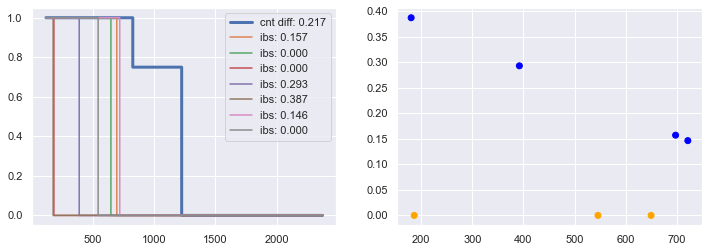

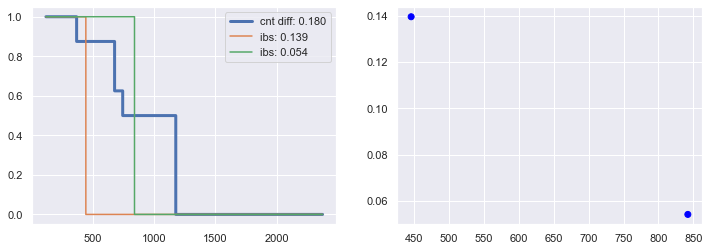

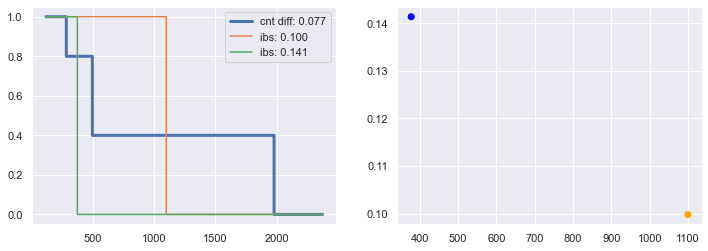

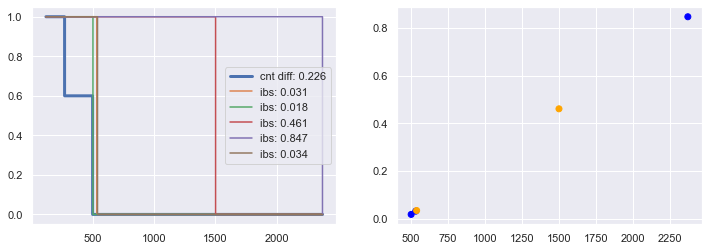

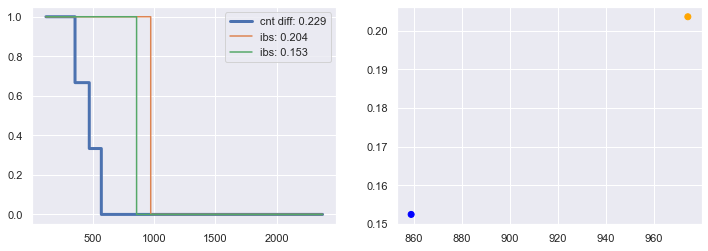

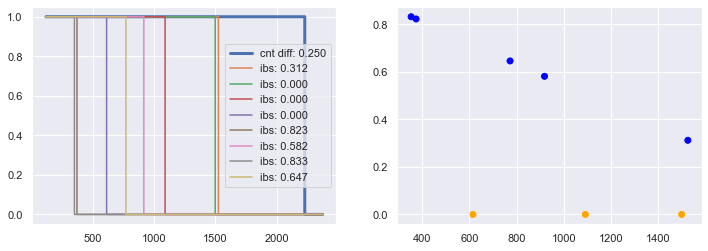

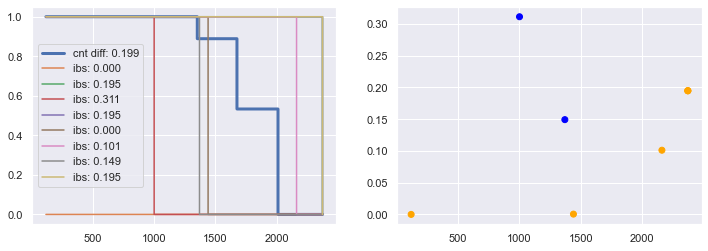

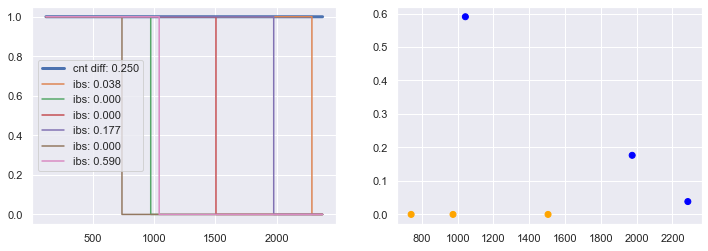

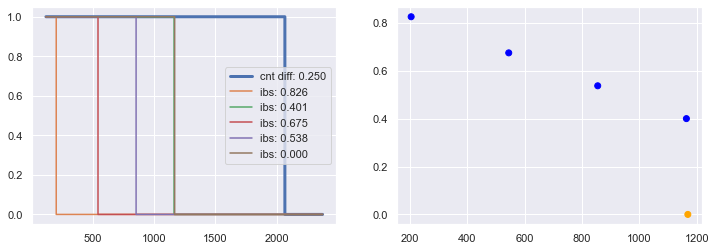

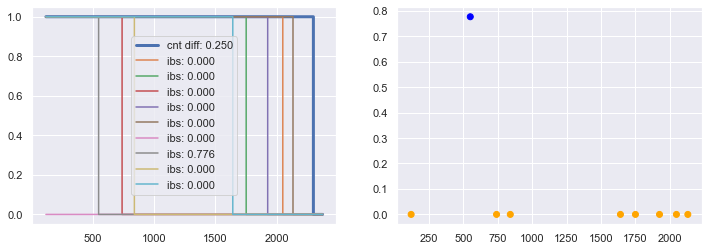

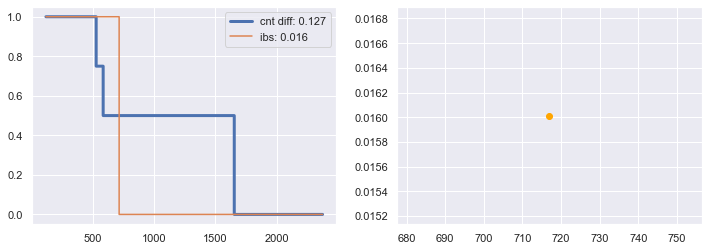

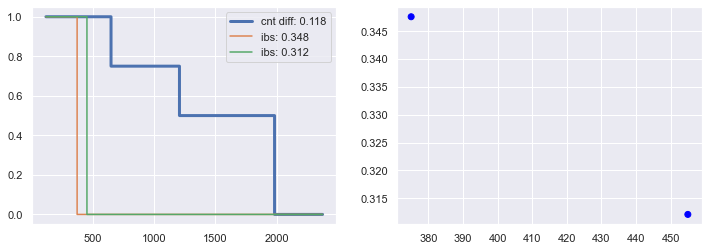

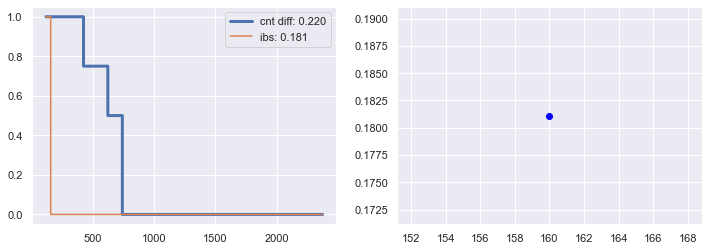

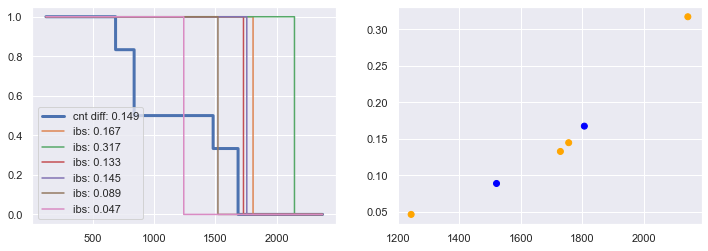

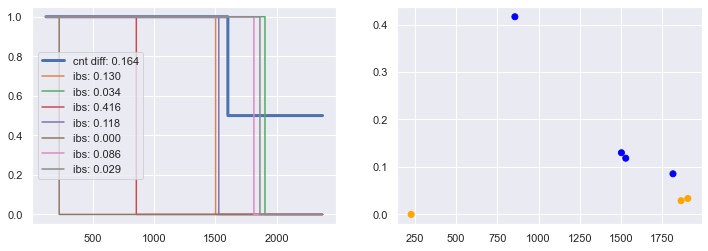

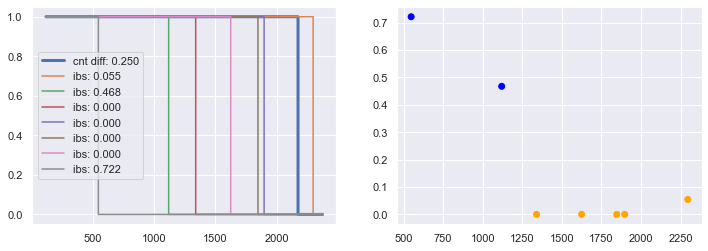

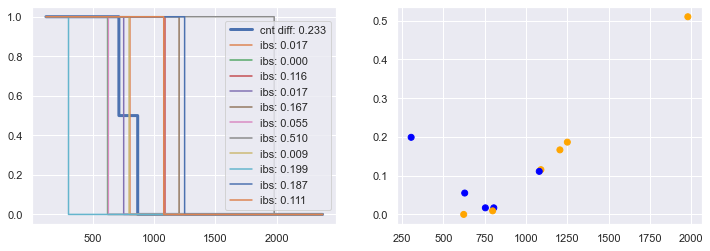

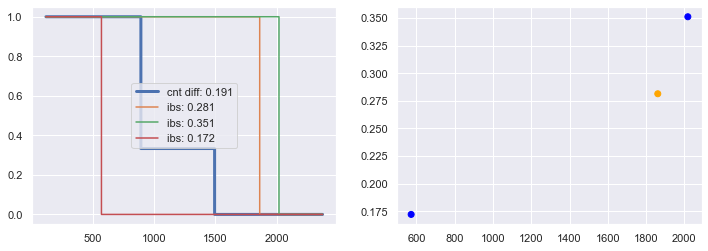

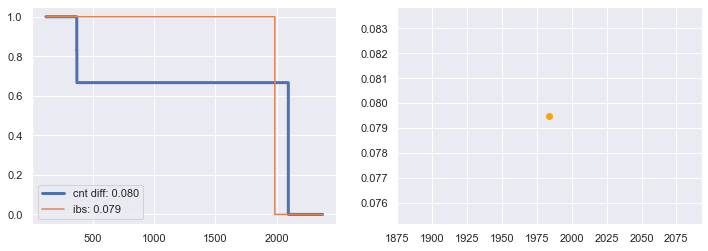

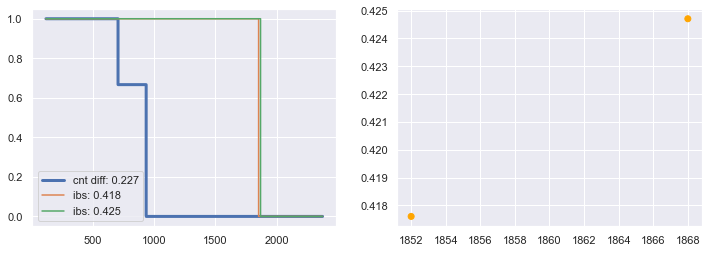

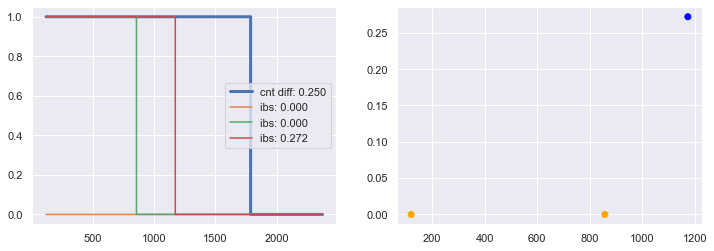

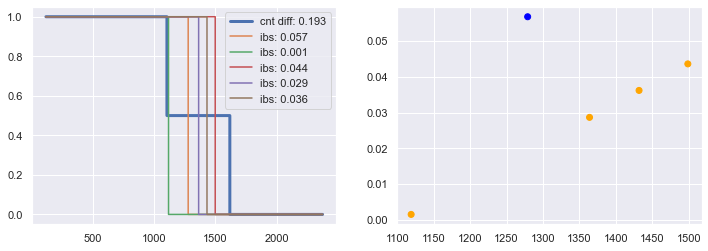

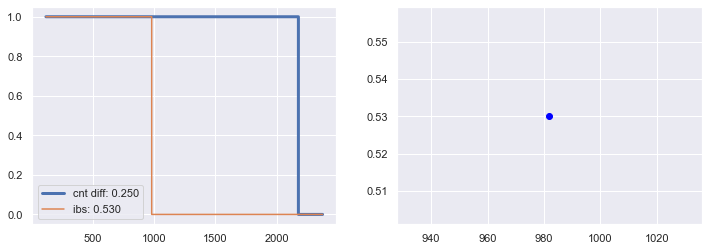

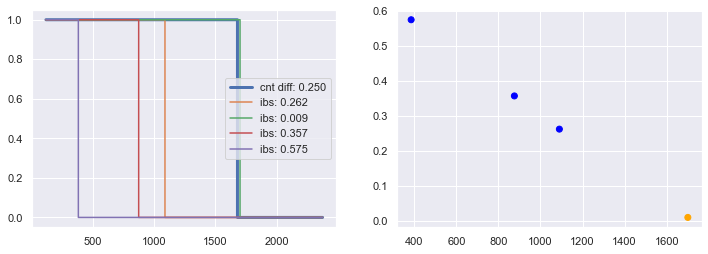

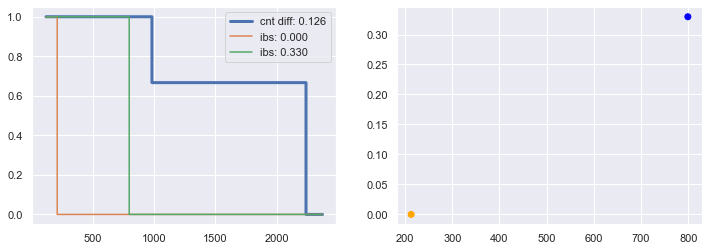

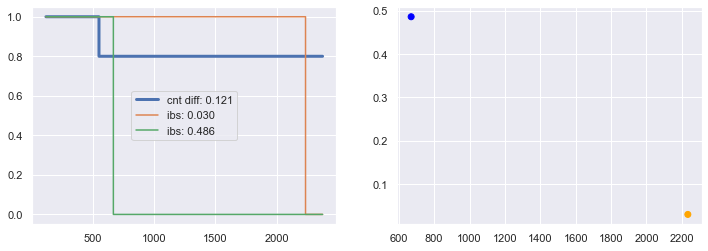

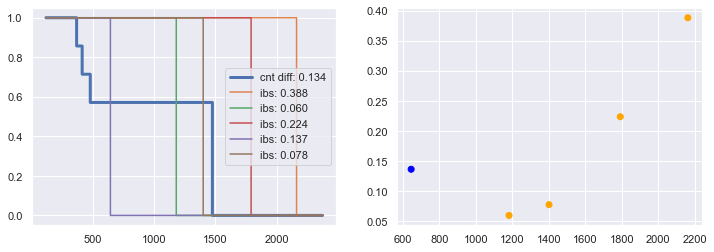

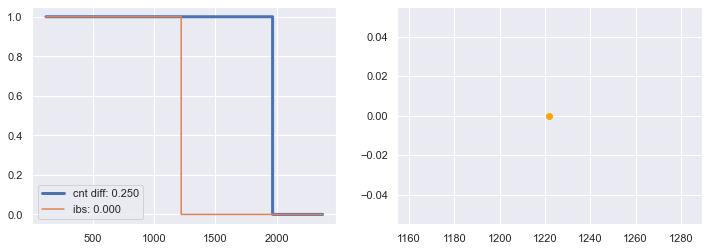

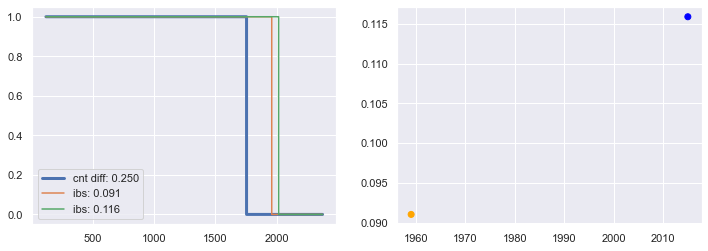

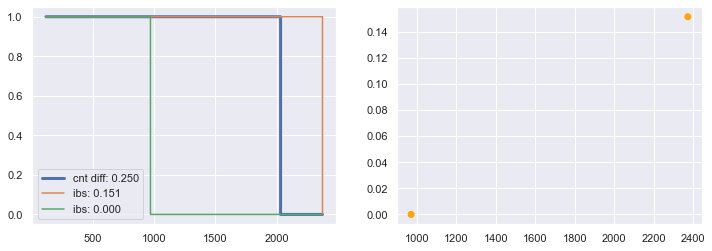

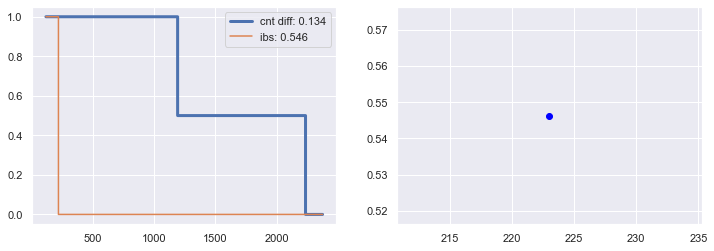

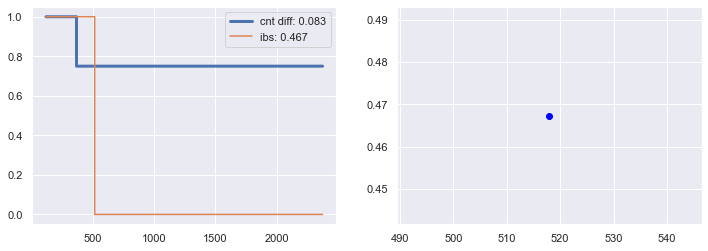

In [1332]:
for n_numb in np.unique(nodes):
    n = bstr.models[0].nodes[n_numb]
    y_HO_ = y_HO[np.where(nodes == n_numb)[0]]
    ibs_ = ibss[np.where(nodes == n_numb)[0]]
    
    sf = n.leaf_model.predict_survival_at_times(X=None, bins=bins_HO)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].step(bins_HO, sf, label=f"cnt diff: {np.sum((sf - 0.5)**2) / sf.shape[0]:.3f}", linewidth=3)
    for l_y, l_ibs in zip(y_HO_, ibs_):
        axes[0].step(bins_HO, np.where(bins_HO < l_y["time"], 1, 0), label=f"ibs: {l_ibs:.3f}")
    axes[0].legend()
    
    axes[1].scatter(y_HO_["time"], ibs_, c=np.where(y_HO_["cens"], "blue", "orange"))
    plt.show()

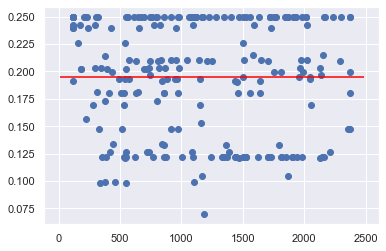

In [1322]:
sfs = bstr.models[0].predict_at_times(X=X_HO, mode="surv", bins=bins_HO)
nodes = bstr.models[0].predict(X=X_HO, target="numb")

ibss = metr.ibs_WW(y_tr, y_HO, sfs, bins_HO, axis=0)
plt.scatter(y_HO["time"], np.sum((sfs - 0.5)**2, axis=1) / sfs.shape[1])
xmin, xmax, ymin, ymax = plt.axis()
plt.hlines([np.mean(np.sum((sfs - 0.5)**2, axis=1) / sfs.shape[1])], 
           xmin=xmin, xmax=xmax, color="red")

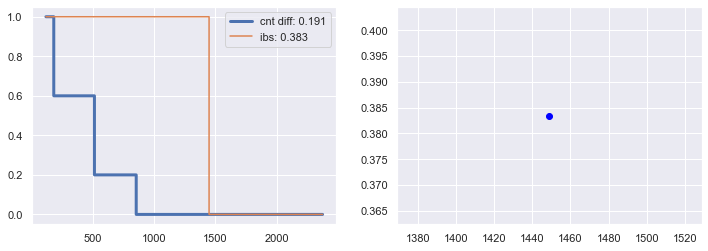

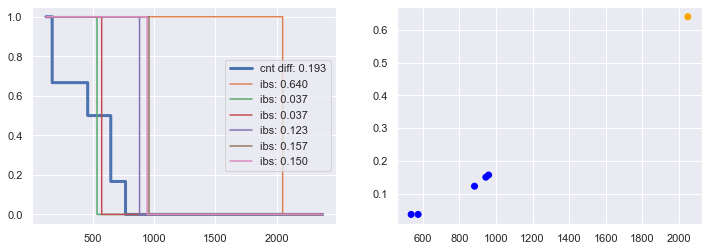

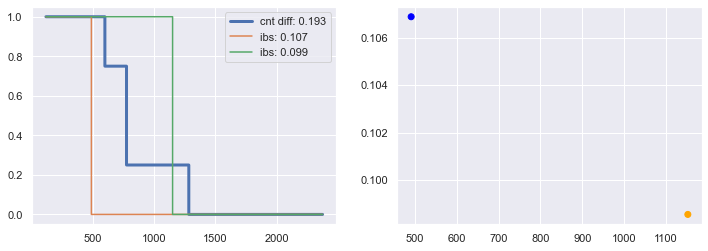

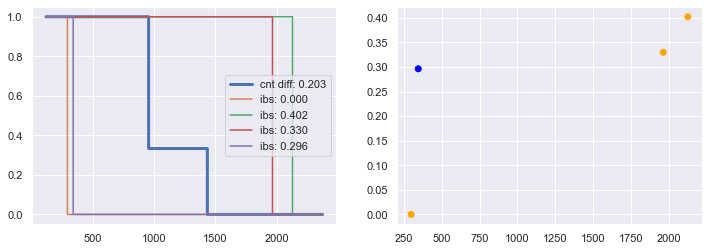

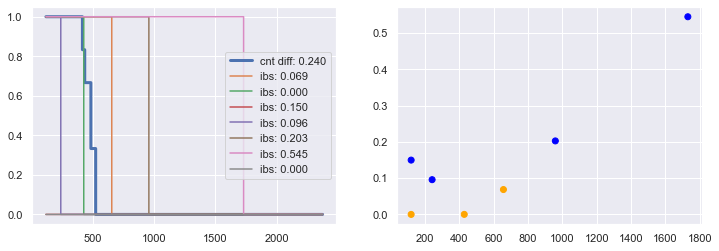

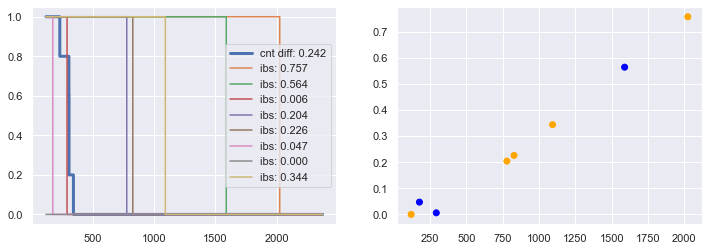

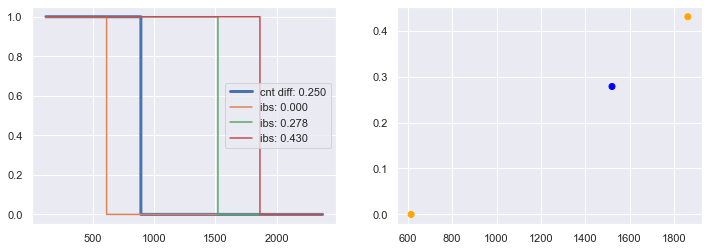

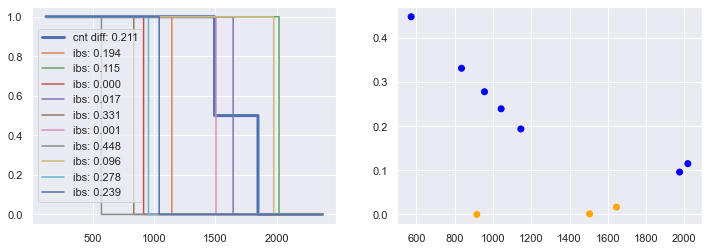

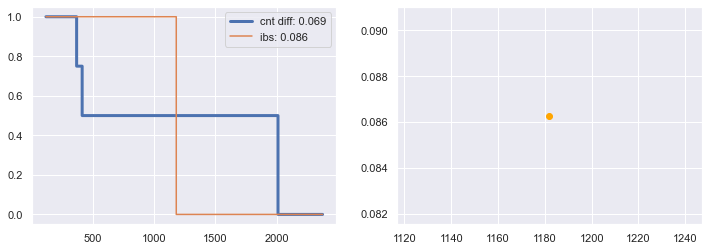

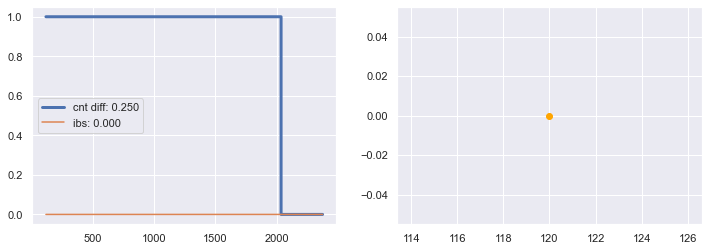

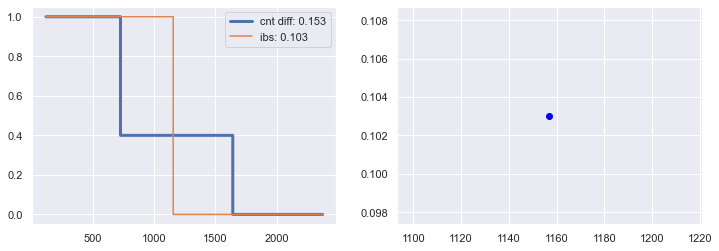

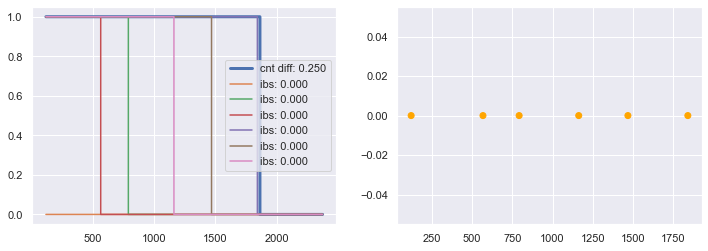

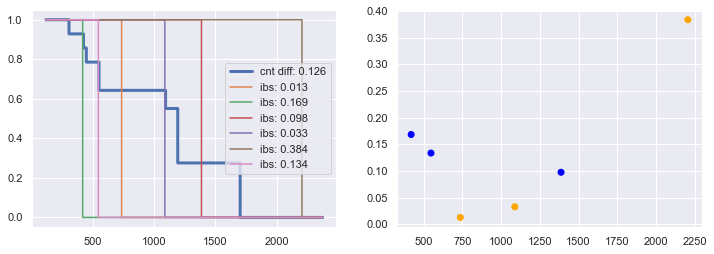

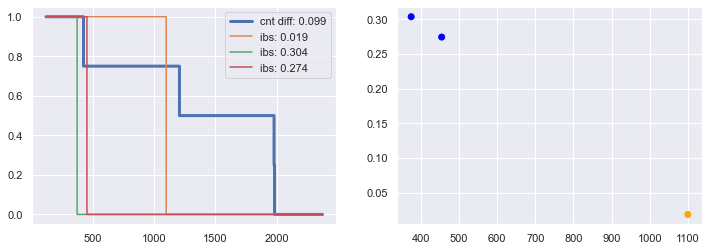

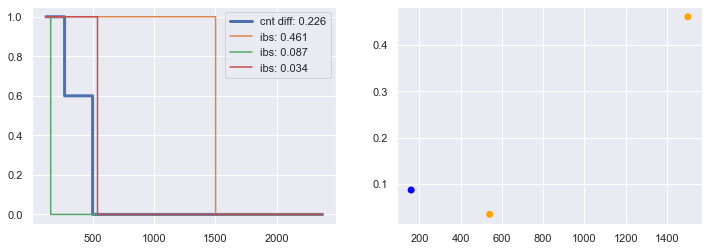

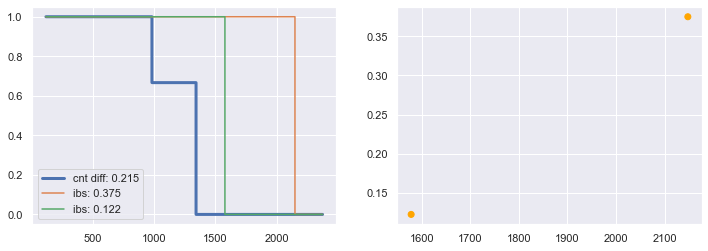

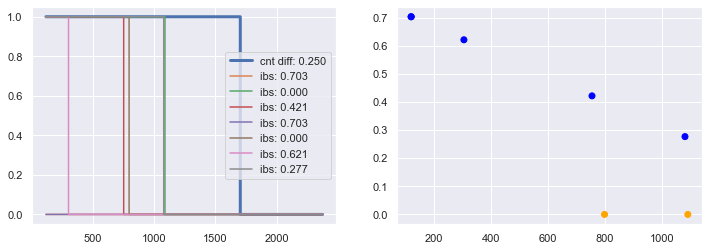

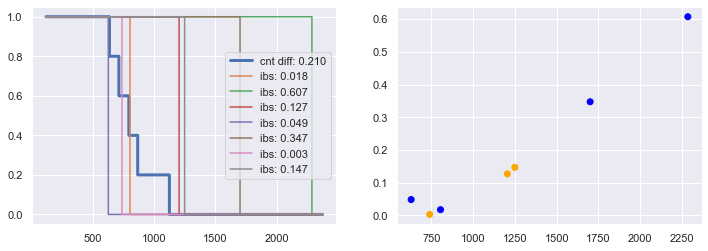

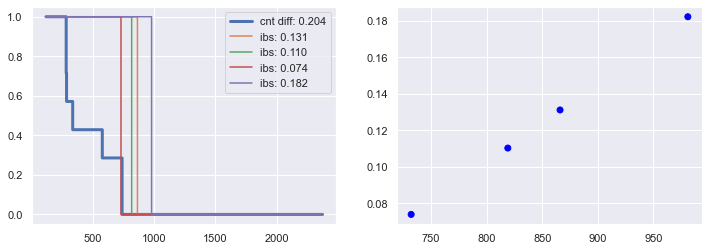

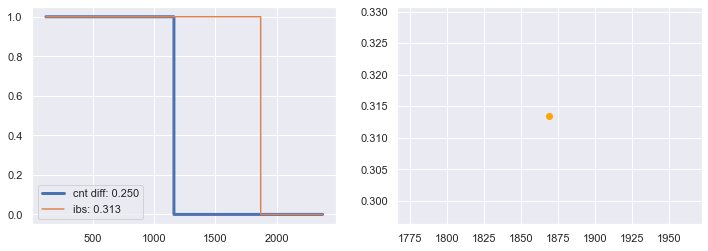

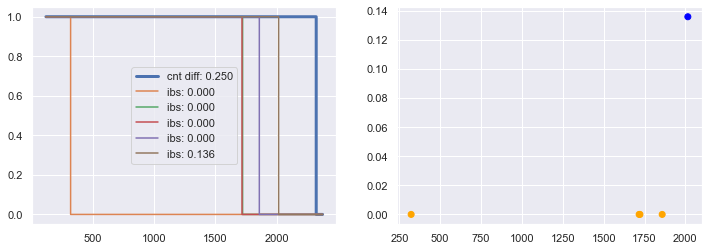

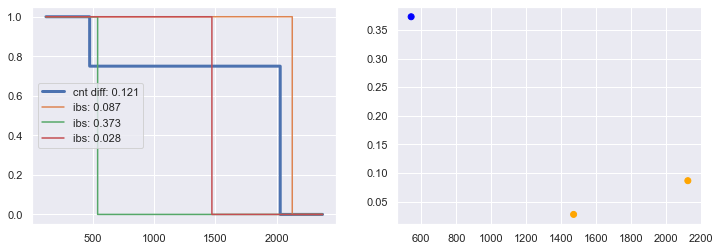

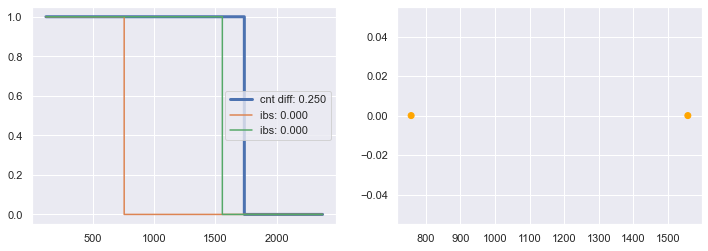

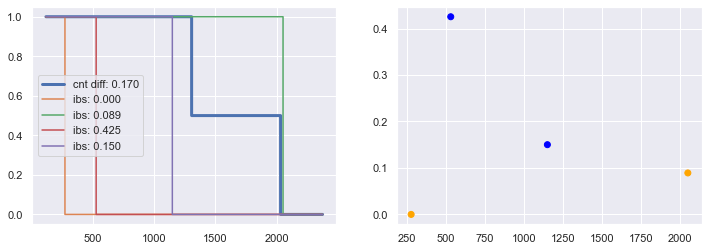

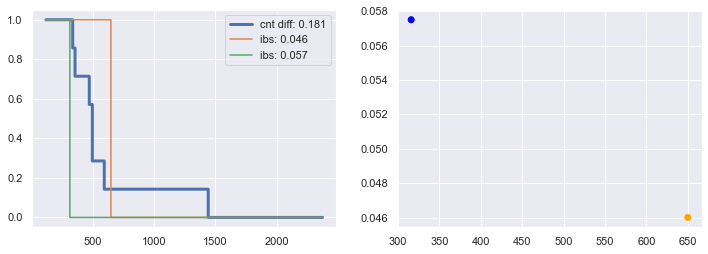

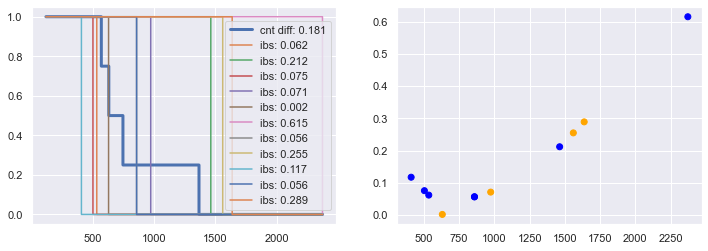

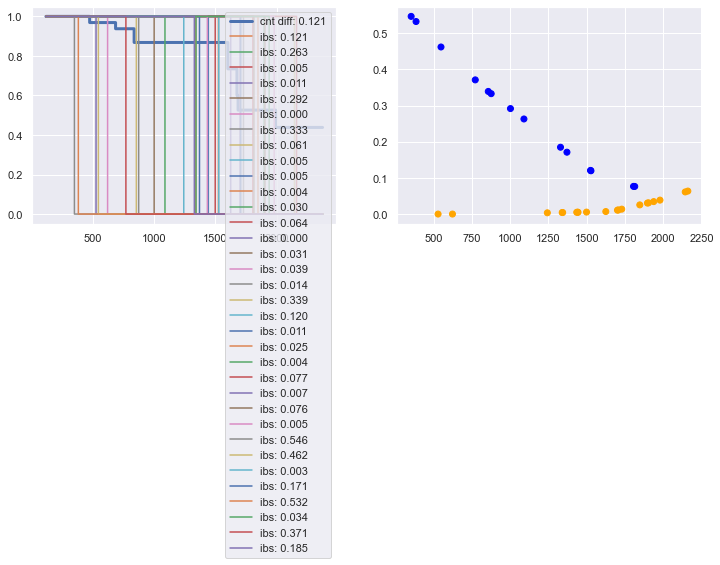

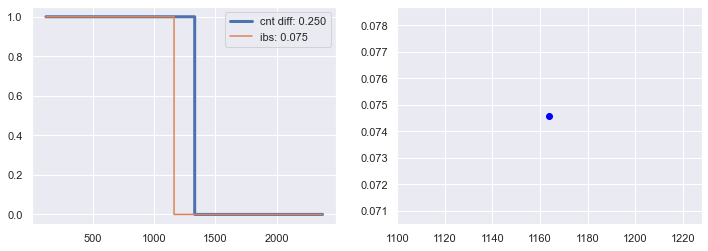

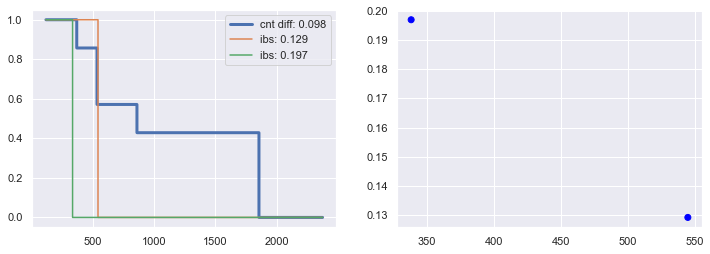

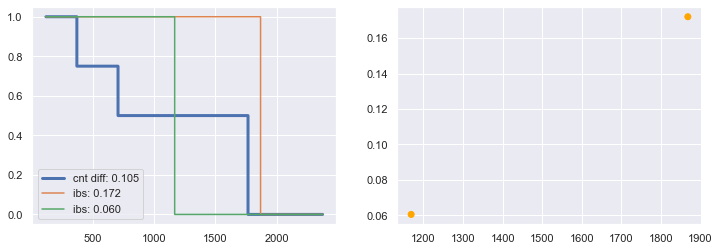

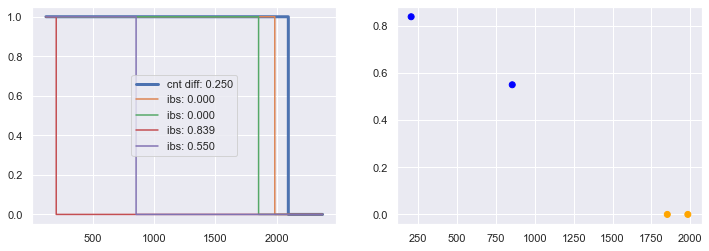

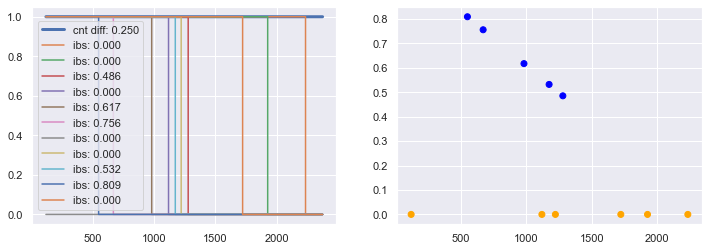

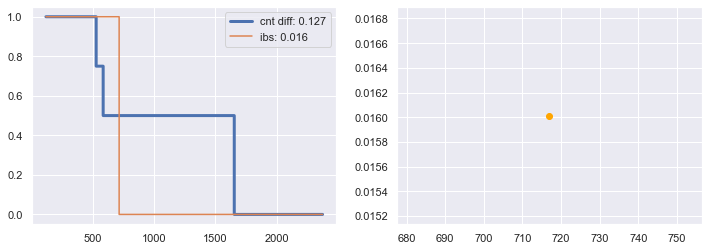

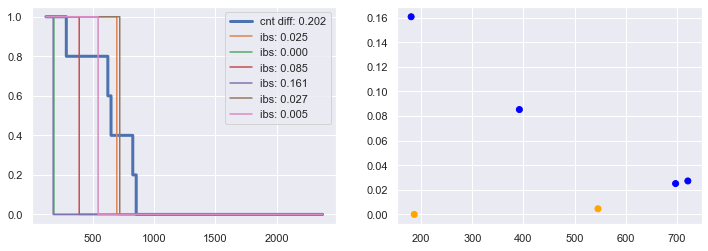

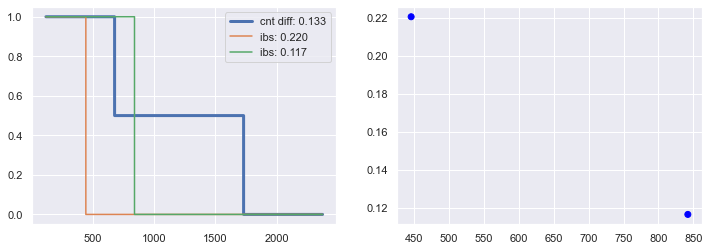

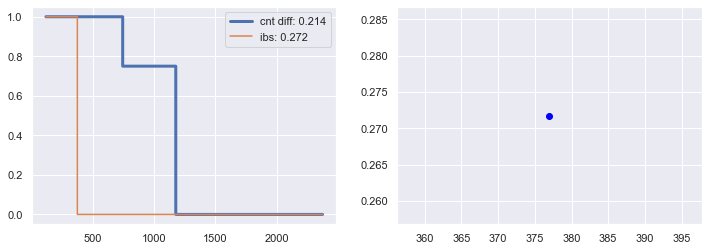

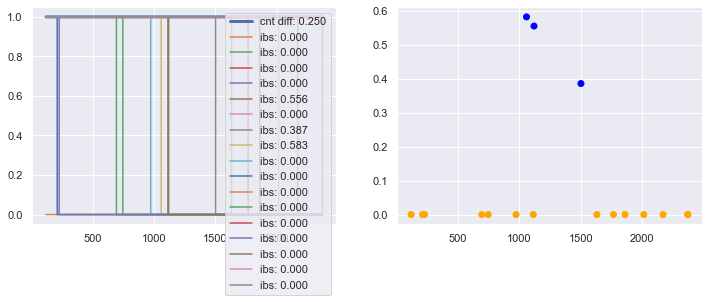

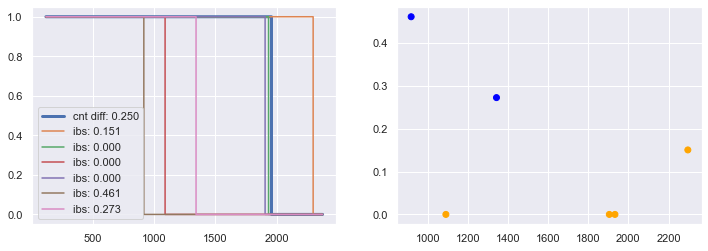

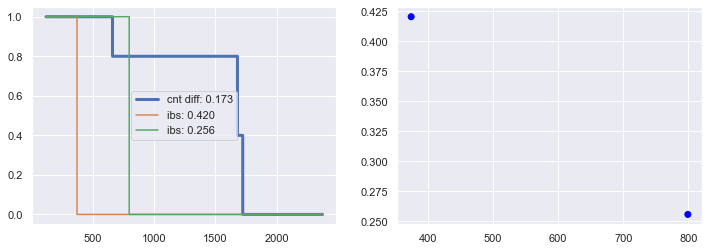

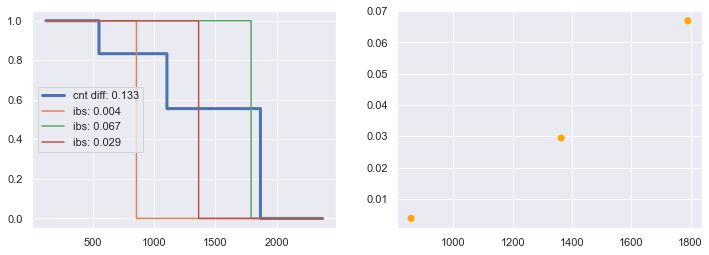

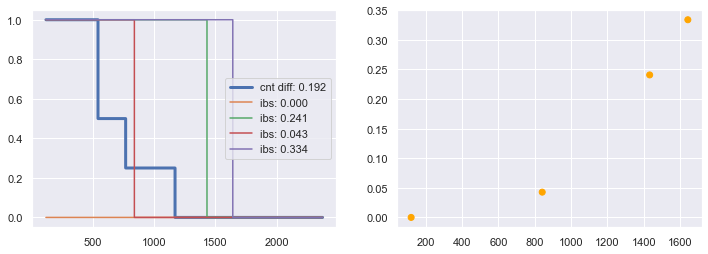

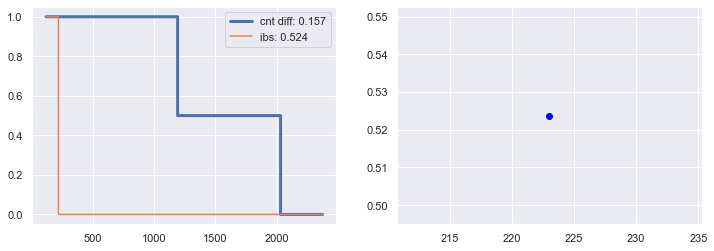

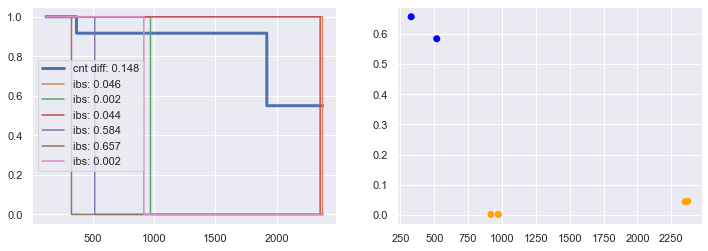

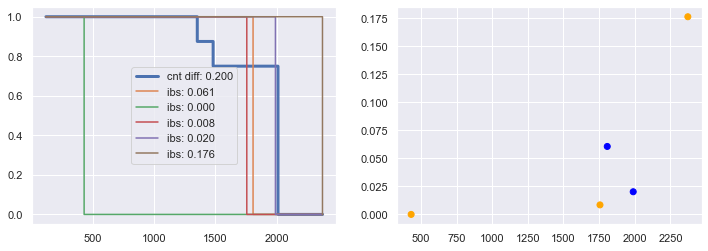

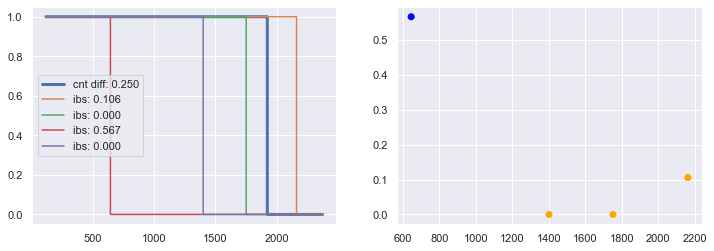

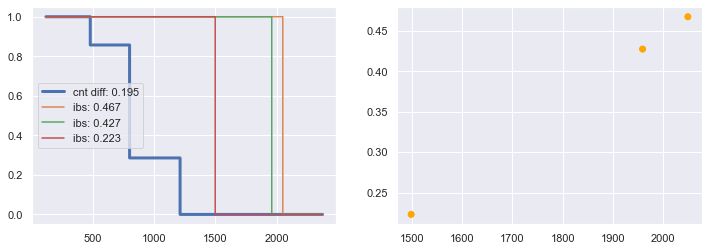

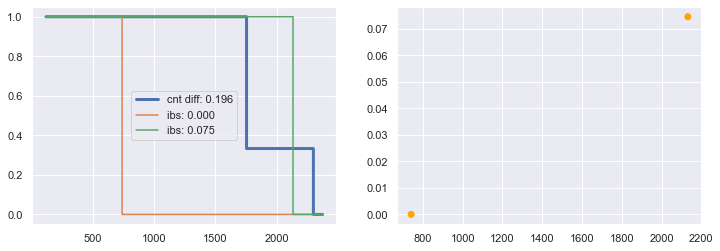

In [1323]:
for n_numb in np.unique(nodes):
    n = bstr.models[0].nodes[n_numb]
    y_HO_ = y_HO[np.where(nodes == n_numb)[0]]
    ibs_ = ibss[np.where(nodes == n_numb)[0]]
    
    sf = n.leaf_model.predict_survival_at_times(X=None, bins=bins_HO)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].step(bins_HO, sf, label=f"cnt diff: {np.sum((sf - 0.5)**2) / sf.shape[0]:.3f}", linewidth=3)
    for l_y, l_ibs in zip(y_HO_, ibs_):
        axes[0].step(bins_HO, np.where(bins_HO < l_y["time"], 1, 0), label=f"ibs: {l_ibs:.3f}")
    axes[0].legend()
    
    axes[1].scatter(y_HO_["time"], ibs_, c=np.where(y_HO_["cens"], "blue", "orange"))
    plt.show()